In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import glob
import os
import peakutils
import logging
import datetime
import warnings
from lmfit.models import PseudoVoigtModel, GaussianModel
from jupyterthemes import jtplot

In [2]:
from xps.xps_sw import *
from xps.xps_import import *
from xps.xps_analysis import *
from xps.xps_bg import *
from xps.xps_fits import *

jtplot.style('default', grid=False)
logging.getLogger().setLevel(logging.CRITICAL)
warnings.filterwarnings("ignore")

plt.rcParams['errorbar.capsize'] = 8
plt.rcParams['font.size'] = 18
plt.rc('font', size= 18)
plt.rc('legend', fontsize= 15)
plt.rc('xtick', labelsize= 18)
plt.rc('ytick', labelsize= 18)
plt.rc('axes', labelsize=18)
plt.rc('axes', titlesize=18)
plt.rcParams["xtick.major.size"] = 8
plt.rcParams["xtick.major.size"] = 8
plt.rcParams['axes.edgecolor'] = '0.'
plt.rcParams['axes.labelcolor'] = '0.'
plt.rcParams['xtick.color'] = '0.'
plt.rcParams['ytick.color'] = '0.'
plt.rcParams['text.color'] = '0.'
plt.rcParams['axes.linewidth'] = 1.6
plt.rcParams['lines.linewidth'] = 4

asf = dict({'C_1s' : 0.296, 'O_1s' : 0.711, 'N_1s' : 0.477, 'Ba_3d' : 7.49, 'Ba_3d_5/2' : 7.49, 'Ba_3d_3/2' : 5.20,
            'Br_3p' : 1.054, 'Cu_2p' : 5.321, 'Ba_4d': 2.35, 'Na_1s' : 1.685, 'Cl_2s' : 0.37,
           'In3d' : 4.359, 'Sn3d' : 4.725, 'Cl_2p' : 0.891, 'Si2p': 0.339})

In [836]:
asf2 = {'Ba_3d_5/2' : 25.8, 'Ba_3d_3/2': 17.9, 'Ba_4d': 5.86, 'Cl_2p': 2.28, 'Cl_2s': 1.69}

asf3 = {'Ba_3d_5/2' : 64.3, 'Ba_3d_3/2': 49.9, 'Ba_4d': 5.86, 'Cl_2p': 2.28, 'Cl_2s': 1.50}

In [262]:
plt.rcParams['axes.grid'] = False
plt.rcParams['axes.grid.which'] = 'major'
plt.rcParams['axes.grid.axis'] = 'x'

In [45]:
def plot_fit_result(xp: XPS_experiment, region: str, fitRes: ModelResult = None,
                    lb : str = None, ax = None, col:str = None, offset: float = 0.3,
                    plot_comps: bool = True, plot_bg:bool = False, flag_fill: bool = False):
    if ax == None : ax = plt.gca()
    if col == None: col = xp.color
    if lb == None: lb = xp.name
    if fitRes == None: fitRes = xp.fit[region]

    x = xp.dfx[region].dropna().energy
    ybg = np.zeros_like(x)
    if plot_bg == True:
        try:
            ybg = xp.dfx[region+'_bg'].dropna().counts
            ax.plot(x, ybg , ls='dotted', color=col, lw=2)
        except KeyError as e:
            print('Background not found for ', e)
            
    offset *= np.average(xp.dfx[region].dropna().counts.values)
    
    p1 = ax.scatter(x, xp.dfx[region].dropna().counts + ybg + offset,
                    color=col, label=lb, zorder = 1)

    ax.plot(x, fitRes.best_fit + ybg + offset, '-', color=col)#, label='best fit, $\chi^2_N$ = %i' %fitRes.redchi)
#     ax.legend(loc='upper left')

    if plot_comps:
        comps = fitRes.eval_components(x=x)
        for compo in comps:
            posx = fitRes.best_values[compo+'center']
            colc = ax.plot(x, comps[compo] + ybg + offset, ls='dotted', lw=2, color=col, label='__nolabel__')[0].get_color()

            ax.vlines(x=posx, ymin=ybg.min() + offset, ymax=(comps[compo] + ybg + offset).max(), lw=2, linestyle='-', colors=col)
            ax.text(x=posx, y=(comps[compo] + offset + ybg).max()*0.99, s='%.1f' %posx)
            if flag_fill:
                ax.fill_between(x, y1 = ybg, y2 = comps[compo] + ybg, alpha=0.3, color=col)
    ax.invert_xaxis()
    return ax, offset

## Figure 5: fluorescence spectra

In [50]:
pathflu = '/Users/pabloherrero/sabat/spectroscopy/emission_FBI_Ba_Na.png'
dflu = pd.read_csv(pathflu, sep=',', skiprows=1)
dflu.columns = ['fbi', 'fbina', 'fbiba']

dflu['fbina'] /= dflu['fbina'].max()
dflu['fbina'] += 0.1

dflu['fbiba'] /= dflu['fbiba'].max()
dflu['fbiba'] += 0.2

dflu['fbi'] /= dflu['fbi'].max()
dflu.columns = ['FBI', 'FBI-NaClO$_4$', 'FBI-BaClO$_4$']

485.07
481.94
453.03


Text(0.5, 0, 'Wavelength [nm]')

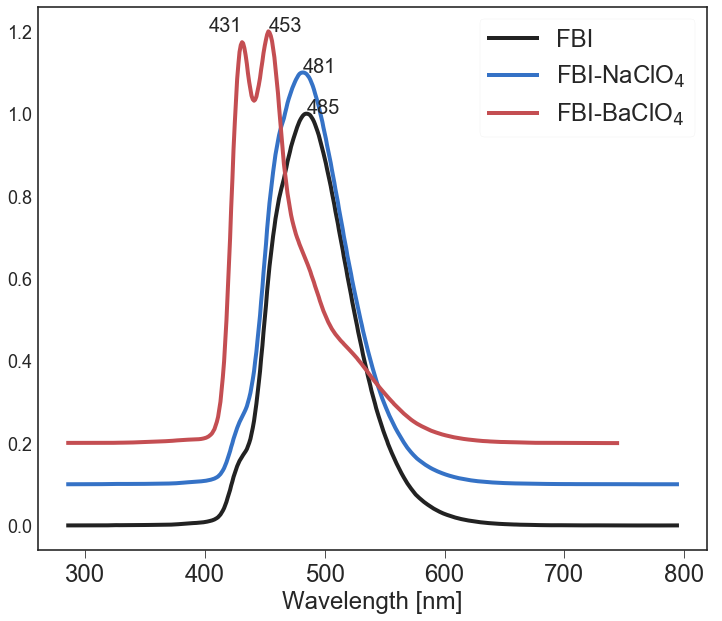

In [51]:
plt.figure(figsize=(12, 10))
dflu['FBI'].plot(color='k')
dflu['FBI-NaClO$_4$'].plot(color='b')
dflu['FBI-BaClO$_4$'].plot(color='r')

for co in dflu.columns:
    mx = dflu.index[np.argmax(dflu[co])]
    print(mx)
    plt.text(s='%i'%mx, x=mx, y=np.max(dflu[co]))
plt.text(s=431, x=431, y=np.max(dflu[co]), ha='right')
    
plt.legend(fontsize=24)
plt.xlabel('Wavelength [nm]', fontsize=24)

In [325]:
np.argmax(dflu['FBI-BaClO$_4$'].values)
np.argmax(dflu['FBI-BaClO$_4$'][:450])
dflu.index[145]

431.04

# Figure 2 comparison BaCl2/NaCl

## Raw data plot

In [263]:
path = '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_10_Au111/**/*.xy'

files = glob.glob(path, recursive=True)
files.sort()
file_clean = files[-1]
files[1:] = files[:-1]
files[0] = file_clean
print(files)

raw2 = [xps_data_import(f) for f in files]
cols = ['r', 'g', 'b', 'y']
for xp, c in zip(raw2, cols):
    xp.color = c
trim_spectra(raw2[2], raw2[0], 'N_1s', inplace=True);


['/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_10_Au111/20210510_Au111_clean2.xy', '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_10_Au111/20210510_Au111_FBI_subl_30min.xy', '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_10_Au111/20210510_Au111_FBI_subl_30min_BaCl2_30s.xy', '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_10_Au111/20210510_Au111_FBI_subl_30min_BaCl2_60s.xy']


In [5]:
for xp in raw2[:3]:
    trim_spectra(xp, raw2[3], 'O_1s', inplace=True)

for xp in raw2:
    crop_spectrum(xp, 'O_1s', edw=529, inplace=True)

In [92]:
r = 'O_1s'
norm2 = [normalise_dfx(xp,r) for xp in raw2]

for xp in norm2:
    trim_spectra(xp, norm2[3],r, inplace=True);#, eup=537.8, edw=529.5);

In [566]:
path = '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_07_Au111/*.xy'

files = glob.glob(path, recursive=True)
files.sort()
files[0], files[1] = files[1], files[0]
print(files)

raw1 = [xps_data_import(f) for f in files]

['/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_07_Au111/20210507_Au111_clean.xy', '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_07_Au111/20210507_Au111_FBI_subl_30min.xy', '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_07_Au111/20210508_Au111_FBI_subl_30min_NaCl_2min.xy', '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_07_Au111/20210508_Au111_FBI_subl_30min_NaCl_2min_150ºC.xy']


In [265]:
raw1[1].color = 'darkgreen'
raw1[2].color = 'y'

In [ ]:
# norm1 = [normalise_dfx(xp, r) for xp in [raw2[0]]+raw1[1:]]
norm1 = [normalise_dfx(xp, r) for xp in raw1]

for xp in norm1:
    trim_spectra(xp, norm1[3],r, inplace=True);#, eup=537.8, edw=529.5);

In [567]:
norm1 = [normalise_dfx(xp, r) for xp in norm1]

In [ ]:
trim_spectra(raw1[2], raw2[3], 'O_1s', inplace=True);
trim_spectra(raw1[1], raw2[3], 'O_1s', inplace=True);

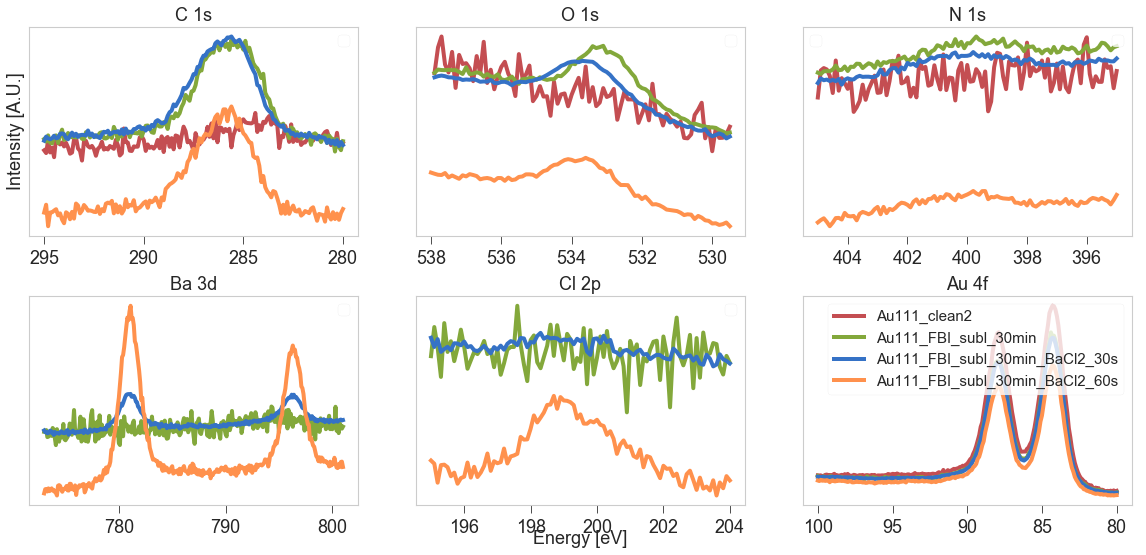

In [10]:
regs = ['C_1s', 'O_1s', 'N_1s', 'Ba_3d', 'Cl_2p', 'Au_4f']

plot_xp_regions(raw2, regs, ncols=3);
# plt.gcf().savefig('/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_26_Cu/Unscaled_exps.png', dpi=200)

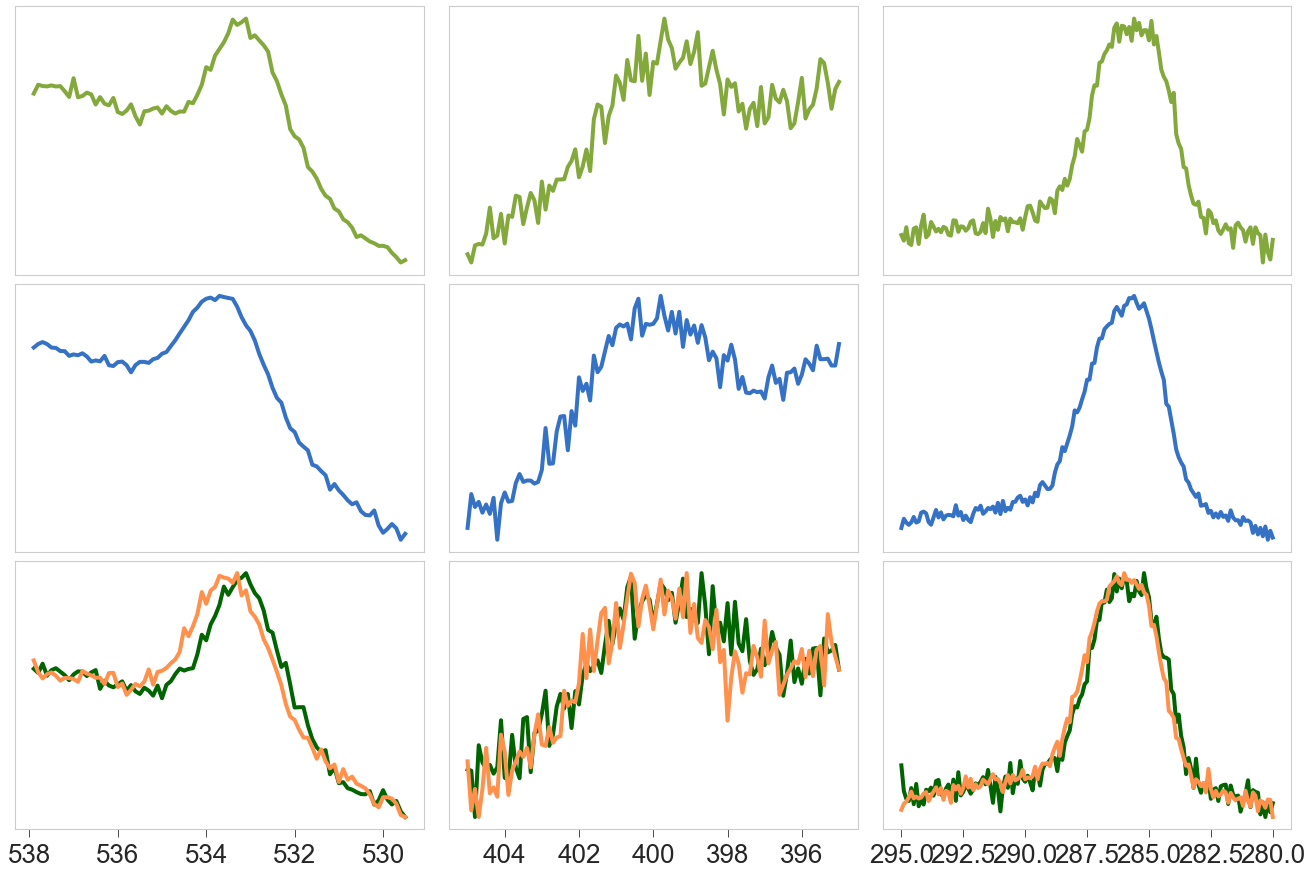

In [395]:
regs = ['O_1s', 'N_1s', 'C_1s']
sel = [raw2[1], raw2[2], normalise_dfx(raw1[1]), normalise_dfx(raw1[2])]
off = [800, 800, 400]
plt.rc('xtick', labelsize= 26)

fig, ax = plt.subplots(3,3, figsize=(18, 12))
for j, r in enumerate(regs):
    for i, xp in enumerate(sel[:3]):
        plot_region(xp, r, ax=ax[i,j])
        ax[i,j].set(yticks=[], ylabel=None, xlabel=None)
        ax[i,j].invert_xaxis()
        if i < 2: ax[i,j].set(xticks=[])
    plot_region(sel[3], r, ax=ax[i,j], offset=0)#off[j])
ax[i,j].set(yticks=[], ylabel=None, xlabel=None)

ax[i,j].get_legend().remove()
# ax[i,j].invert_xaxis()
plt.tight_layout(w_pad=0.5, h_pad=0.5, pad=0.1)
plt.rc('xtick', labelsize= 16)


# Figure 2 b) progressive barium addition

## Raw data plot 

In [9]:
path = '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_21_Au111/*.xy'

files = glob.glob(path, recursive=True)
files.sort()
# files[2], files[3] = files[3], files[2]
print(files)

raw3 = [xps_data_import(f) for f in files]
cols = ['k','g', 'b', 'y', 'm', 'c', 'r', 'k']
for xp, c in zip(raw3, cols):
    xp.color = c

['/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_21_Au111/20210520_Au111_clean.xy', '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_21_Au111/20210521_Au111_FBI_subl_45min.xy', '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_21_Au111/20210521_Au111_FBI_subl_45min_BaCl2_10s.xy', '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_21_Au111/20210522_Au111_FBI_subl_45min_BaCl2_20s.xy', '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_21_Au111/20210523_Au111_FBI_subl_45min_BaCl2_30s.xy', '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_21_Au111/20210523_Au111_FBI_subl_45min_BaCl2_40s.xy', '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_21_Au111/20210524_Au111_FBI_subl_45min_BaCl2_60s.xy', '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_21_Au111/20210524_Au111_FBI_subl_45min_BaCl2_80s.xy']


In [8]:
region = 'O_1s'
crop_spectrum(raw2[1], region, eup=536, edw=529, inplace=True)
crop_spectrum(raw2[2], region, eup=536, edw=529, inplace=True);

In [50]:
crop_spectrum(raw3[1], region, eup=536, edw=529.5, inplace=True)
crop_spectrum(raw3[4], region, eup=536, edw=529.5, inplace=True);

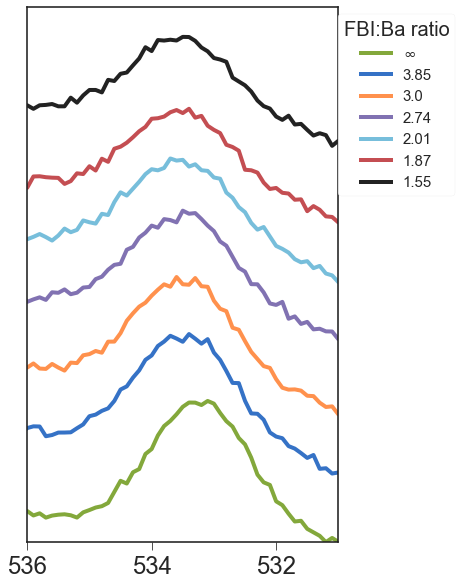

In [194]:
fbibaratio = ['$\infty$', 3.85, 3.0, 2.74, 2.01, 1.87, 1.55]
fig, ax = plt.subplots(1, sharex=False, figsize=(5, 8))
plt.xlabel("Energy [eV]")
plt.ylabel("Counts [A.U.]")
r = 'O_1s'

seps =  532
enmx, comx = [], []
handles = []
for i, xp in enumerate(raw3[1:]):
    
    if i == 0:
        off = -200
    else: off = 200*i
    li = plot_region(xp, r, offset=off)
    handles.append(li)
    ax = plt.gca()
    argmx = np.argmax(xp.dfx[r].counts)

    enmx.append(xp.dfx[r].energy.loc[argmx])
    comx.append(xp.dfx[r].counts.loc[argmx])# + off)
ax.plot(enmx, comx, '--k', lw=2.5)
ax.set(xlim=(536, 531), ylim=(4.3e3, 5.6e3), xlabel='', ylabel='', yticks=[])
# ax.invert_xaxis()

plt.tight_layout(w_pad=0.5, h_pad=0.5, pad=0.1)     #  First manage the space and THEN add the legend
labels = [str(cov) for cov in fbibaratio]#[::-1]
ax.legend(handles, labels, ncol=1, title='FBI:Ba ratio', loc='upper right', bbox_to_anchor=(1.4, 1.))           

# fig.savefig('/Users/pabloherrero/Dropbox/phd/drafts/fbi_cu_sublimation/v3/fbi_coverage_all_norm.png', dpi=200, bbox_inches = 'tight')

In [60]:
enmx, comx

([546.7, 546.8, 546.7, 546.8, 546.5, 547.0, 546.8],
 [6233.1625, 5967.0909, 5909.0521, 5887.0577, 5800.6125, 5723.1866, 5668.2943])

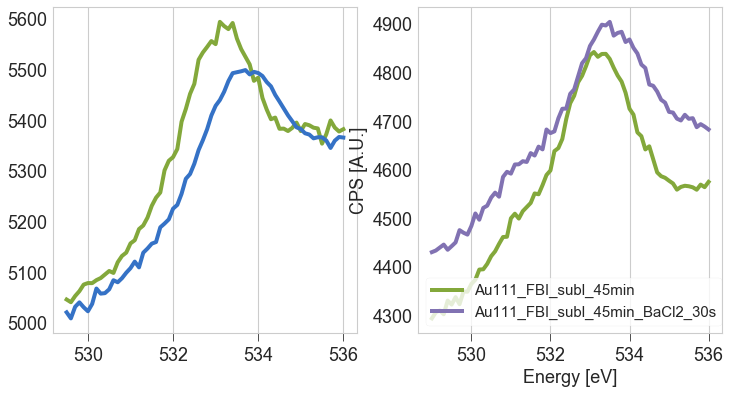

In [112]:
region = 'O_1s'
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plot_region(raw2[1], region=region, ax=ax[0])
plot_region(raw2[2], region=region, ax=ax[0])
plot_region(raw3[1], region=region, ax=ax[1])
plot_region(raw3[4], region=region, ax=ax[1], offset=400)

In [129]:
raw2[1].color = 'lime'

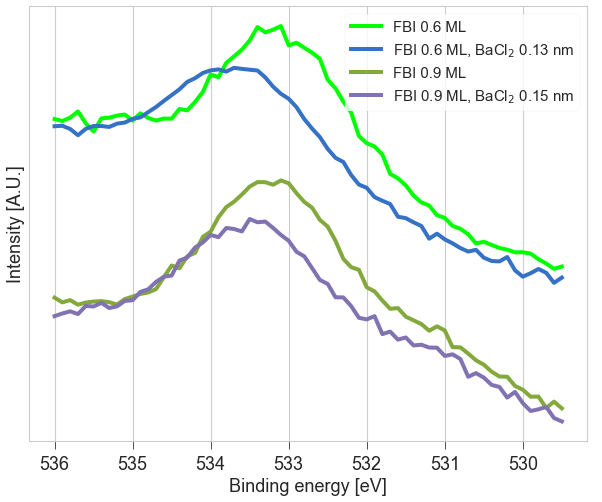

In [144]:
plt.figure(figsize=(10, 8))
region = 'O_1s'

plot_region(raw2[1], region=region, lb='FBI 0.6 ML')
plot_region(raw2[2], region=region, lb='FBI 0.6 ML, BaCl$_2$ 0.13 nm')
plot_region(raw3[1], region=region, offset=400, lb='FBI 0.9 ML')
plot_region(raw3[4], region=region, offset=400+250, lb='FBI 0.9 ML, BaCl$_2$ 0.15 nm')

ax = plt.gca()
ax.legend(loc='upper right')
# ax.get_legend().set(')
ax.set(yticks=[], xlabel='Binding energy [eV]', ylabel='Intensity [A.U.]')
ax.invert_xaxis()
# plt.gcf().savefig('/Users/pabloherrero/Dropbox/phd/drafts/fbi_cu_sublimation/v4_au/fig2_xps_chelation/fig2_xps_chelation.c).png')

# Figure 5, Chelation in Cu and qITO

## Shift in Cu sample 13 (BaCl2)

In [418]:
path = '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_21*/*.xy'

files = glob.glob(path, recursive=True)
files.sort()
files

['/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_21_Cu/20210421_16-Cu_FBI_subl_22min.xy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_21_Cu/20210421_16-Cu_FBI_subl_22min_BaCl2_1min.xy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_21_Cu/20210421_16-Cu_FBI_subl_22min_BaCl2_2min.xy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_21_Cu/20210421_16-Cu_FBI_subl_22min_BaCl2_6min.xy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_21_Cu/20210421_16-Cu_FBI_subl_22min_BaCl2_6min_200grad.xy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_21_Cu/20210421_16-Cu_FBI_subl_22min_BaCl2_6min_250grad.xy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_21_Cu/20210421_16-Cu_FBI_subl_22min_BaCl2_6min_300grad.xy',
 '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_21_Cu/20210421_16-Cu_clean.xy']

In [419]:
cuba = [xps_data_import(f) for f in files]
cuba[0].color = 'g'
cuba[3].color = 'b'
cuba = [normalise_dfx(xp) for xp in [cuba[0], cuba[3]]]

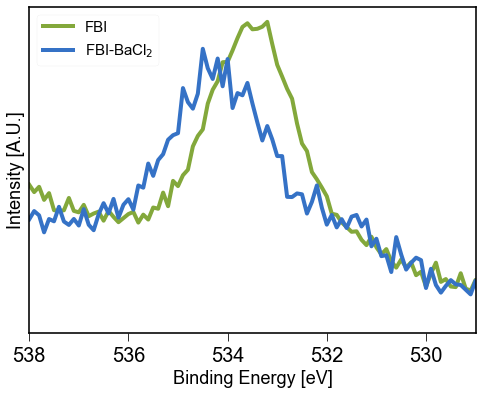

In [420]:
region = 'O_1s'
fig = plt.figure(figsize=(8, 6))
plot_region(cuba[0], region, offset=0.1)
plot_region(cuba[1], region)
ax = plt.gca()
ax.set(xlabel = 'Binding Energy [eV]',xlim=(538, 529), ylabel='Intensity [A.U.]', yticks=[])
# ax.invert_xaxis()
ax.legend(handles=ax.get_lines(), labels=['FBI', 'FBI-BaCl$_2$'], loc='upper left')

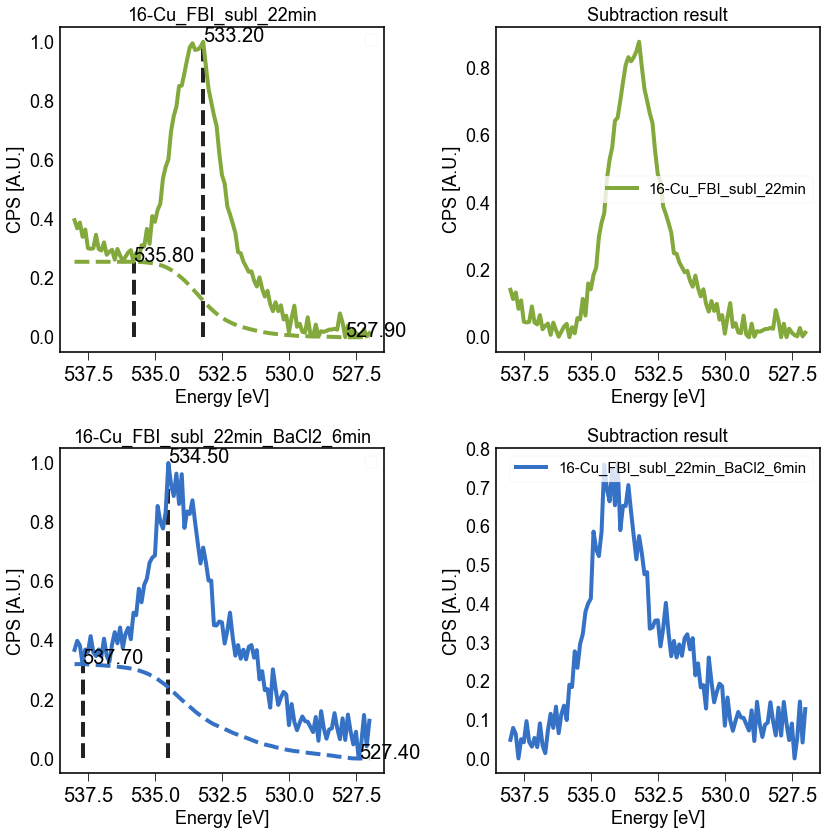

In [421]:
cuba = region_bg_subtract(cuba, region=region, flag_plot=True)

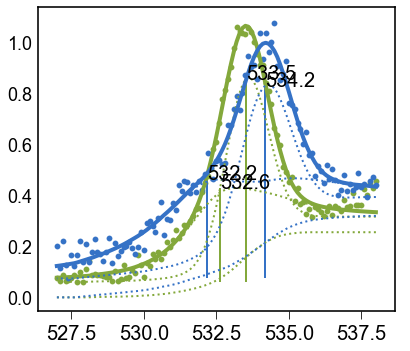

In [422]:
for xp in cuba:
    Fn = XPFit(xp, 'O_1s')
    Fn.double_voigt(533.5)
    Fn.plot(plot_bg=True)

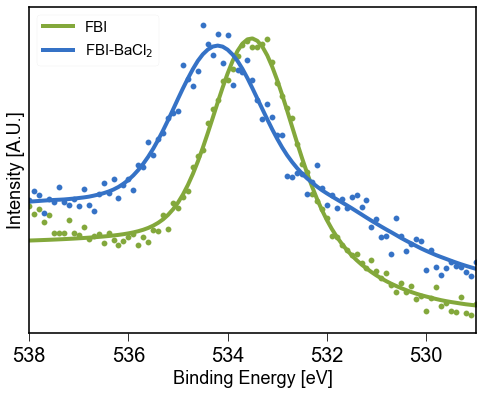

In [425]:
fig = plt.figure(figsize=(8, 6))
plot_fit_result(cuba[0], region, plot_bg=True, plot_comps=False, offset=0.1)
plot_fit_result(cuba[1], region, plot_bg=True, plot_comps=False)
ax = plt.gca()
ax.set(xlabel = 'Binding Energy [eV]',xlim=(538, 529), ylabel='Intensity [A.U.]', yticks=[])
# ax.invert_xaxis()
ax.legend(handles=ax.get_lines(), labels=['FBI', 'FBI-BaCl$_2$'], loc='upper left')

## Shift in sample 9 (NaCl) for inset

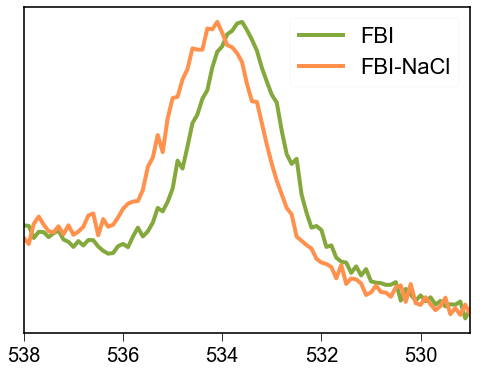

In [426]:
path = '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_05_04*/*.xy'

files = glob.glob(path, recursive=True)
files.sort()
files

nacl = [xps_data_import(f) for f in files]
nacl[0].color = 'g'
nacl[2].color = 'y'
nacl = [normalise_dfx(xp) for xp in [nacl[0], nacl[2]] ]
region = 'O_1s'
fig = plt.figure(figsize=(8, 6))
plot_region(nacl[0], region)
plot_region(nacl[1], region)
ax = plt.gca()
ax.set(xlabel = None, ylabel=None, xlim=(538, 529), yticks=[])
# ax.invert_xaxis()
ax.legend(handles=ax.get_lines(), labels=['FBI', 'FBI-NaCl'], loc='upper right', fontsize=22)

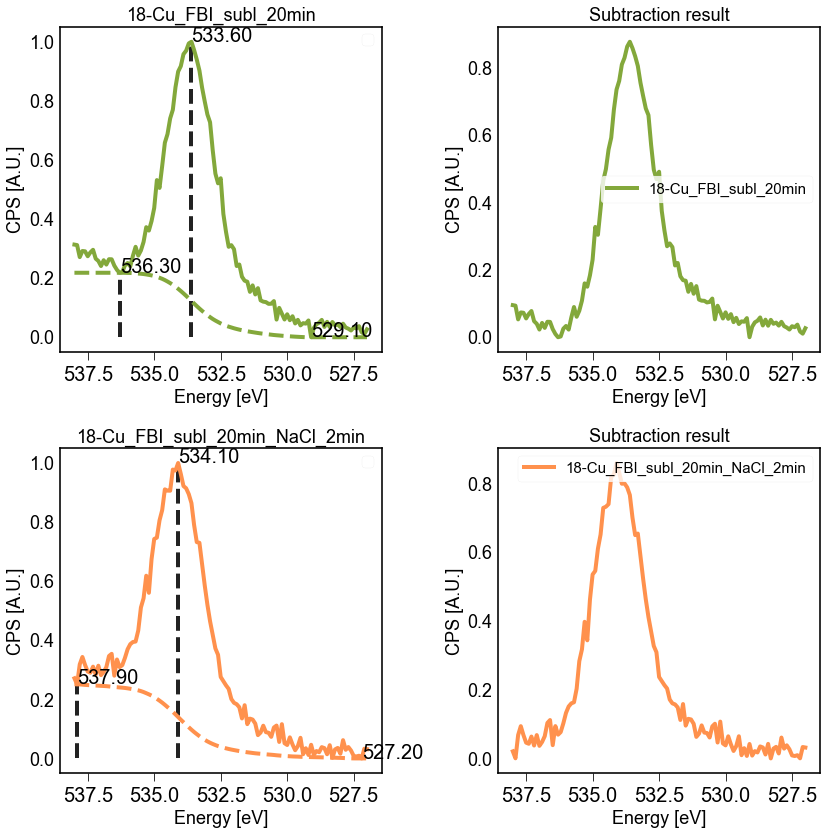

In [427]:
nacl = region_bg_subtract(nacl, region=region, flag_plot=True)

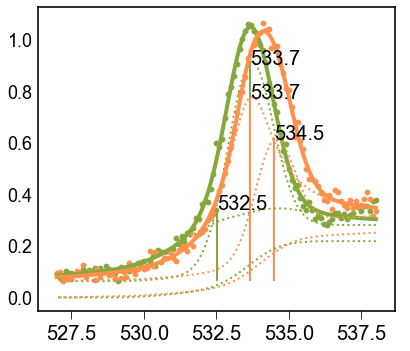

In [428]:
for xp in nacl:
    Fn = XPFit(xp, 'O_1s')
    Fn.double_voigt(533.5)
    Fn.plot(plot_bg=True)

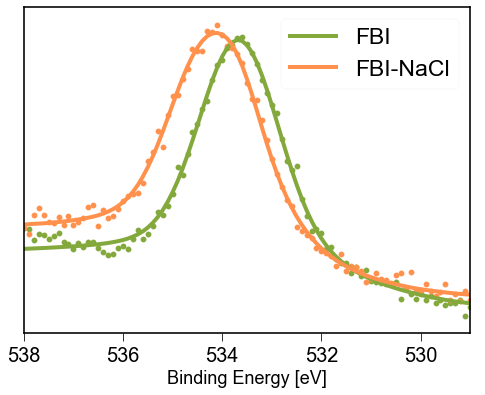

In [470]:
fig = plt.figure(figsize=(8, 6))
region = 'O_1s'
plot_fit_result(nacl[0], region, plot_bg=True, plot_comps=False, offset=0.1)
plot_fit_result(nacl[1], region, plot_bg=True, plot_comps=False)
ax = plt.gca()
ax.set(xlabel = 'Binding Energy [eV]',xlim=(538, 529), yticks=[])
# ax.invert_xaxis()
ax.legend(handles=ax.get_lines(), labels=['FBI', 'FBI-NaCl'], loc='upper right', fontsize=23)
plt.savefig('/Users/pabloherrero/Dropbox/phd/drafts/fbi_cu_sublimation/v4_au/fig5_cu_ito/fig4_cu_ito.b).png',
            dpi=2000)

## Figure 5 b) qITO

In [66]:
def subtract_fit_component(xp: XPS_experiment, region:str, prefix: str, fitRes = None,
                           flag_plot:bool = True, store:bool = True, inplace:bool = False):
    """Subtract a fit component from the data, prefix specifies which component
        Returns XPS_experiment: a single dfx region with the subtraction result"""
    x = xp.dfx[region].dropna().energy.values
    y = xp.dfx[region].dropna().counts.values
    if fitRes == None:  fitRes = xp.fit[region]
        
    comps = fitRes.eval_components(x=x)
    yv1 = comps[prefix]
    yb1 = y - yv1
    if flag_plot:
        fig, ax = plt.subplots(1, 2, sharex=True, figsize=(12, 6))
        plot_fit_result(xp, region, ax=ax[0], fitRes=fitRes)
        ax[0].set(title=xp.name+ ' original fit')
        lim = ax[0].get_ylim()
        ax[1].plot(x, yb1, color=xp.color)
        ax[1].set(title='v1 subtraction', yticks=[], ylim=lim)
    
    xpNew = deepcopy(xp)
    xpNew.dfx[region, 'energy'] = pd.Series(x)
    xpNew.dfx[region, 'counts']  = pd.Series(yb1)

    if store:    
        xpNew.dfx[region+'_'+prefix+'bg', 'energy'] = pd.Series(x)
        xpNew.dfx[region+'_'+prefix+'bg', 'counts']  = pd.Series(yv1)
    
    if inplace:
        insert_dfx_region(xp, xpNew, region=region, inplace=True)
        insert_dfx_region(xp, xpNew, region=region+'_'+prefix+'bg', inplace=True)
        
    else:
        return xpNew

In [430]:
path = '/Users/pabloherrero/sabat/xps_spectra/ITO_FBI/qITO_subl/**/*.uxy'
files = glob.glob(path, recursive=True)
files.sort()
files.pop(1)
files

qito = [read_processed_xp(f) for f in files]

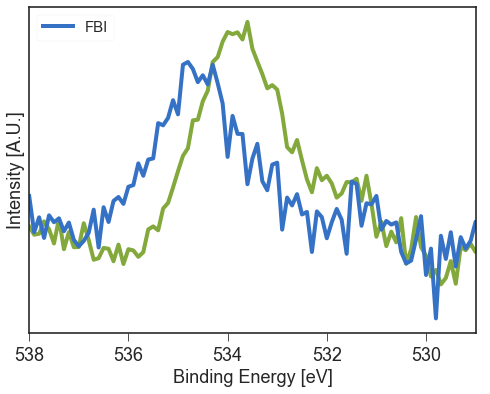

In [75]:
fig = plt.figure(figsize=(8, 6))
plot_region(ito[0], region)
plot_region(ito[1], region)
ax = plt.gca()
ax.set(xlabel = 'Binding Energy [eV]',xlim=(538, 529), ylabel='Intensity [A.U.]', yticks=[])
# ax.invert_xaxis()
ax.legend(handles=ax.get_lines()[1::2], labels=['FBI', 'FBI-BaCl$_2$'], loc='upper left')

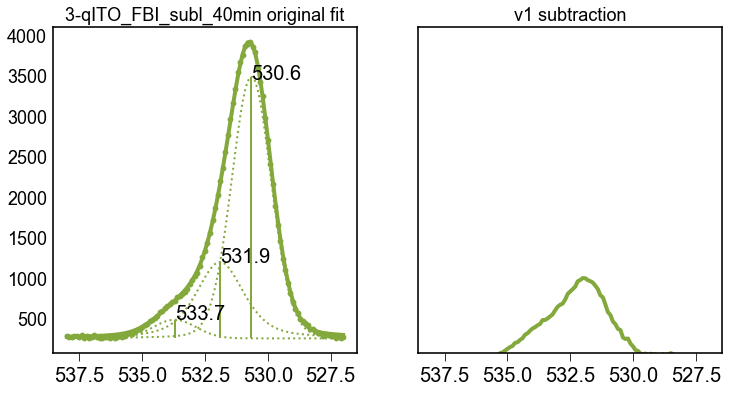

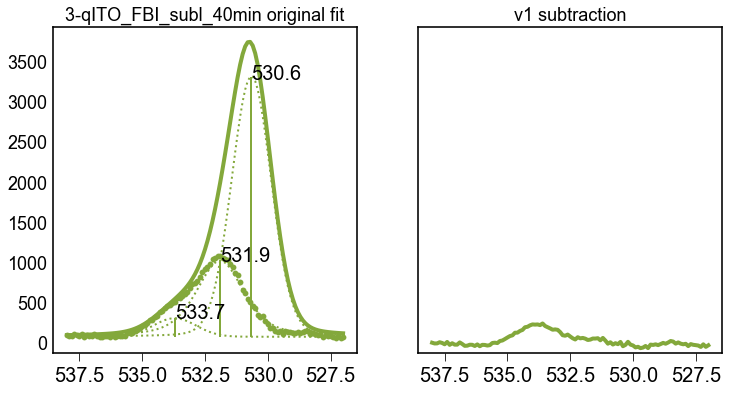

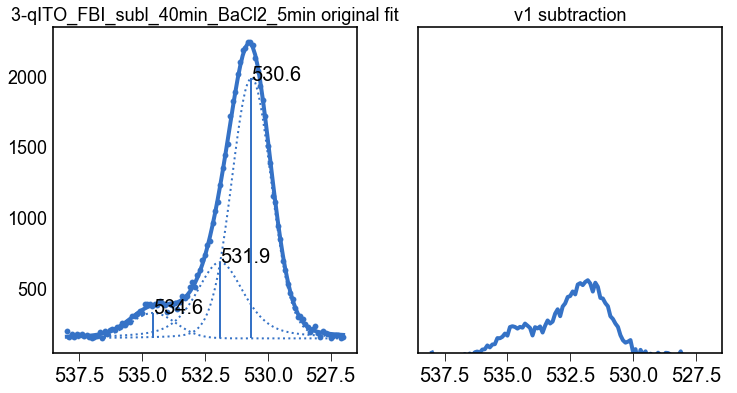

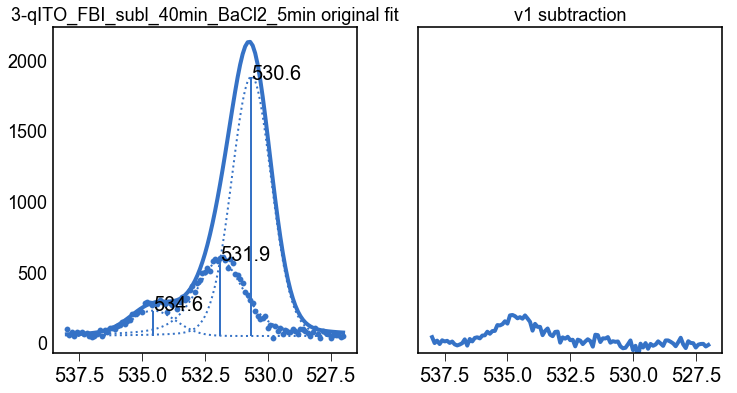

In [457]:
ito = []
region = 'O1s'
buf = subtract_fit_component(qito[2], region, prefix='v1_')
ito.append(subtract_fit_component(buf, region, prefix='v2_'))

buf = subtract_fit_component(qito[3], region, prefix='v1_')
ito.append(subtract_fit_component(buf, region, prefix='v2_'))

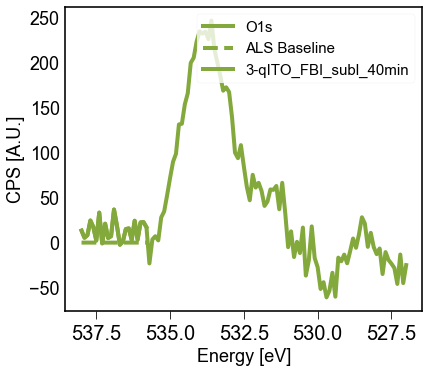

In [461]:
fix_tail_bg(ito[0], 'O1s', edw=535.8, store=False, inplace=True);

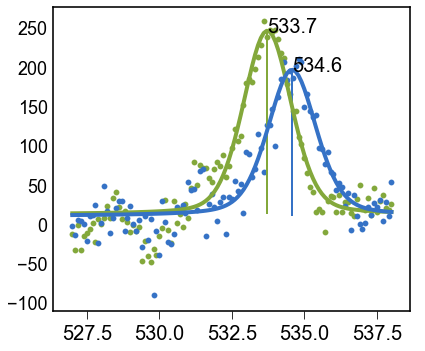

In [462]:
for xp in ito:
    Fn = XPFit(xp, 'O1s')
    Fn.voigt()
    Fn.plot()

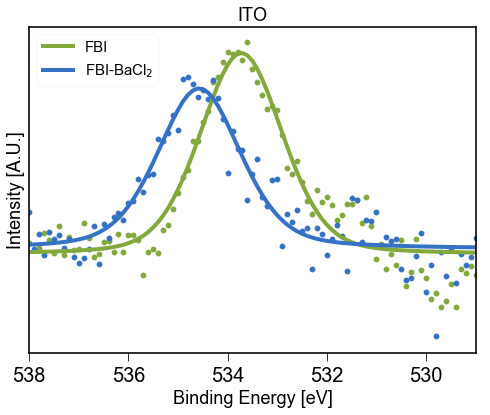

In [460]:
fig = plt.figure(figsize=(8, 6))
plot_fit_result(ito[0], region, plot_comps=False, offset=0.1)
plot_fit_result(ito[1], region, plot_comps=False)
ax = plt.gca()
ax.set(title='ITO', xlabel = 'Binding Energy [eV]',xlim=(538, 529), ylabel='Intensity [A.U.]', yticks=[])
# ax.invert_xaxis()
ax.legend(handles=ax.get_lines(), labels=['FBI', 'FBI-BaCl$_2$'], loc='upper left')

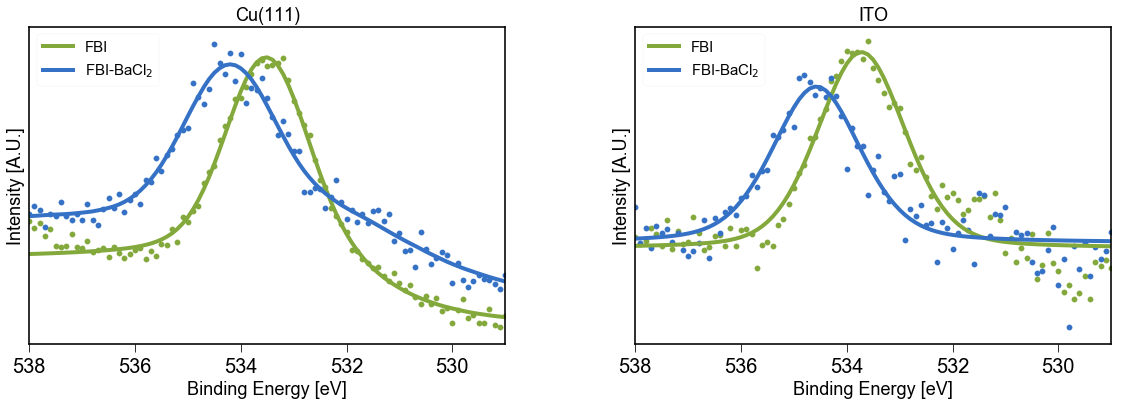

In [463]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
region = 'O_1s'           
plot_fit_result(cuba[0], region, plot_bg=True, plot_comps=False, offset=0.1, ax=ax[0])
plot_fit_result(cuba[1], region, plot_bg=True, plot_comps=False, ax=ax[0])
ax[0].set(title='Cu(111)', xlabel = 'Binding Energy [eV]',xlim=(538, 529), ylabel='Intensity [A.U.]', yticks=[])
# ax.invert_xaxis()
ax[0].legend(handles=ax[0].get_lines(), labels=['FBI', 'FBI-BaCl$_2$'], loc='upper left')
region = 'O1s'           
plot_fit_result(ito[0], region, plot_comps=False, ax=ax[1], offset=0.1)
plot_fit_result(ito[1], region, plot_comps=False, ax=ax[1])
ax[1].set(title='ITO', xlabel = 'Binding Energy [eV]',xlim=(538, 529), ylabel='Intensity [A.U.]', yticks=[])
# ax.invert_xaxis()
ax[1].legend(handles=ax[1].get_lines(), labels=['FBI', 'FBI-BaCl$_2$'], loc='upper left')
plt.tight_layout(w_pad=5, h_pad=0.5, pad=1)
plt.savefig('/Users/pabloherrero/Dropbox/phd/drafts/fbi_cu_sublimation/v4_au/fig5_cu_ito/fig4_cu_ito.a).png',
            dpi=2000)

## Unsubstracted qITO peaks

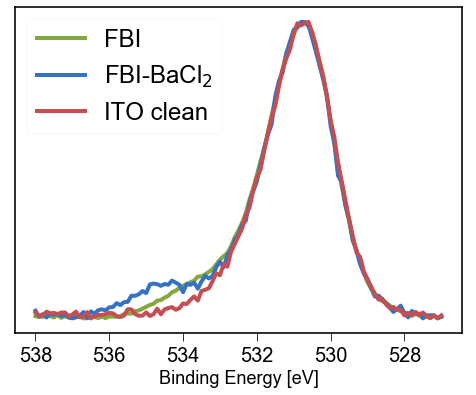

In [464]:
fig = plt.figure(figsize=(8, 6))
for xp in qito[2:]:
    plot_region(normalise_dfx(xp), 'O1s')
ax = plt.gca()
ax.set(xlabel = 'Binding Energy [eV]', ylabel=None, yticks=[])
ax.legend(handles=ax.get_lines(), labels=['FBI', 'FBI-BaCl$_2$', 'ITO clean'], loc='upper left', fontsize=24)
plt.savefig('/Users/pabloherrero/Dropbox/phd/drafts/fbi_cu_sublimation/v4_au/fig5_cu_ito/fig4_cu_ito.c).png',
            dpi=2000)

# Supplementary Information figures

## BaCl$_2$ evaporation in Cu and Au

[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/Cu_BaCl2/proc/Cu_BaCl220201026_Cu_BaCl2_subl_45min.sxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_25_Au111/proc/20210525_Au111_BaCl2_subl_320s.sxy.ft', returning empty fit dict


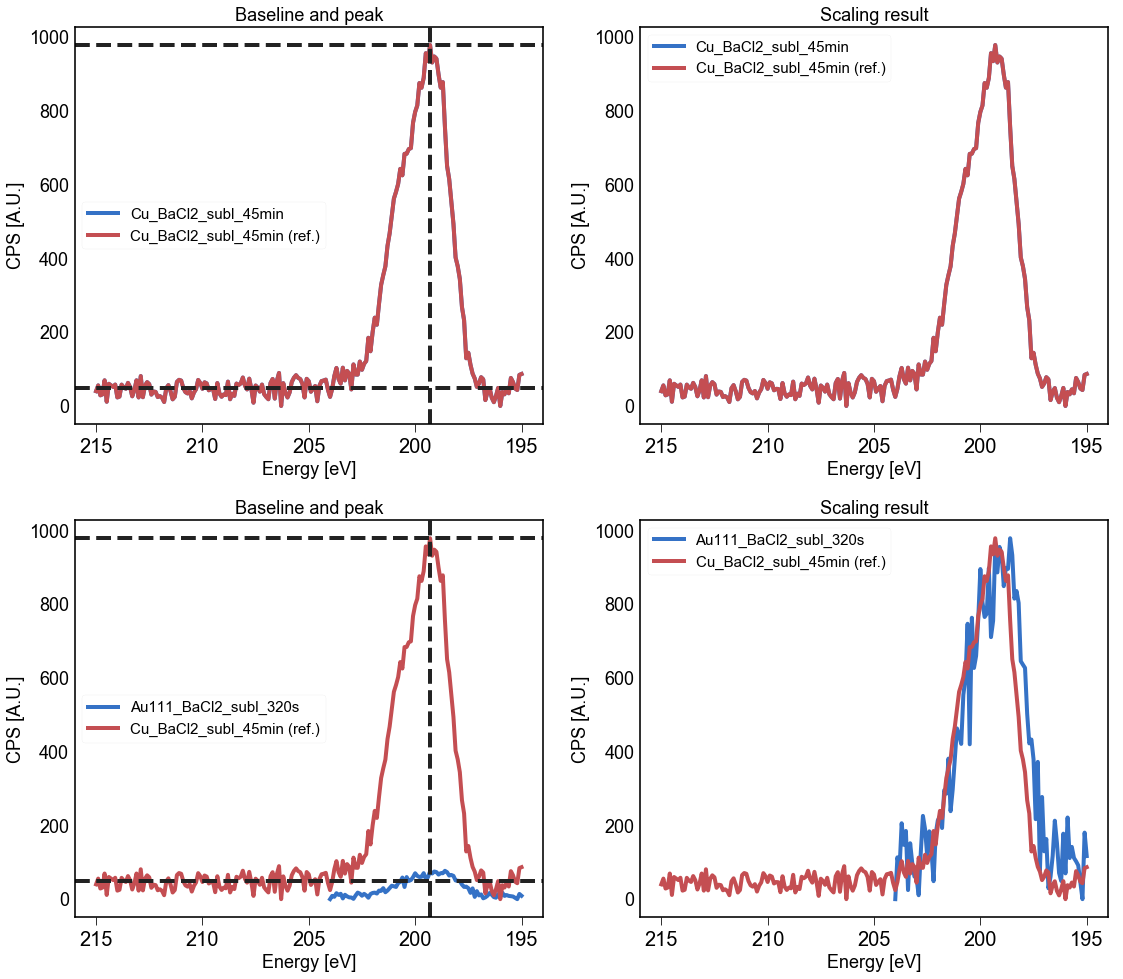

In [471]:
pathbacu = '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/Cu_BaCl2/proc/Cu_BaCl220201026_Cu_BaCl2_subl_45min.sxy'
baclcu = read_processed_xp(pathbacu)
baclcu.color = 'k'

pathbaau = '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_25_Au111/proc/20210525_Au111_BaCl2_subl_320s.sxy'
baclau = read_processed_xp(pathbaau)
baclau.color = 'r'
[baclcu, baclau] = scale_and_plot_spectra([baclcu, baclau], indRef=0, region='Cl_2p')

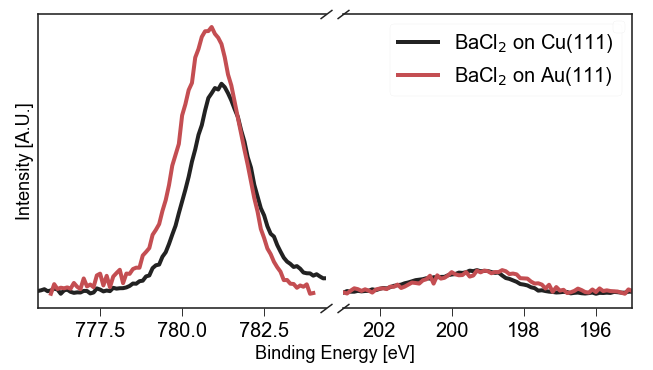

In [481]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(10, 6))
ax2 = fig.add_subplot(111, frameon=False)
ax2.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plot_region(baclcu, 'Cl_2p', ax=ax[1], lb='BaCl$_2$ on Cu(111)')
plot_region(baclcu, 'Ba_3d', ax=ax[0])
plot_region(baclau, 'Cl_2p', ax=ax[1], lb='BaCl$_2$ on Au(111)')
plot_region(baclau, 'Ba_3d', ax=ax[0])

ax[0].set(yticks=[], xlim=(775.6, 784.4))
ax[1].set(yticks=[], xlim=(203,195), xlabel=None, ylabel=None, ylim=ax[0].get_ylim())
ax[1].legend(fontsize=20)

for a in ax:
    for sp in a.spines:
        a.spines[sp].set_color('k')
ax[0].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
plt.tight_layout(w_pad=0.05, )

d = .75  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12, 
              linestyle="none", color='k', mec='k', mew=1.5, clip_on=False)
ax[0].plot([1, 1], [1, 0], transform=ax[0].transAxes, **kwargs)
ax[1].plot([0, 0], [0, 1], transform=ax[1].transAxes, **kwargs)
ax[0].set_ylabel('Intensity [A.U.]')
ax2.set_ylabel('')
ax2.set_xlabel('Binding Energy [eV]')

plt.savefig('/Users/pabloherrero/Dropbox/phd/drafts/fbi_cu_sublimation/v4_au/si_figures/si_bacl_au_cu.png',
            dpi=2000)

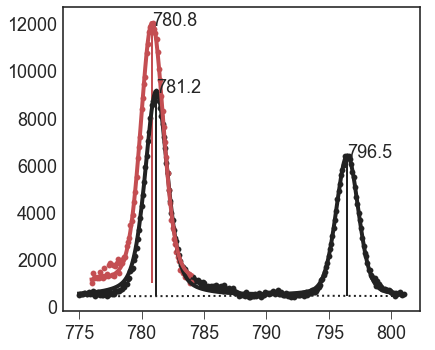

In [102]:
r = 'Ba_3d'
xpc = crop_spectrum(baclcu, r, edw=775)
Fn = XPFit(xpc, r)
Fn.double_voigt()
Fn.plot()
# xpc = crop_spectrum(baclcu, r, edw=775)
Fn = XPFit(baclau, r)
Fn.voigt()

Fn.plot()

In [87]:
sep3d = xpc.fit[r].best_values['v1_center'] - xpc.fit[r].best_values['v2_center']
baclau.fit[r].best_values['v1_center'] - sep3d

796.1527110560477

In [62]:
ax[0].spines

OrderedDict([('left', <matplotlib.spines.Spine at 0x1a222478d0>),
             ('right', <matplotlib.spines.Spine at 0x1a19824e10>),
             ('bottom', <matplotlib.spines.Spine at 0x1a19824a58>),
             ('top', <matplotlib.spines.Spine at 0x1a19824208>)])

In [332]:
ax[0].get_xlim()

(775.6, 784.4)

## Compare position of Ba 3d with FBI

### Cu (111)

In [521]:
path = '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_21*/**/*.uxy'

files = glob.glob(path, recursive=True)
files.sort()
files

cubaproc = [read_processed_xp(f) for f in files]
cubaproc[0].color = 'g'
cubaproc[3].color = 'b'
# cubaproc = [normalise_dfx(xp) for xp in [cubaproc[0], cubaproc[3]]]

[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_21_Cu/proc/20210421_16-Cu_FBI_subl_22min_BaCl2_6min_200grad.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_21_Cu/proc/20210421_16-Cu_FBI_subl_22min_BaCl2_6min_300grad.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_21_Cu/proc/20210421_16-Cu_clean.uxy.ft', returning empty fit dict


In [522]:
path = '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_02_03*/**/*.uxy'

files = glob.glob(path, recursive=True)
files.sort()
print(files)

cubaproc2 = [read_processed_xp(f) for f in files]
# cubaproc = [normalise_dfx(xp) for xp in [cubaproc[0], cubaproc[3]]]

['/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_02_03_Cu/proc/20210203_13-Cu_FBI_subl_60min.uxy', '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_02_03_Cu/proc/20210203_13-Cu_FBI_subl_60min_BaCl2_04min.uxy', '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_02_03_Cu/proc/20210203_13-Cu_FBI_subl_60min_BaCl2_08min.uxy', '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_02_03_Cu/proc/20210203_13-Cu_FBI_subl_60min_BaCl2_12min.uxy', '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_02_03_Cu/proc/20210203_13-Cu_clean.uxy']


FBI_22min_BaCl2_1min 781.4435470757046 796.7471577222616
FBI_22min_BaCl2_2min 781.5583118470942 796.8619224936512
FBI_22min_BaCl2_6min 781.601977881329 796.905588527886
Cu_BaCl2_subl_45min 781.1867093393478 796.4903199859048


[(775, 785)]

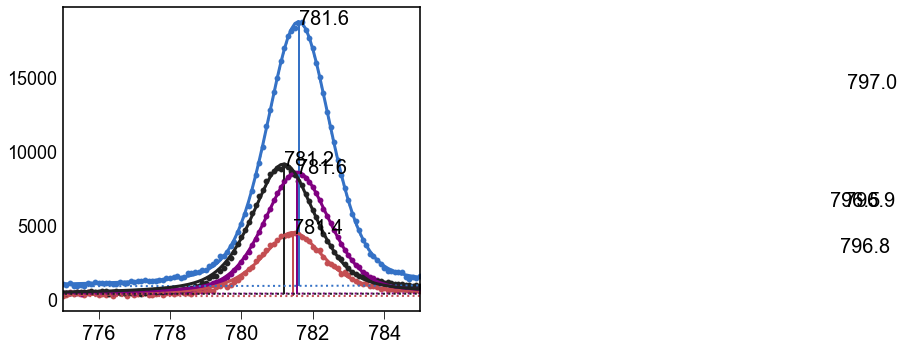

In [525]:
r = 'Ba_3d'
for xp in cubaproc[1:4]+[baclcu]:
    Fn = XPFit(xp, r)
    Fn.double_voigt()
    print(xp.name, xp.fit[r].best_values['v1_center'], xp.fit[r].best_values['v1_center'] - sep3d)
    Fn.plot()
plt.gca().set(xlim=(775, 785))

13-Cu_FBI_subl_60min_BaCl2_4min 781.3224578039593 796.6260684505163
13-Cu_FBI_subl_60min_BaCl2_8min 781.2882260645138 796.5918367110708
13-Cu_FBI_subl_60min_BaCl2_12min 781.223535885114 796.527146531671


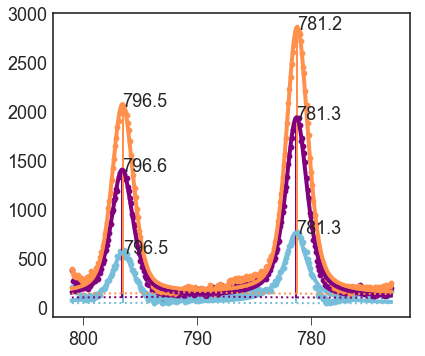

In [142]:
r = 'Ba_3d'
for xp in cubaproc2[1:4]:
    Fn = XPFit(xp, r)
    Fn.double_voigt()
    print(xp.name, xp.fit[r].best_values['v1_center'], xp.fit[r].best_values['v1_center'] - sep3d)
    Fn.plot()
    


13-Cu_FBI_subl_60min_BaCl2_4min 781.3224578039593 796.6260684505163
13-Cu_FBI_subl_60min_BaCl2_8min 781.2882260645138 796.5918367110708
13-Cu_FBI_subl_60min_BaCl2_12min 781.223535885114 796.527146531671


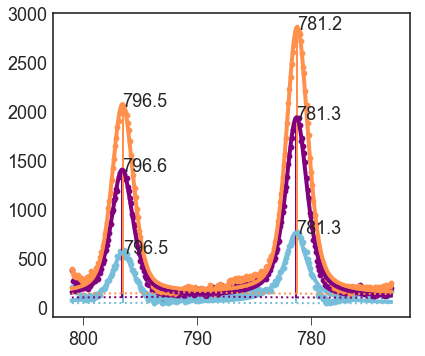

In [143]:
r = 'Ba_3d'
for xp in cubaproc2[1:4]:
    Fn = XPFit(xp, r)
    Fn.double_voigt()
    print(xp.name, xp.fit[r].best_values['v1_center'], xp.fit[r].best_values['v1_center'] - sep3d)
    Fn.plot()
    


13-Cu_FBI_subl_60min_BaCl2_4min 90.6063046608433 105.9099153074003
13-Cu_FBI_subl_60min_BaCl2_8min 90.73272906570452 106.03633971226151
13-Cu_FBI_subl_60min_BaCl2_12min 90.71640104490281 106.0200116914598


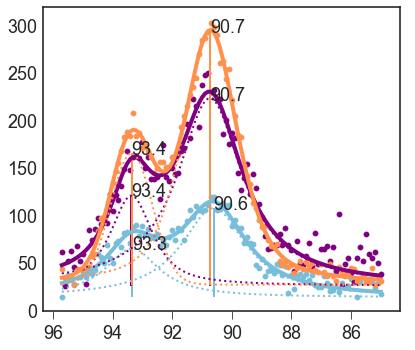

In [138]:
r = 'Ba_4d'
for xp in cubaproc2[1:4]:
    Fn = XPFit(xp, r)
    Fn.double_voigt(sepPt=91.2)
    print(xp.name, xp.fit[r].best_values['v1_center'], xp.fit[r].best_values['v1_center'] - sep3d)
    Fn.plot()

In [150]:
for xp in cubaproc2[1:4]:
    print(xp.fit['Ba_3d'].best_values['v1_center'] - xp.fit['Ba_4d'].best_values['v1_center'], 
          xp.fit['Ba_3d'].best_values['v2_center'] - xp.fit['Ba_4d'].best_values['v2_center'])
sep4d3 = xp.fit['Ba_3d'].best_values['v2_center'] - xp.fit['Ba_4d'].best_values['v2_center']
sep4d5 = xp.fit['Ba_3d'].best_values['v1_center'] - xp.fit['Ba_4d'].best_values['v1_center']

690.7161659193372 703.1854927609409
690.5557021977186 703.2162313039803
690.5071351638674 703.1857499189102


In [155]:
ba4d3 = np.array([92.8, 89.6, 90.4]) + sep4d3
ba4d5 = np.array([90.1, 87.0, 87.8]) + sep4d5
ba4d5

array([780.60713516, 777.50713516, 778.30713516])

In [158]:
ba4d5 - ba4d3, sep3d

(array([-15.37861476, -15.27861476, -15.27861476]), -15.30361064655699)

### Au (111)

In [528]:
path = '/Users/pabloherrero/sabat/xps_spectra/FBI_Cu/FBI_subl/2021_04_21*/**/*.uxy'
path = '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_21_Au111/**/*.uxy'


files = glob.glob(path, recursive=True)
files.sort()
files

aubaproc = [read_processed_xp(f) for f in files]
# aubaproc = [normalise_dfx(xp) for xp in aubaproc]

[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_21_Au111/proc/20210520_Au111_clean.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_21_Au111/proc/20210521_Au111_FBI_subl_45min.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_21_Au111/proc/20210521_Au111_FBI_subl_45min_BaCl2_10s.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_21_Au111/proc/20210522_Au111_FBI_subl_45min_BaCl2_20s.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_21_Au111/proc/20210523_Au111_FBI_subl_45min_BaCl2_30s.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_21_Au111/proc/20210523_Au

Au111_FBI_subl_45min_BaCl2_20s 780.9535112821534 796.2571219287104
Au111_FBI_subl_45min_BaCl2_30s 780.8334532377814 796.1370638843384
Au111_FBI_subl_45min_BaCl2_40s 780.9440868359391 796.247697482496
Au111_FBI_subl_45min_BaCl2_60s 780.8799742675936 796.1835849141506
Au111_FBI_subl_45min_BaCl2_80s 780.8423816329196 796.1459922794766


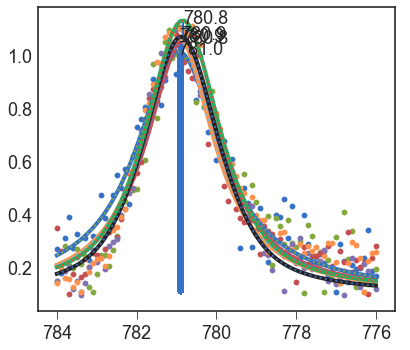

In [171]:
r = 'Ba_3d'
for xp in aubaproc[3:]:
    Fn = XPFit(xp, r)
    Fn.voigt()
    print(xp.name, xp.fit[r].best_values['v1_center'], xp.fit[r].best_values['v1_center'] - sep3d)
    Fn.plot()

Au111_FBI_subl_45min_BaCl2_80s 780.842381685772 796.145992332329
Au111_BaCl2_subl_320s 780.8491004094907 796.1527110560477


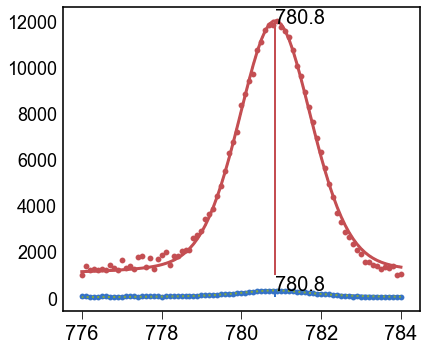

In [533]:
r = 'Ba_3d'
for xp in [aubaproc[7], baclau]:
    Fn = XPFit(xp, r)
    Fn.voigt()
    print(xp.name, xp.fit[r].best_values['v1_center'], xp.fit[r].best_values['v1_center'] - sep3d)
    Fn.plot()

[(20000.0, 88000.0), (910, 760)]

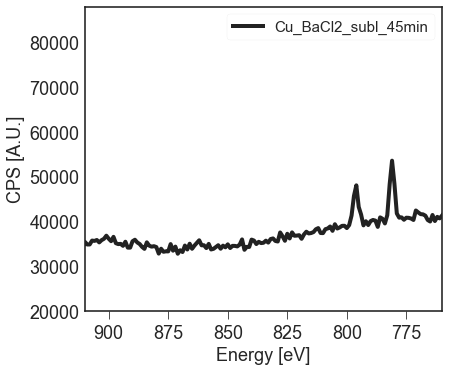

In [240]:
plot_region(baclcu, 'overview_')
plt.gca().set(xlim=(910, 760), ylim=(2e4, 8.8e4))

[(910, 760)]

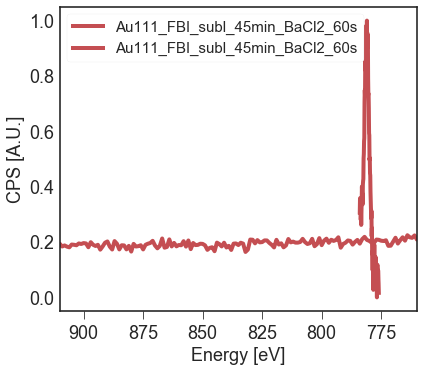

In [239]:
plot_region(raw3[-2], 'overview')
plot_region(raw3[-2], 'Ba_3d')

plt.gca().set(xlim=(910, 760))#, ylim=(2e4, 8.8e4))

[(910, 760)]

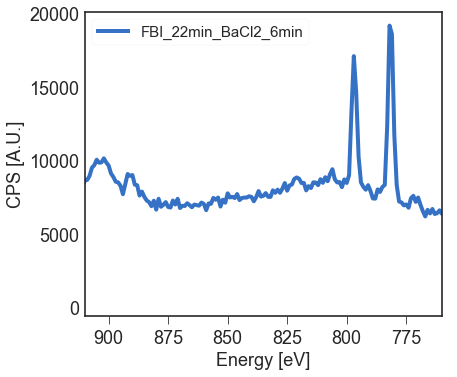

In [214]:
plot_region(cubaproc[3], 'overview_')
plt.gca().set(xlim=(910, 760))#, ylim=(2e4, 8.8e4))

[(920, 876)]

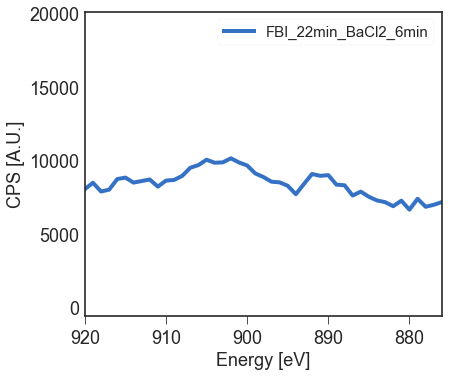

In [219]:
plot_region(cubaproc[3], 'overview_')
plt.gca().set(xlim=(920, 876))#, ylim=(2e4, 8.8e4))

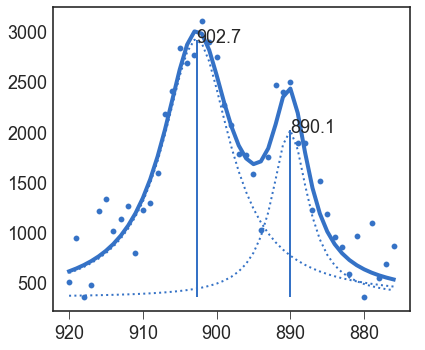

In [246]:
r = 'overview_'
xpc = crop_spectrum(cubaproc[3], 'overview_', eup=920, edw=876)
xpc = subtract_shirley_bg(xpc, r, )
plt.clf()
# plot_region(xpc, r)
Fn = XPFit(xpc, r)
Fn.double_voigt(sepPt=895)
Fn.plot()

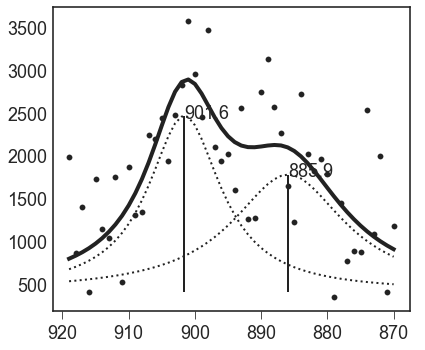

In [248]:
r = 'overview_'
xpc = crop_spectrum(baclcu, 'overview_', eup=919, edw=870)
xpc = subtract_shirley_bg(xpc, r, )
plt.clf()
# plot_region(xpc, r)
Fn = XPFit(xpc, r)
Fn.double_voigt(sepPt=895)
Fn.plot()

#### Auger parameter for BaCl2
SURFACE AND INTERFACE ANALYSIS, VOL. 17, 6354dO (1991)

##### $\alpha = KE(AES) - KE(PE) $

In [258]:
123.64

123.64

##### $\alpha = KE(AES) + BE(PE) $

In [259]:
592 + 786

1378

#### What we measure

##### $\alpha = KE(AES) - KE(PE) $

In [534]:
233 - (890 - 781)

124

In [535]:
233 - (886 - 781)

128

##### $\alpha = KE(AES) + BE(PE) $

In [257]:
1486 - 890 + 781

1377

In [255]:
1486 - 886 + 781

1381

#### Auger parameter for Ba metal

Journal of Electron Spectroscopy and Related Phenomena, 56 (1991) 217-240

In [251]:
(1486 - 596.5) - 780.4 

109.10000000000002

In [252]:
780.4 + 596.5

1376.9

## BaCl2 powder

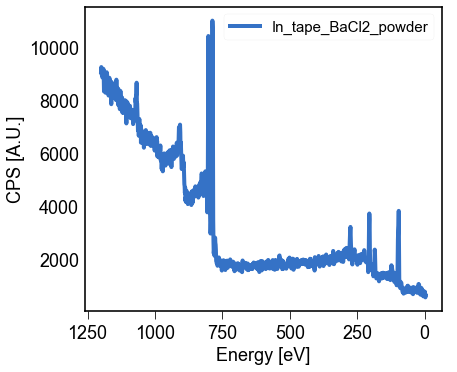

In [57]:
path = '/Users/pabloherrero/sabat/xps_spectra/BaCl2_powder/20210629_In_tape_BaCl2_powder.xy'
bapowder = xps_data_import(path)
plot_region(bapowder, 'overview')

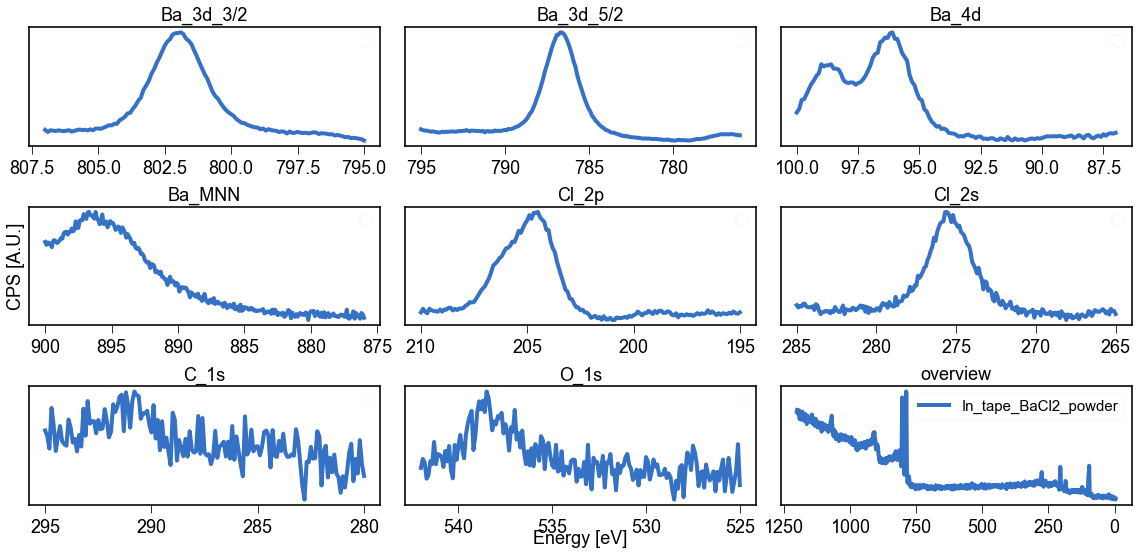

In [58]:
regs = ['Ba_3d_3/2', 'Ba_3d_5/2', 'Ba_4d', 'Ba_MNN', 'Cl_2p', 'Cl_2s', 'C_1s', 'O_1s']
plot_xp_regions([bapowder], regs+['overview']);

### Subtract bg

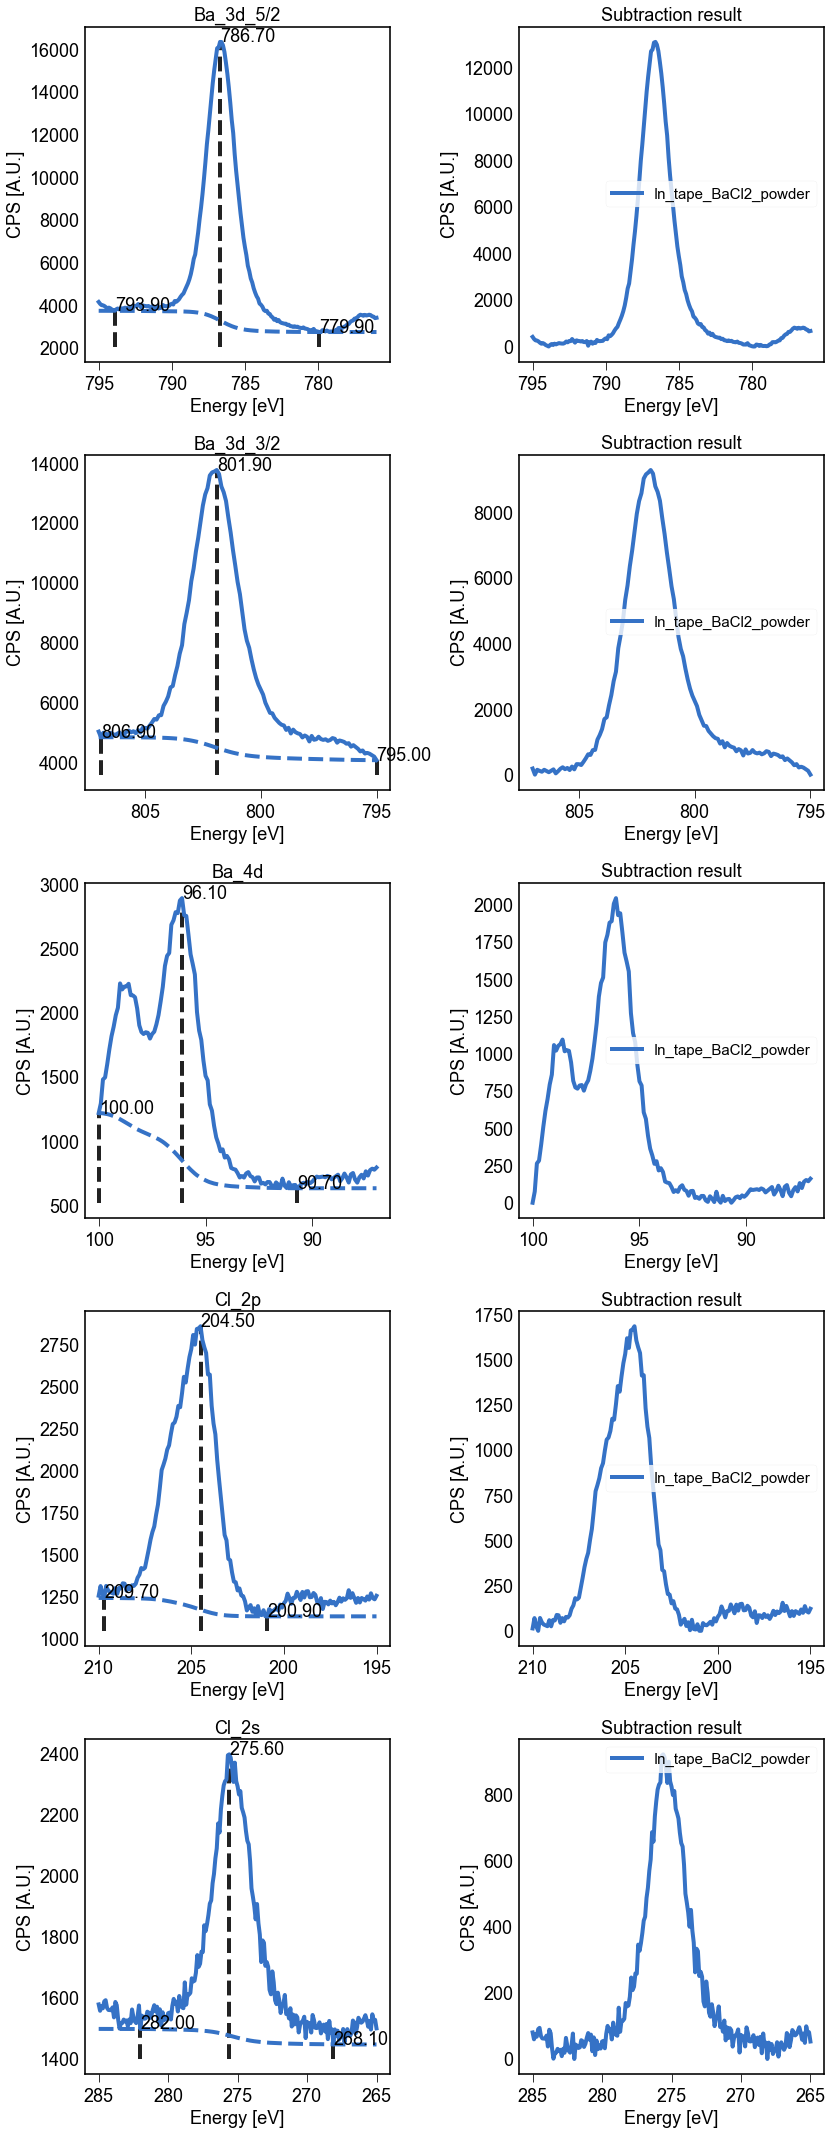

In [83]:
regs = ['Ba_3d_5/2', 'Ba_3d_3/2', 'Ba_4d', 'Cl_2p', 'Cl_2s']
bgpowder = bulk_bg_subtract([bapowder], regs)

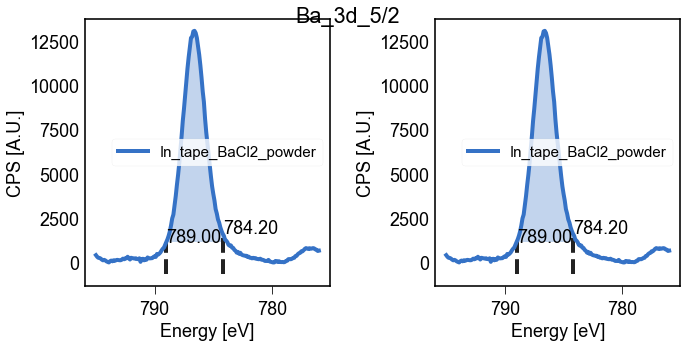

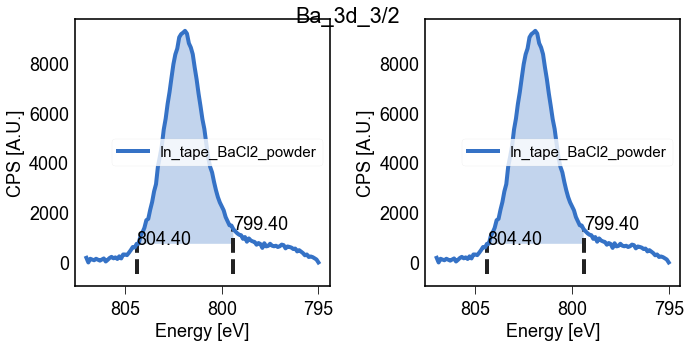

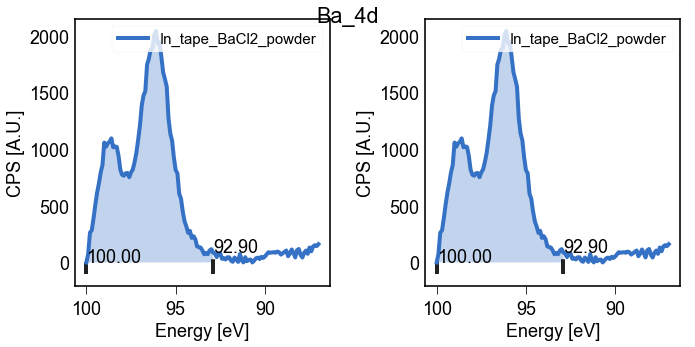

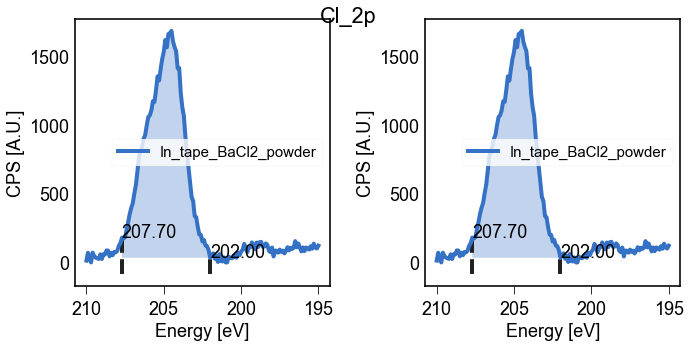

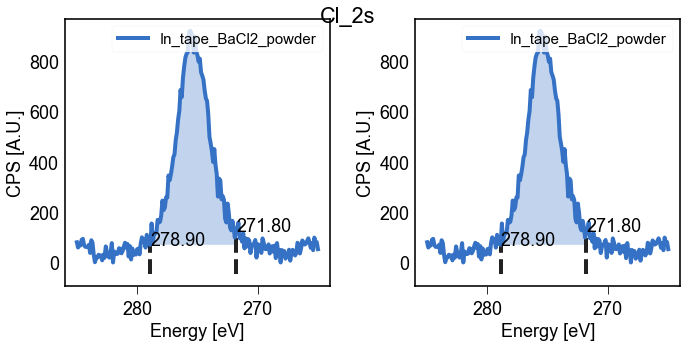

In [84]:
bgpowder[0].area={}
regs = ['Ba_3d_5/2', 'Ba_3d_3/2', 'Ba_4d', 'Cl_2p', 'Cl_2s']
eups = [789.0, 804.4, 100.2, 207.7, 278.9]
edws = [784.2, 799.4, 92.9, 202, 271.8]

for i,r in enumerate(regs):
    integrateRegions([bgpowder[0], bgpowder[0]], r, asf=asf, eup=eups[i], edw=edws[i])

In [74]:
asf2 = {'Ba_3d_5/2' : 25.8, 'Ba_3d_3/2': 17.9, 'Ba_4d': 5.86, 'Cl_2p': 2.28, 'Cl_2s': 1.69}

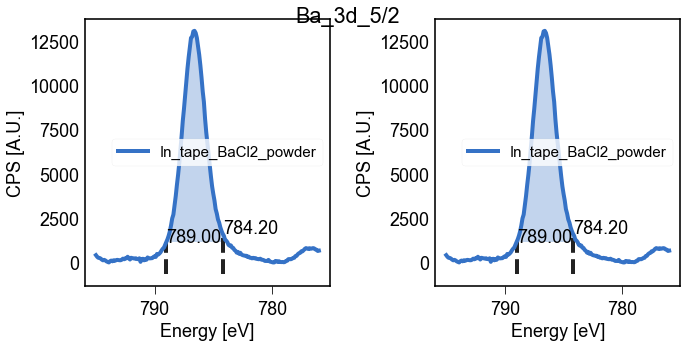

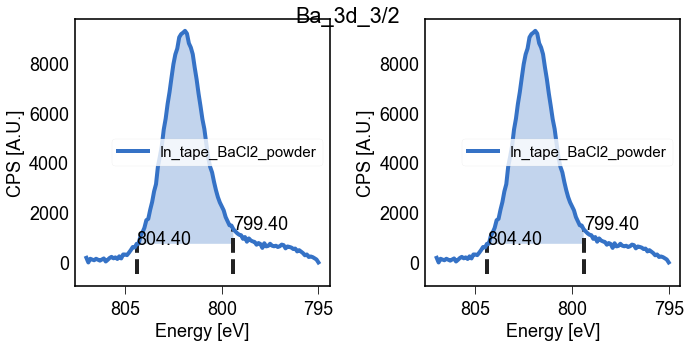

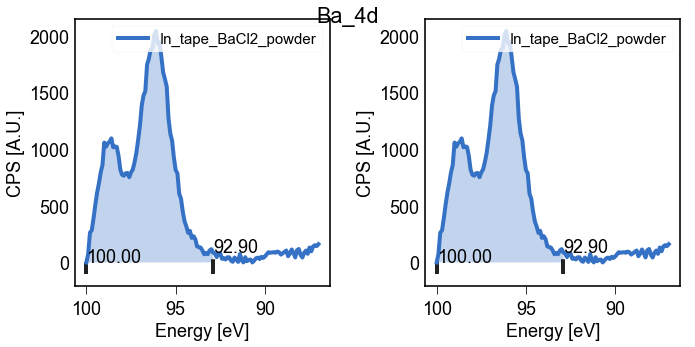

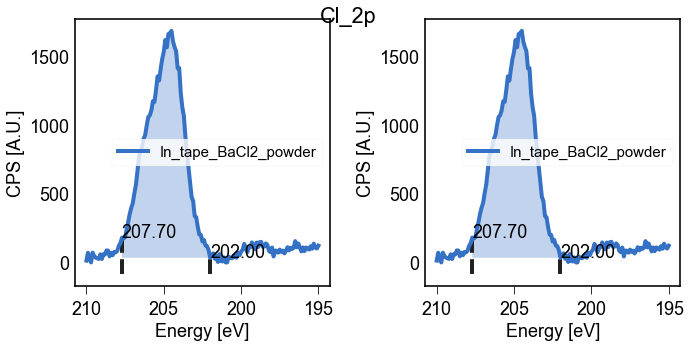

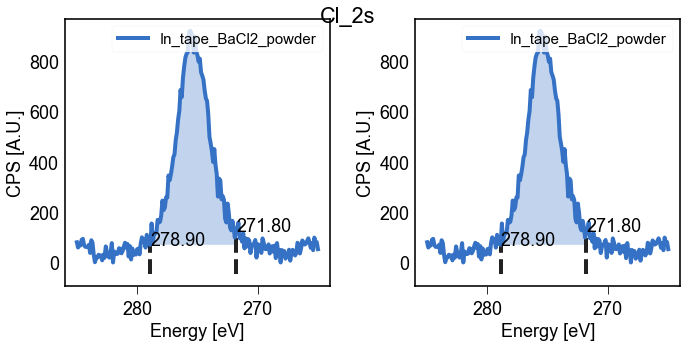

In [89]:
bgpowder[0].area={}
regs = ['Ba_3d_5/2', 'Ba_3d_3/2', 'Ba_4d', 'Cl_2p', 'Cl_2s']
eups = [789.0, 804.4, 100.2, 207.7, 278.9]
edws = [784.2, 799.4, 92.9, 202, 271.8]

for i,r in enumerate(regs):
    integrateRegions([bgpowder[0], bgpowder[0]], r, asf=asf2, eup=eups[i], edw=edws[i])

### Limits from fit 2$\sigma$

In [ ]:
def integrateRegions(exps: list, region : str,  asf: dict, indRef: int= None,
                     eup: float = None, edw: float = None,
                     lb : str = None, flag_fill : bool = True):
    """Integrate peaks for a list of experiments between two minima
       The minima are automatically located for exps[indRef] unless they are specified by eup and edw
    The boundary are fixed for the whole list."""

    if indRef == None: indRef = guess_xpRef(exps, region)

    xRef = exps[indRef].dfx[region].dropna().energy     # Use the energy array of reference xp to crop the other xp's

    if eup == None or edw == None:
        ind = flexible_integration_limits(exps[indRef], region=region, doublePeak=0, flag_plot=False)
        lmidx, rmidx = ind[-2:] # The index of the minima are always the last two
        eup, edw = xRef[lmidx], xRef[rmidx]

    fig, ax = plt.subplots(1, len(exps), figsize=(len(exps)*5, 5) )
    area = []
    for i, xp in enumerate(exps):
        try:
            y = xp.dfx[region].dropna().counts
        except KeyError as e:          #Check the region exists in this xp
            print(e, 'region does not exist in ' + xp.name)
            xp.area.update({region: 1e-10})
            continue

        x = xp.dfx[region].dropna().energy
        ax[i].plot(x, y, label=xp.name)

        xpCrop = crop_spectrum(xp, region, eup = eup, edw = edw)
        yc = xpCrop.dfx[region].dropna().counts.values
        xc = xpCrop.dfx[region].dropna().energy.values    # Integrate only in the cropped range

        step = x[0] - x[1]
        area.append(np.trapz(yc, dx=step))

        try:
            xp.area.update({region : area[-1]/asf[region]})
        except (KeyError, NameError) as e:
            print(e, ', asf missing, returning raw area')
            pass

        #### Plotting the operation

        if flag_fill:
            if yc[0] > yc[-1]:
                ax[i].fill_between(xc , y1 = yc[-1], y2 = yc, alpha=0.3)
            else:
                ax[i].fill_between(xc, y1 = yc[0], y2 = yc, alpha=0.3)
            ybase = ax[i].get_ylim()[0]

            for j in [0, -1]:
                ax[i].vlines(xc[j], ymin=ybase, ymax=yc[j], linestyles='--')
                ax[i].text(s='%.2f'%xc[j], x = xc[j], y = yc[j])
        cosmetics_plot(ax=ax[i])
    plt.tight_layout()
    fig.suptitle(region)
    return area

(271.78338194249625, 278.8828248927839)

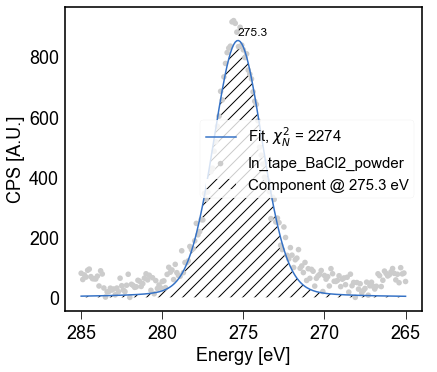

In [831]:
xp = bgpowder[0]
region = 'Cl_2s'
x = xp.dfx[region].dropna().energy
y = xp.dfx[region].dropna().counts

fitv = fit_voigt(xp, region)

fitv.best_values['v_center'] - 2*fitv.best_values['v_sigma'], fitv.best_values['v_center'] + 2*fitv.best_values['v_sigma']

In [564]:
#bgpowder[0].area['Ba_3d_5/2'] *= (1 + 2/3) 

## Stoichiometry

In [85]:
bgpowder[0].area['Cl_2p'] / bgpowder[0].area['Ba_3d_5/2']# + bgpowder[0].area['Ba_3d_3/2'])

1.241766469551856

In [86]:
bgpowder[0].area['Cl_2s'] / bgpowder[0].area['Ba_3d_5/2'] #+ bgpowder[0].area['Ba_3d_3/2'])

1.982769825450282

In [87]:
num = ['Cl_2p', 'Cl_2s', 'Cl_2p']
denom = ['Ba_4d', 'Ba_4d', 'Cl_2s']
make_stoichometry_table([bgpowder[0]], num=num, denom=denom)

Experiment	Cl_/Ba_	Cl_/Ba_	Cl_/Cl_	
In_tape_BaCl2_powder	2.08 	 3.32 	 0.63 	 


In [88]:
bgpowder[0].area['Ba_4d'] / bgpowder[0].area['Ba_3d_5/2']# + bgpowder[0].area['Ba_3d_3/2'])

0.5972442864016588

### With ASF2

In [90]:
bgpowder[0].area['Cl_2p'] / bgpowder[0].area['Ba_3d_5/2']# + bgpowder[0].area['Ba_3d_3/2'])

1.6715550118733842

In [91]:
bgpowder[0].area['Cl_2s'] / bgpowder[0].area['Ba_3d_5/2']# + bgpowder[0].area['Ba_3d_3/2'])

1.4952892419674668

In [92]:
num = ['Cl_2p', 'Cl_2s', 'Cl_2p']
denom = ['Ba_4d', 'Ba_4d', 'Cl_2s']
make_stoichometry_table([bgpowder[0]], num=num, denom=denom)

Experiment	Cl_/Ba_	Cl_/Ba_	Cl_/Cl_	
In_tape_BaCl2_powder	2.03 	 1.81 	 1.12 	 


In [93]:
bgpowder[0].area['Ba_4d'] / bgpowder[0].area['Ba_3d_5/2'] #+ bgpowder[0].area['Ba_3d_3/2'])

0.8250117582153353

## Conclusions

- All areas are integrated in a 4-sigma interval, so the discrepancy in stoichiometry cannot come from there.

- All ASF2 values (Scofield) yield stoichiometries that agree better with expectation than Wagner's ASF.

- The ASF2 values are:
    - Overestimated for Cl 2s by a factor 1.12. The correct value is 1.50
    - Underestimated for Ba 3d 5/2 by a factor 2.5. The correct value is 64.3
    - Underestimated for Ba 3d 3/2 by a factor 2.8. The correct value is 49.9
    
- UPDATE (after talk with Celia): The ASF values are correct, but if one uses asf[Ba 3d 5/2], then only Ba 3d 5/2 peak should be integrated, NOT BOTH.

The source of error was summing both areas

In [858]:
asf3 = {'Ba_3d_5/2' : 64.3, 'Ba_3d_3/2': 49.9, 'Ba_4d': 5.86, 'Cl_2p': 2.28, 'Cl_2s': 1.50}

## Simulation BaCl2 on powder In

In [972]:
path = '/Users/pabloherrero/sabat/xps_spectra/BaCl2_powder/BaCl2_bulk.dat'
df = pd.read_csv(path, skiprows=10, sep='\t', names=['energy', 'counts', 'no'])
df = df.drop('no', axis=1)
df.energy = 1486.6 - df.energy
df.counts /= df.counts.max()
# df.set_index('energy', drop=True, inplace=True)
mi = pd.MultiIndex.from_product([['overview'], np.array(['energy', 'counts'])])
mi.to_frame()
df.columns = mi

xpsim = XPS_experiment(path = path, name='BaCl2_simulation', dfx=df, area={}, fit={})

In [5]:
def import_simulation_file(path: str, ke: bool = False) -> XPS_experiment:
    """Import SESSA .dat simulation data. If ke flag is True: convert KE to BE
        Return XPS_experiment with dfx containing only overview region"""
    filename = os.path.split(path)[1]
    name = os.path.splitext(filename)[0]
    
    df = pd.read_csv(path, skiprows=10, sep='\t', names=['energy', 'counts', 'no'])
    df = df.drop('no', axis=1)
    if ke:
        df.energy = 1486.6 - df.energy
    df.counts /= df.counts.max() # Normalization to 1
    # df.set_index('energy', drop=True, inplace=True)
    mi = pd.MultiIndex.from_product([['overview'], np.array(['energy', 'counts'])])
    mi.to_frame()
    df.columns = mi

    xpsim = XPS_experiment(path = path, name=name, dfx=df, area={}, fit={})
    return xpsim

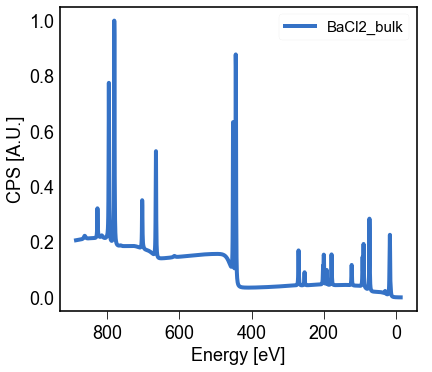

In [6]:
path = '/Users/pabloherrero/sabat/xps_spectra/BaCl2_powder/BaCl2_bulk.dat'
xpsim = import_simulation_file(path, ke=True)
plot_region(xpsim, 'overview')

### Splice dfx in ROIs

In [973]:
regs = ['Ba_3d_5/2', 'Ba_3d_3/2', 'Ba_4d', 'Cl_2p', 'Cl_2s']
eups = [800, 787, 97, 210, 280]
edws = [787, 775, 85, 195, 260]
for i, r in enumerate(regs):
    xpc = crop_spectrum(xpsim, 'overview', eup=eups[i], edw=edws[i])
    xpc.dfx.rename(columns={'overview':r}, inplace=True)
    insert_dfx_region(xpsim, xpc, r, inplace=True)
xpsim.dfx

Ba_3d_3/2           Ba_3d_5/2             Ba_4d              Cl_2p  \
        energy    counts    energy    counts  energy    counts   energy   
0     786.8441  0.204922  799.5883  0.229650  96.903  0.043026  209.842   
1     786.4047  0.205696  799.1488  0.233532  96.463  0.043658  209.403   
2     785.9652  0.206911  798.7094  0.239486  96.024  0.044576  208.963   
3     785.5258  0.208701  798.2699  0.249041  95.584  0.045938  208.524   
4     785.0863  0.211274  797.8305  0.265089  95.145  0.048032  208.084   
...        ...       ...       ...       ...     ...       ...      ...   
2043       NaN       NaN       NaN       NaN     NaN       NaN      NaN   
2044       NaN       NaN       NaN       NaN     NaN       NaN      NaN   
2045       NaN       NaN       NaN       NaN     NaN       NaN      NaN   
2046       NaN       NaN       NaN       NaN     NaN       NaN      NaN   
2047       NaN       NaN       NaN       NaN     NaN       NaN      NaN   

                overview              Cl_2s            
        counts    energy    counts   energy    counts  
0     0.046793  886.6000  0.206537  279.715  0.043394  
1     0.046865  886.1605  0.206634  279.276  0.043449  
2     0.046953  885.7211  0.206731  278.836  0.043514  
3     0.047064  885.2816  0.206827  278.397  0.043590  
4     0.047203  884.8422  0.206923  277.957  0.043680  
...        ...       ...       ...      ...       ...  
2043       NaN  -11.2030  0.000237      NaN       NaN  
2044       NaN  -11.6420  0.000231      NaN       NaN  
2045       NaN  -12.0820  0.000225      NaN       NaN  
2046       NaN  -12.5210  0.000219      NaN       NaN  
2047       NaN  -12.9610  0.000213      NaN       NaN  

[2048 rows x 12 columns]

In [7]:
def splice_dfx(xp: XPS_experiment, region: str, eup: float, edw: float) -> XPS_experiment:
    """Select a region of the spectrum overview and insert it in the dfx"""
    try:
        xpc = crop_spectrum(xp, 'overview', eup=eup, edw=edw)
        xpc.dfx.rename(columns={'overview':region}, inplace=True)
        
    except KeyError:
        xpc = crop_spectrum(xp, 'overview_', eup=eup, edw=edw)
        xpc.dfx.rename(columns={'overview_':region}, inplace=True)
        
    insert_dfx_region(xp, xpc, region, inplace=True)
    return xp

In [990]:
asf4 = {'Ba_3d_5/2': 25.8, 'Ba_3d_3/2': 17.9,
 'Ba_4d': 8.13, 'Cl_2p': 3.08, 'Cl_2s': 1.28}

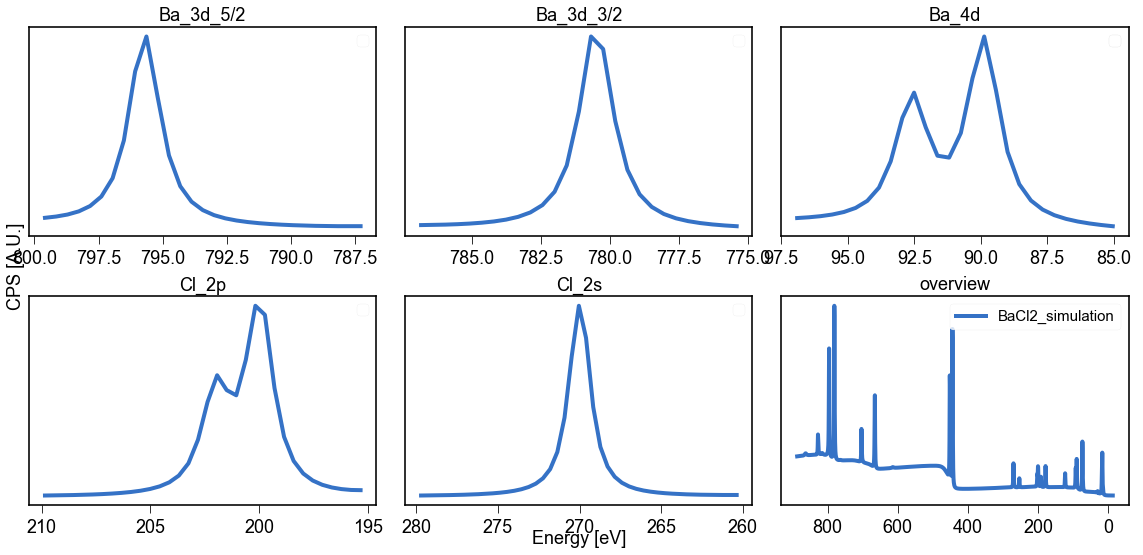

In [974]:
plot_xp_regions([xpsim], regs+['overview']);

### Bg subtraction and scale

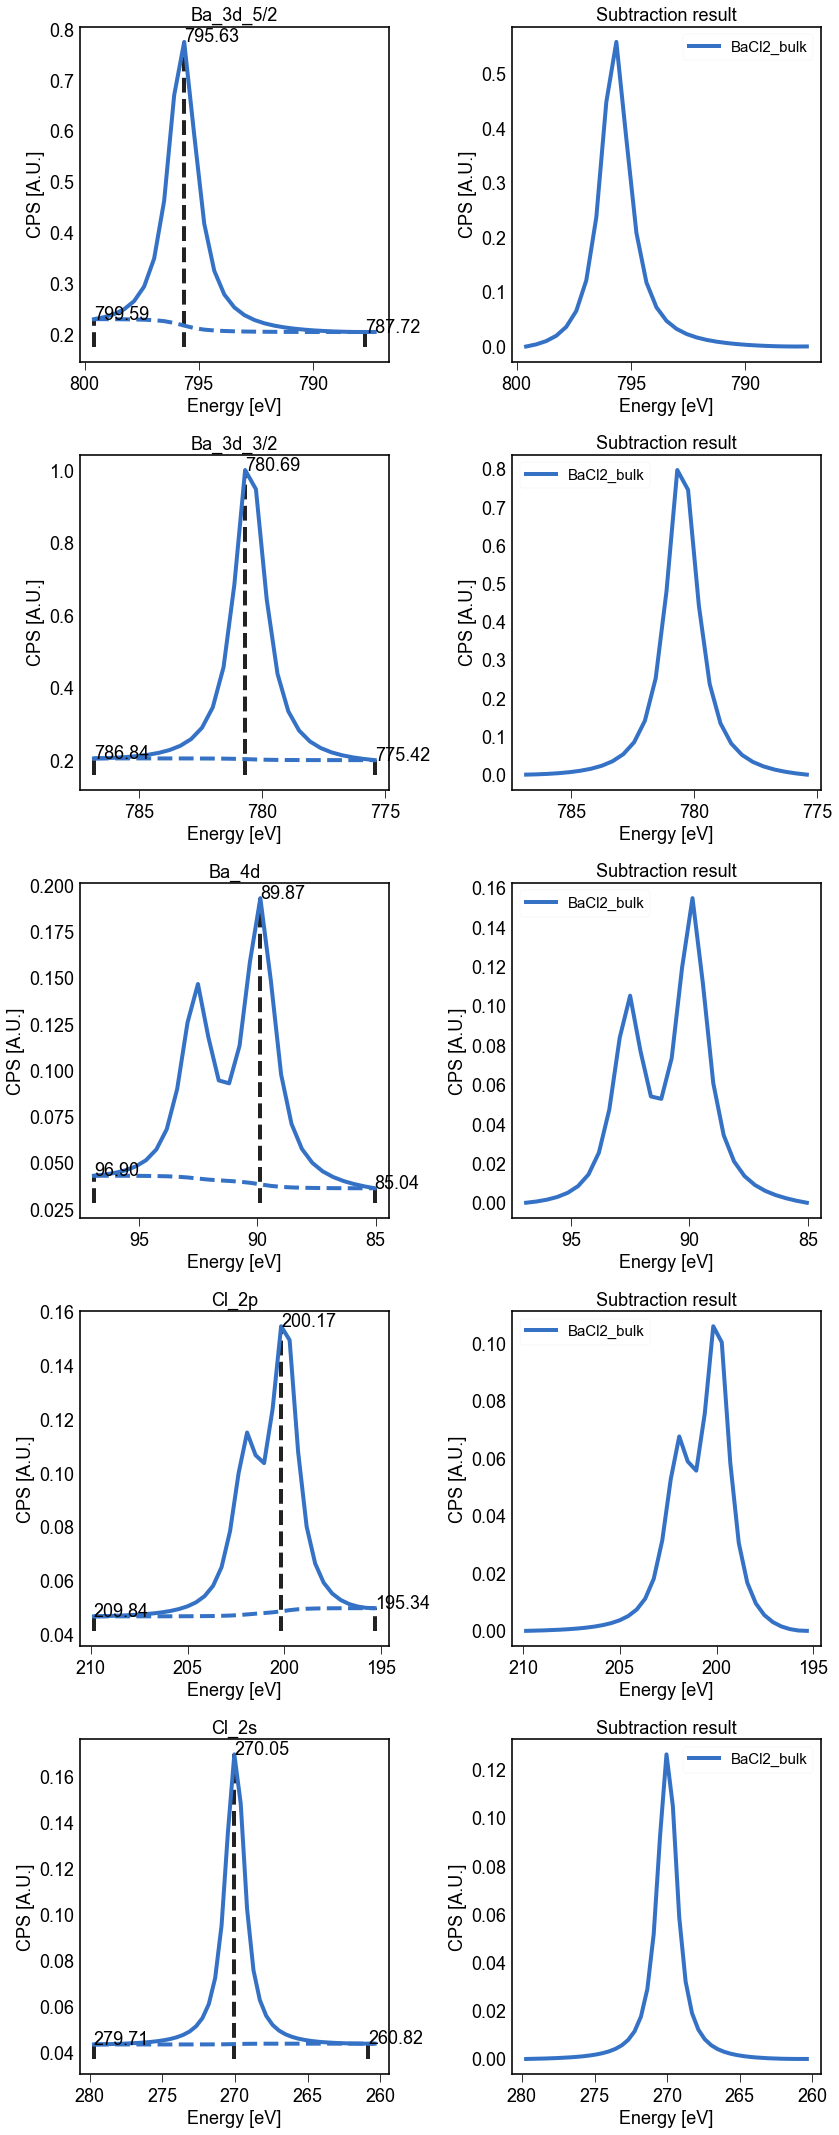

In [9]:
[bgsim] = bulk_bg_subtract([xpsim], regs)

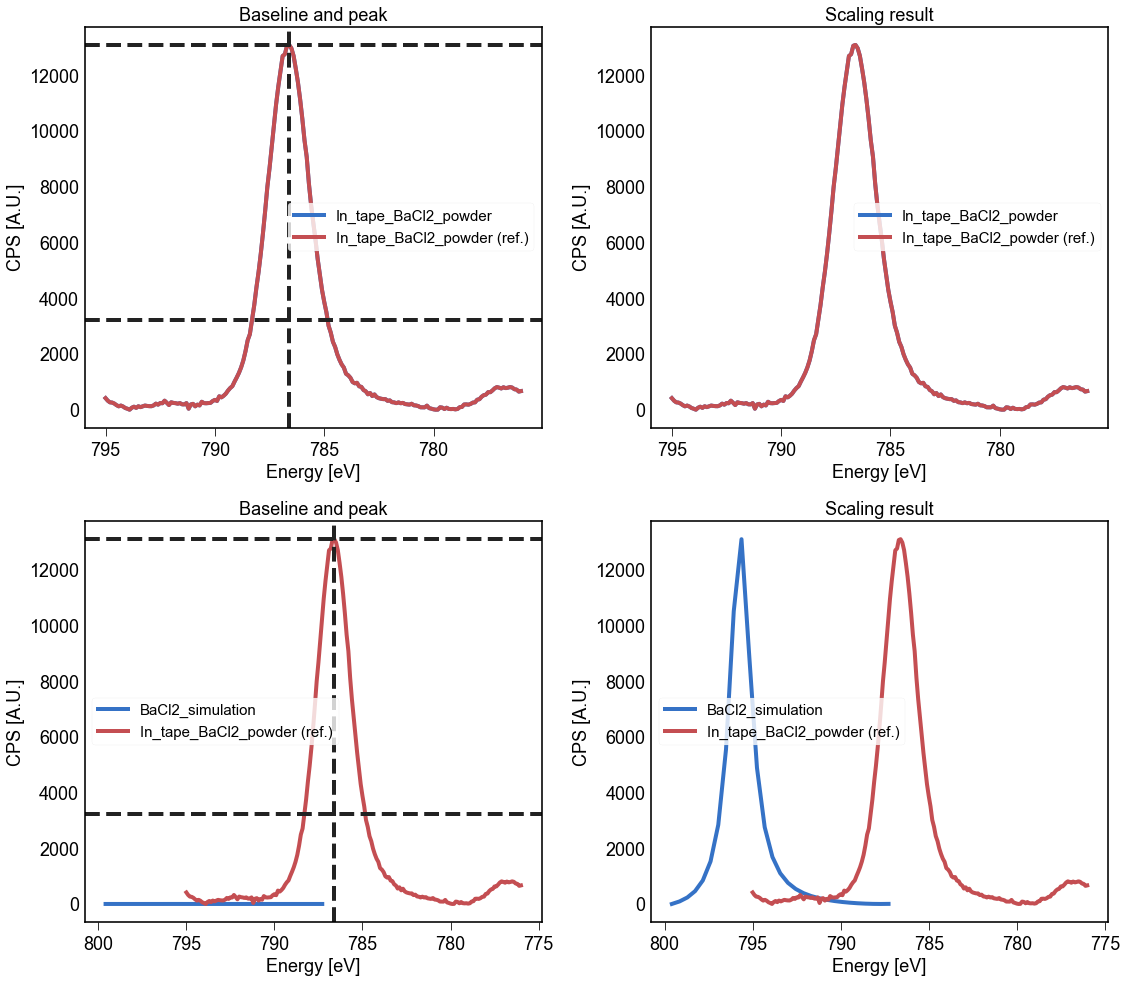

In [965]:
scaled = scale_and_plot_spectra([bgpowder[0], bgsim], indRef=0, region='Ba_3d_5/2')

In [969]:
shift = find_shift(scaled[0], scaled[1], region='Cl_2p')
align_dfx(scaled[0], shift=shift, inplace=True);

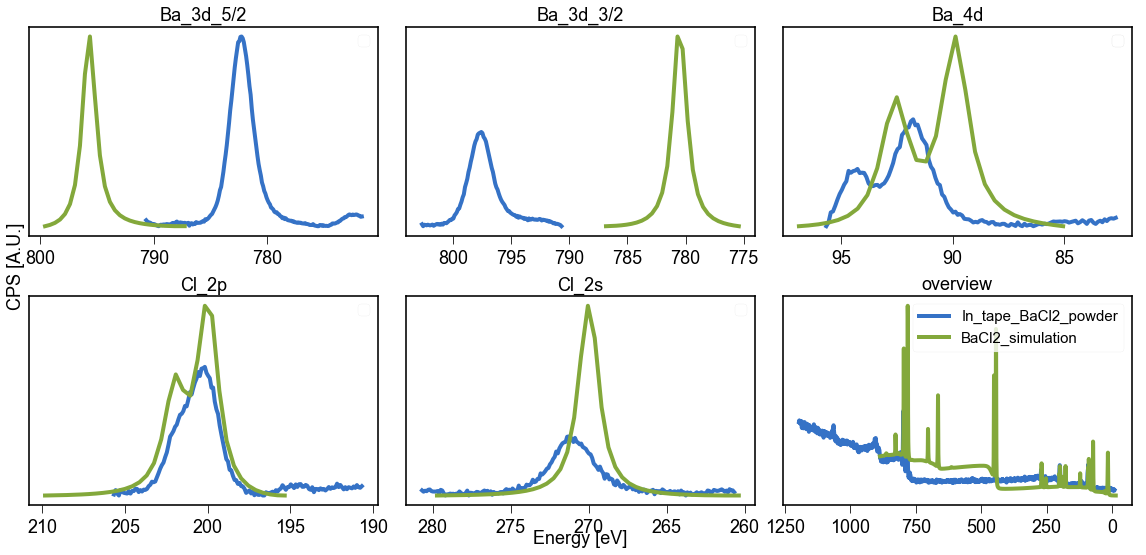

In [970]:
plot_xp_regions(scaled, regs+['overview']);

### Area fitting and integration

In [38]:
xp = bgsim
nsigma = 6
# fig, ax = plt.subplots(1, len(regs), figsize=(18, 6))
r = 'Ba_4d'
def integratePeak(xp: XPS_experiment, region: str, asf: dict, nsigma: int = 4, 
                  fitm: str = ['v', 'dv'], sepPt: float = None, flag_fill: bool = True):
    Fn = XPFit(xp, region)
    if fitm == 'dv':
        fitv = Fn.double_voigt(sepPt)
        edw = fitv.best_values['v1_center'] - nsigma*fitv.best_values['v1_sigma']
        eup = fitv.best_values['v2_center'] + nsigma*fitv.best_values['v2_sigma']

    else:
        fitv = Fn.voigt()        
        edw = fitv.best_values['v1_center'] - nsigma*fitv.best_values['v1_sigma']
        eup = fitv.best_values['v1_center'] + nsigma*fitv.best_values['v1_sigma']
        
    Fn.plot()
    ax = plt.gca()
    xpCrop = crop_spectrum(xp, region, eup = eup, edw = edw, )
    yc = xpCrop.dfx[region].dropna().counts.values
    xc = xpCrop.dfx[region].dropna().energy.values    # Integrate only in the cropped range

    area = np.trapz(yc, dx= xc[0] - xc[1])

    try:
        xp.area.update({region : area/asf[region]})
    except (KeyError, NameError) as e:
        print(e, ', asf missing, storing raw area')
        xp.area.update({region : area})        

    #### Plotting the operation

    if flag_fill:
        if yc[0] > yc[-1]:
            ax.fill_between(xc , y1 = yc[-1], y2 = yc, color='b', alpha=0.3)
        else:
            ax.fill_between(xc, y1 = yc[0], y2 = yc, color='b', alpha=0.3)
        ybase = ax.get_ylim()[0]
        for j in [0, -1]:
            ax.vlines(xc[j], ymin=ybase, ymax=yc[j], linestyles='--')
            ax.text(s='%.2f'%xc[j], x = xc[j], y = yc[j])

In [50]:
regs = ['Ba_4d', 'Ba_3d_5/2', 'Ba_3d_3/2', 'Cl_2p', 'Cl_2s']

In [52]:
asf = dict({'C_1s' : 0.296, 'O_1s' : 0.711, 'N_1s' : 0.477, 'Ba_3d' : 7.49, 'Ba_3d_5/2' : 7.49, 'Ba_3d_3/2' : 7.49,
            'Br_3p' : 1.054, 'Cu_2p' : 5.321, 'Ba_4d': 2.35, 'Na_1s' : 1.685, 'Cl_2s' : 0.37,
           'In3d' : 4.359, 'Sn3d' : 4.725, 'Cl_2p' : 0.891, 'Si2p': 0.339})

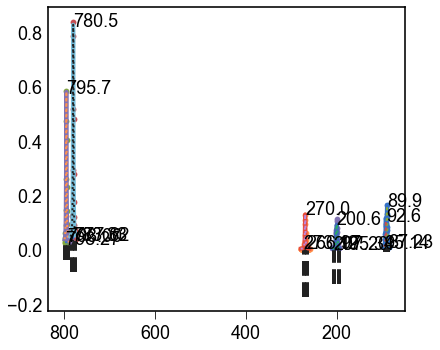

In [53]:
integratePeak(bgsim, r, asf=asf, fitm='dv', sepPt=91)
for r in regs[1:]:
    integratePeak(bgsim, r, asf=asf, fitm='v')
    

In [54]:
bgsim.area['Ba_3d_5/2'] / bgsim.area['Ba_3d_3/2']

0.6555141424067613

In [55]:
bgsim.area['Cl_2p'] / bgsim.area['Ba_3d_5/2']

2.6374699889291935

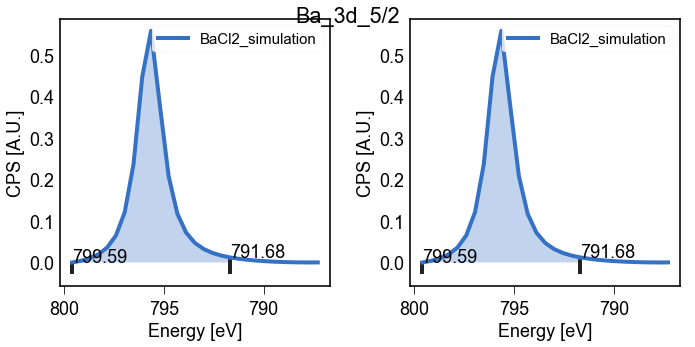

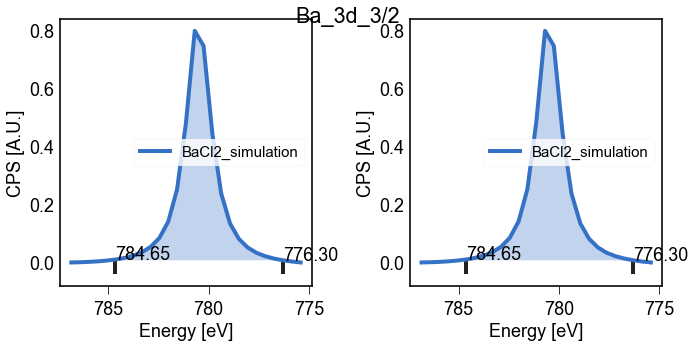

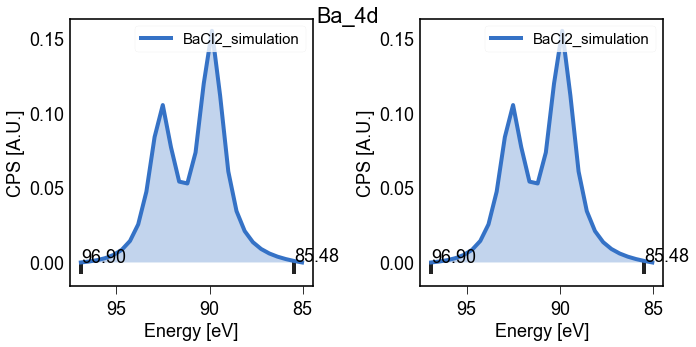

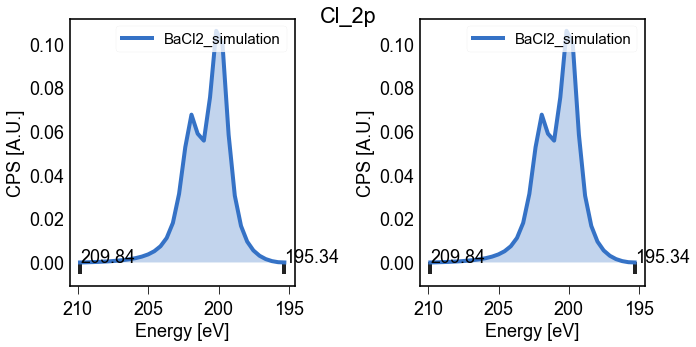

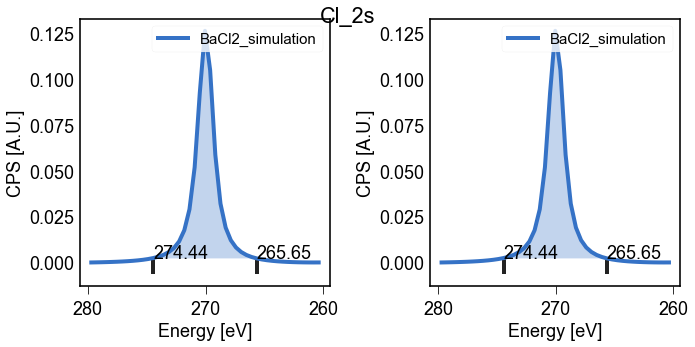

In [1011]:
xp = bgsim
nsigma = 6
for r in regs:
#     region = 'Cl_2s'
    Fn = XPFit(xp, r)
    if r == 'Ba_4d':
        fitv = Fn.double_voigt(91)
        edw = fitv.best_values['v1_center'] - nsigma*fitv.best_values['v1_sigma']
        eup = fitv.best_values['v2_center'] + nsigma*fitv.best_values['v2_sigma']
    else:
        fitv = Fn.voigt()
#     Fn.plot(ax=plt.gca())

        edw = fitv.best_values['v1_center'] - nsigma*fitv.best_values['v1_sigma']
        eup = fitv.best_values['v1_center'] + nsigma*fitv.best_values['v1_sigma']

    integrateRegions([xp, xp], r, asf=asf3, eup=eup, edw=edw, )

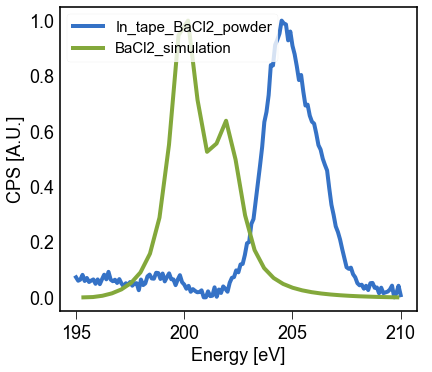

In [930]:
plot_region(normalise_dfx(bgpowder[0]), 'Cl_2p')
plot_region(normalise_dfx(xp), 'Cl_2p')

### Stoichiometry

#### ASF 3

In [1012]:
bgsim.area['Cl_2p'] / (bgsim.area['Ba_3d_5/2'] + bgsim.area['Ba_3d_3/2'])

2.8920888404711547

In [932]:
bgsim.area['Cl_2s'] / (bgsim.area['Ba_3d_5/2'] + bgsim.area['Ba_3d_3/2'])

3.6152035246999494

In [1013]:
num = ['Cl_2p', 'Cl_2s', 'Cl_2s']
denom = ['Ba_4d', 'Ba_4d', 'Cl_2p']
make_stoichometry_table([bgsim], num=num, denom=denom)

Experiment	Cl_/Ba_	Cl_/Ba_	Cl_/Cl_	
BaCl2_simulation	1.72 	 2.15 	 1.25 	 


In [1014]:
bgsim.area['Ba_4d'] / (bgsim.area['Ba_3d_5/2'] + bgsim.area['Ba_3d_3/2'])

1.684617301427095

#### ASF2

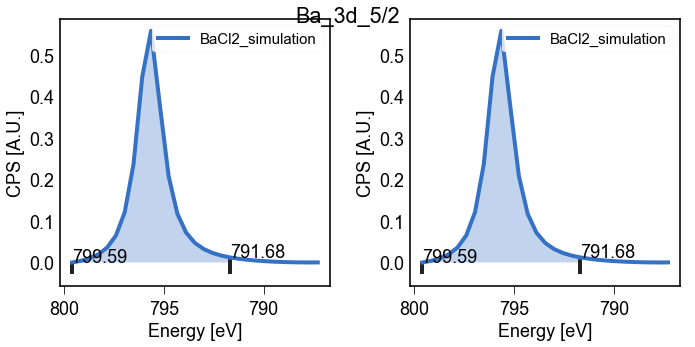

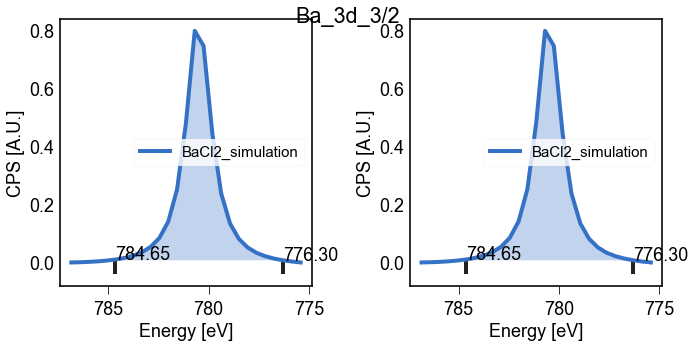

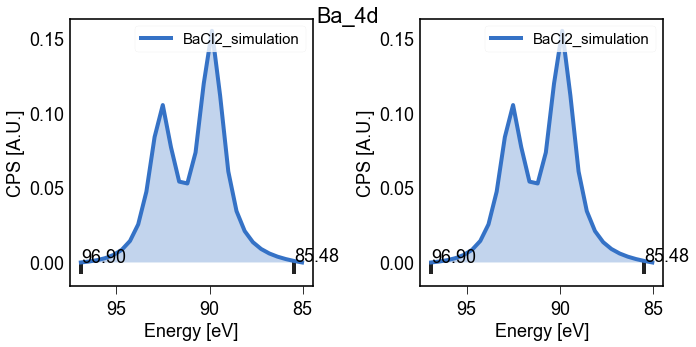

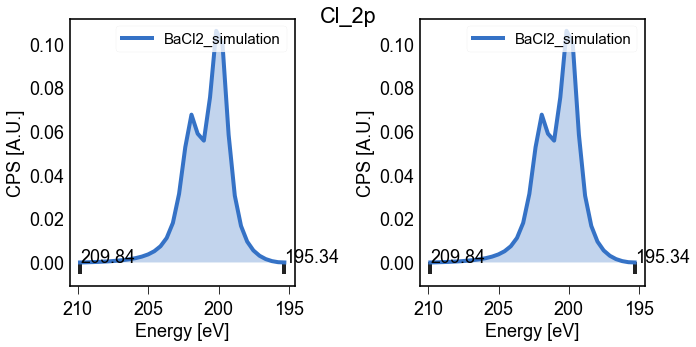

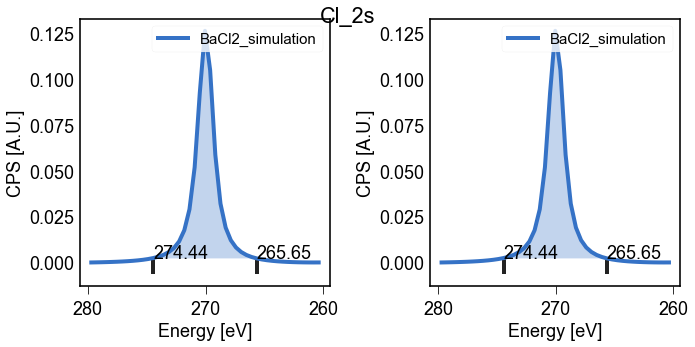

In [943]:
xp = bgsim
nsigma = 6
for r in regs:
#     region = 'Cl_2s'
    Fn = XPFit(xp, r)
    if r == 'Ba_4d':
        fitv = Fn.double_voigt(91)
        edw = fitv.best_values['v1_center'] - nsigma*fitv.best_values['v1_sigma']
        eup = fitv.best_values['v2_center'] + nsigma*fitv.best_values['v2_sigma']
    else:
        fitv = Fn.voigt()
#     Fn.plot(ax=plt.gca())

        edw = fitv.best_values['v1_center'] - nsigma*fitv.best_values['v1_sigma']
        eup = fitv.best_values['v1_center'] + nsigma*fitv.best_values['v1_sigma']

    integrateRegions([xp, xp], r, asf=asf2, eup=eup, edw=edw, )

In [935]:
bgsim.area['Cl_2p'] / (bgsim.area['Ba_3d_5/2'] + bgsim.area['Ba_3d_3/2'])

1.0760026794682946

In [936]:
bgsim.area['Cl_2s'] / (bgsim.area['Ba_3d_5/2'] + bgsim.area['Ba_3d_3/2'])

1.1938204920365558

In [944]:
num = ['Cl_2p', 'Cl_2s', 'Cl_2p']
denom = ['Ba_4d', 'Ba_4d', 'Cl_2s']
make_stoichometry_table([bgsim], num=num, denom=denom)

Experiment	Cl_/Ba_	Cl_/Ba_	Cl_/Cl_	
BaCl2_simulation	1.72 	 1.90 	 0.90 	 


In [945]:
bgsim.area['Ba_4d'] / (bgsim.area['Ba_3d_5/2'] + bgsim.area['Ba_3d_3/2'])

0.6267624648483827

#### ASF

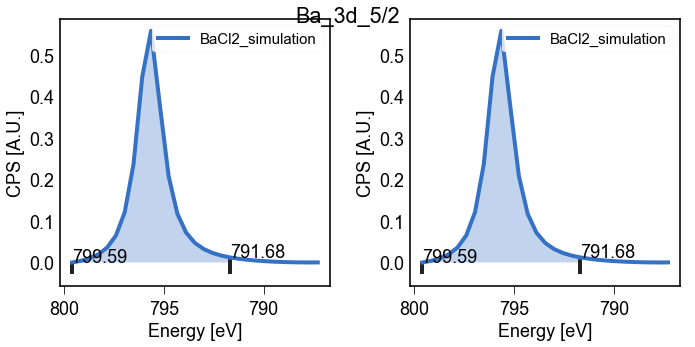

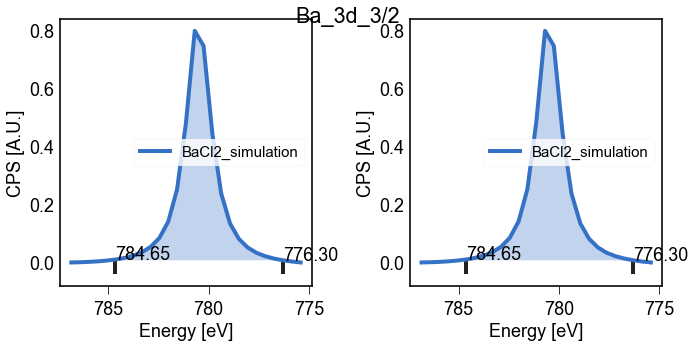

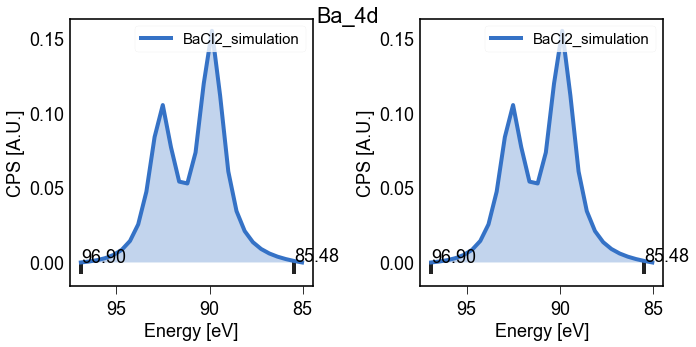

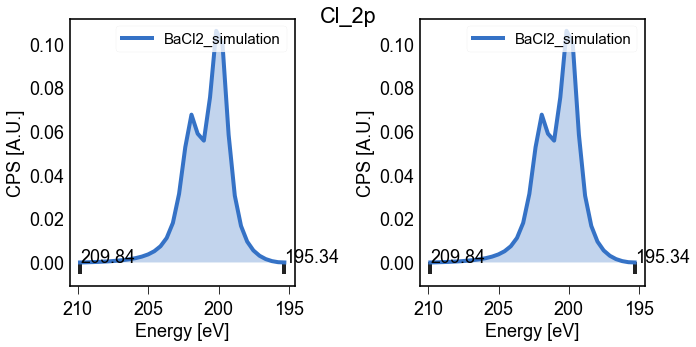

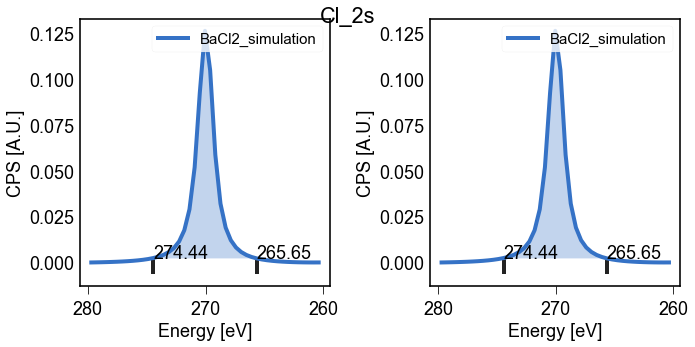

In [946]:
xp = bgsim
nsigma = 6
for r in regs:
#     region = 'Cl_2s'
    Fn = XPFit(xp, r)
    if r == 'Ba_4d':
        fitv = Fn.double_voigt(91)
        edw = fitv.best_values['v1_center'] - nsigma*fitv.best_values['v1_sigma']
        eup = fitv.best_values['v2_center'] + nsigma*fitv.best_values['v2_sigma']
    else:
        fitv = Fn.voigt()
#     Fn.plot(ax=plt.gca())

        edw = fitv.best_values['v1_center'] - nsigma*fitv.best_values['v1_sigma']
        eup = fitv.best_values['v1_center'] + nsigma*fitv.best_values['v1_sigma']

    integrateRegions([xp, xp], r, asf=asf, eup=eup, edw=edw, )

In [939]:
bgsim.area['Cl_2p'] / (bgsim.area['Ba_3d_5/2'] + bgsim.area['Ba_3d_3/2'])

0.7997061419311815

In [940]:
bgsim.area['Cl_2s'] / (bgsim.area['Ba_3d_5/2'] + bgsim.area['Ba_3d_3/2'])

1.5837402184887241

In [947]:
num = ['Cl_2p', 'Cl_2s', 'Cl_2p']
denom = ['Ba_4d', 'Ba_4d', 'Cl_2s']
make_stoichometry_table([bgsim], num=num, denom=denom)

Experiment	Cl_/Ba_	Cl_/Ba_	Cl_/Cl_	
BaCl2_simulation	1.76 	 3.49 	 0.50 	 


In [948]:
bgsim.area['Ba_4d'] / (bgsim.area['Ba_3d_5/2'] + bgsim.area['Ba_3d_3/2'])

0.4539339543860577

# Fit O 1s with Au 4p

In [40]:
path = '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_21_*/**/*.uxy'

files = glob.glob(path, recursive=True)
files.sort()

samp3 = [read_processed_xp(f) for f in files]
cols = ['k','g', 'b', 'y', 'm', 'c', 'r', 'lime']
for xp, c in zip(samp3, cols):
    xp.color = c

[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_21_Au111/proc/20210520_Au111_clean.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_21_Au111/proc/20210521_Au111_FBI_subl_45min.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_21_Au111/proc/20210521_Au111_FBI_subl_45min_BaCl2_10s.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_21_Au111/proc/20210522_Au111_FBI_subl_45min_BaCl2_20s.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_21_Au111/proc/20210523_Au111_FBI_subl_45min_BaCl2_30s.uxy.ft', returning empty fit dict
[Errno 2] No such file or directory: '/Users/pabloherrero/sabat/xps_spectra/Au111_FBI/2021_05_21_Au111/proc/20210523_Au

## Subtract fit components

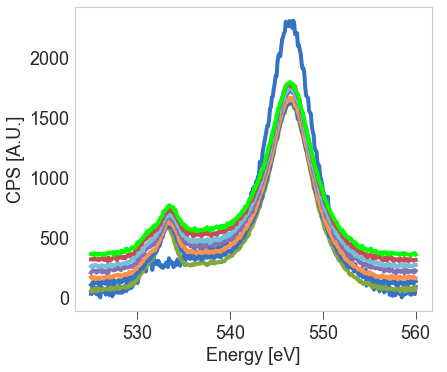

In [105]:
r = 'O_1s'
for i,xp in enumerate(samp3):
    plot_region(xp, r, offset=50*i)
    plt.gca().get_legend().remove()

Best chi2 value for 3 components


[10610.377012291445, 1410.9837978768455, 1270.8589439234863, 9614.905045133579]

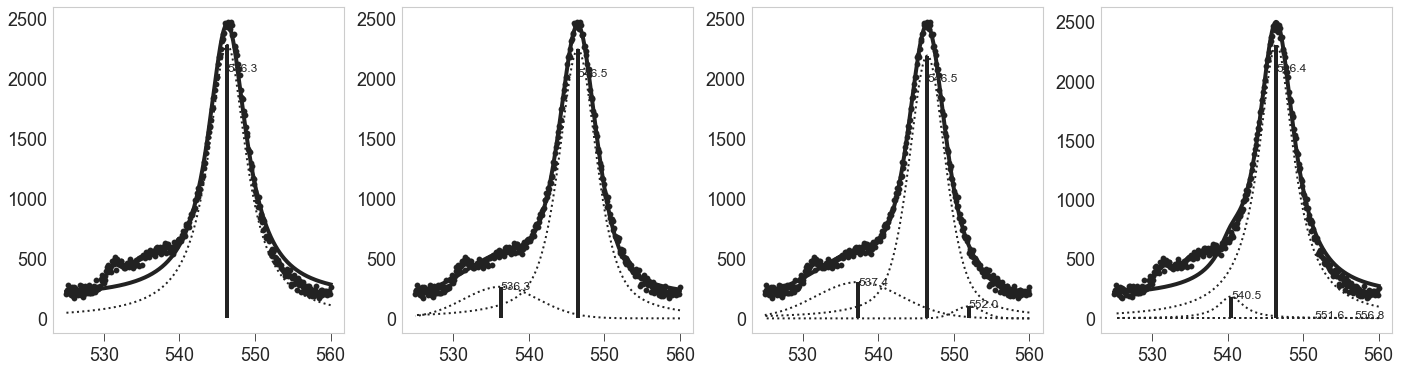

In [109]:
fit_n_voigt(samp3[0], r, max_comps = 4, )

Best chi2 value for 3 components


[15789.972944350082, 1731.5953392731528, 294.62912857470525, 348.8043353821884]

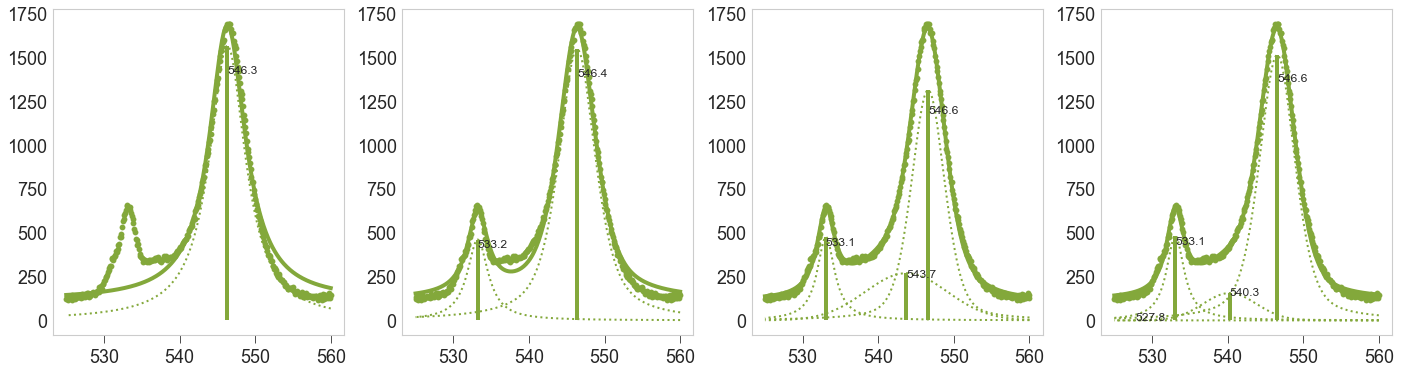

In [106]:
fit_n_voigt(samp3[1], r, max_comps = 4, )

In [117]:
def fit_n_voigt(xp: XPS_experiment, region: str, max_comps: int=3, flag_save: bool = False):
    """Fits up to max_comps voigt components and returns reduced chi2 for each fit
    Args:
        max_comps: int, maximum number of components to look for
        flag_save: bool, if True, stores each fit (as many as max_comps) in xp.fit[region_i_comps]
    """
    chis = []
    x = xp.dfx[region].dropna().energy.values
    y = xp.dfx[region].dropna().counts.values
    xs = [x]
    ys = [y]
    fig, ax = plt.subplots(1, max_comps, figsize=(6*max_comps, 6))

    for ncomps in range( max_comps):
        if ncomps > 0:
            sigmas = np.array([fitv.best_values['v'+str(i)+'_sigma'] for i in range(ncomps)])

            largest_comp = np.argmin(sigmas)
            xs, ys = split_component(xs, ys, largest_comp)

        mod, pars = set_mod_pars(ncomps+1, xs, ys)

        fitv = mod.fit(y, pars, x=x)
        plot_fit_result(xp, region, fitv, ax=ax[ncomps])
        ax[ncomps].invert_xaxis()
        chis.append(fitv.redchi)
        if flag_save: xp.fit[region+'_'+str(ncomps+1)+'comps'] = fitv
    print('Best chi2 value for %i components' %(np.argmin(chis)+1))
    return chis

Best chi2 value for 3 components


[14068.922787306567, 1425.4395286134613, 283.7004509696473]

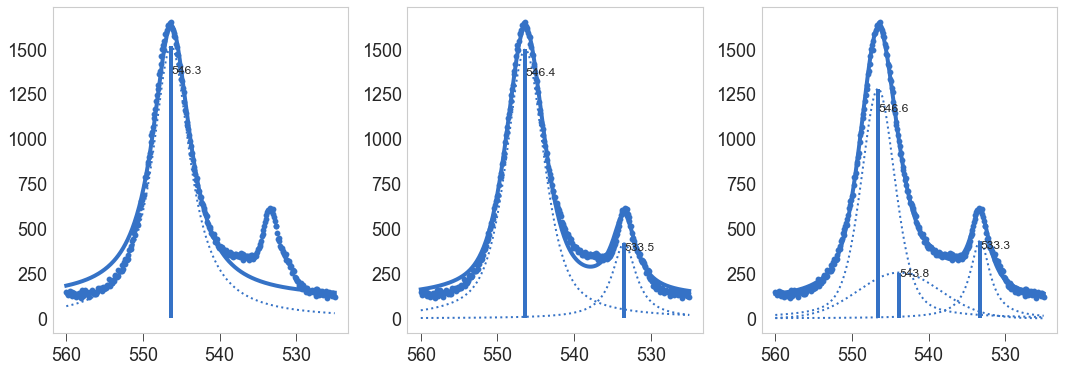

In [118]:
fit_n_voigt(samp3[2], r, max_comps = 3, flag_save=True)

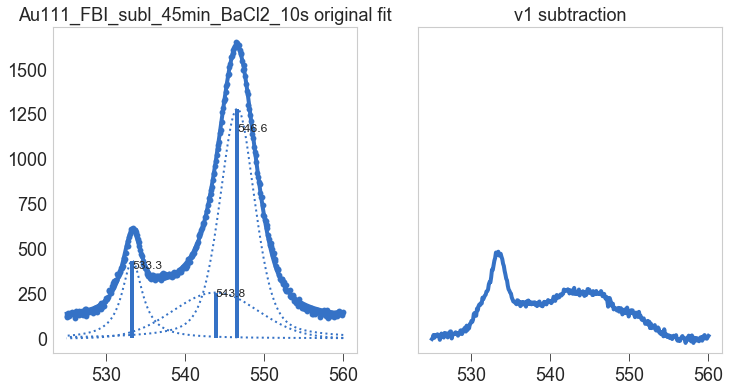

In [141]:
xpsub = subtract_fit_component(samp3[2], r, prefix='v0_', fitRes=samp3[2].fit['O_1s_3comps'], )

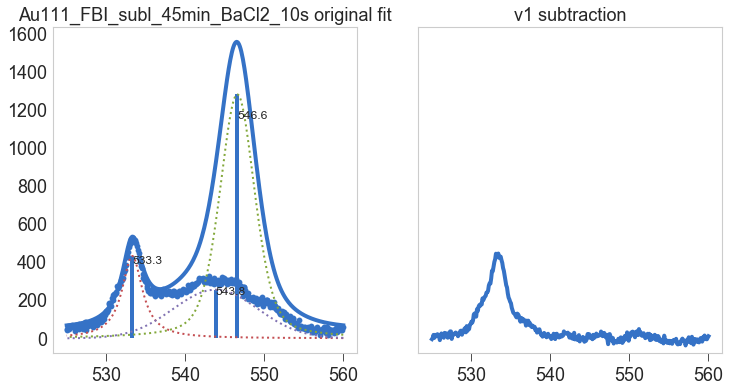

In [146]:
xpsubsub = subtract_fit_component(xpsub, 'O_1s-v0_', prefix='v2_', fitRes=samp3[2].fit['O_1s_3comps'], )

Best chi2 value for 3 components
Best chi2 value for 3 components
Best chi2 value for 3 components
Best chi2 value for 3 components
Best chi2 value for 3 components
Best chi2 value for 3 components
Best chi2 value for 3 components


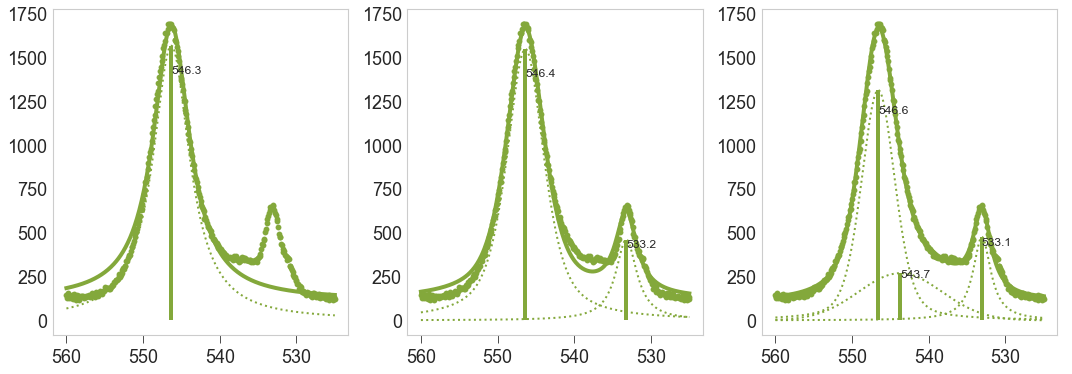

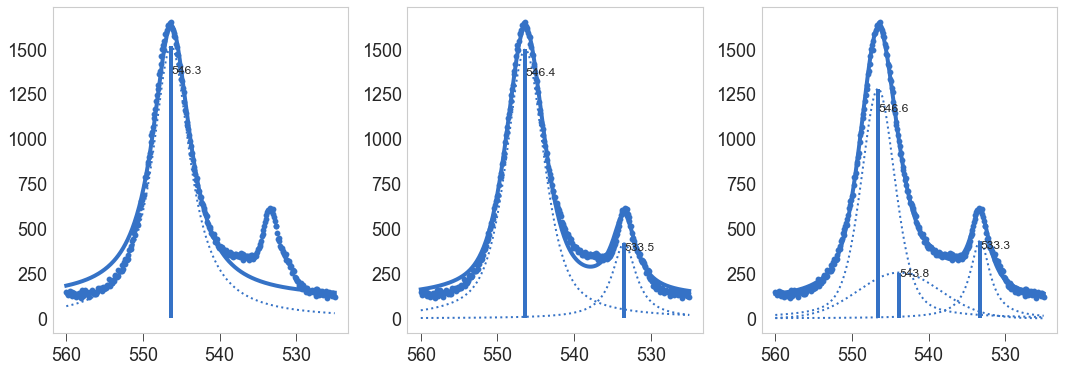

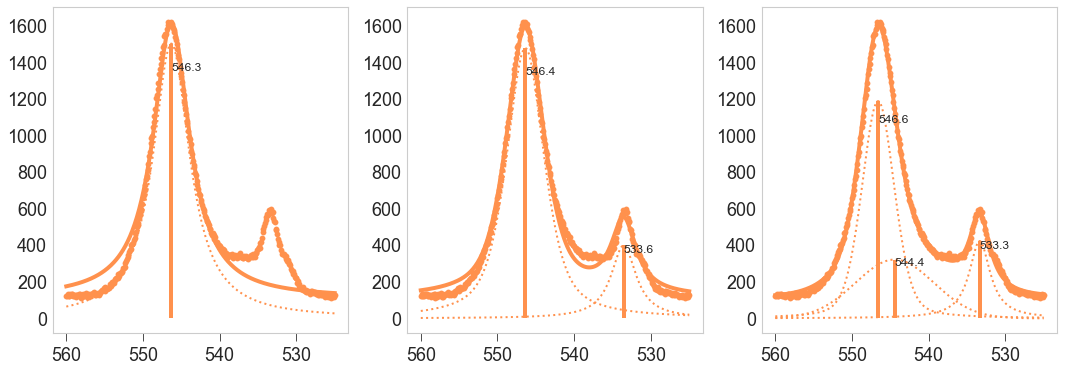

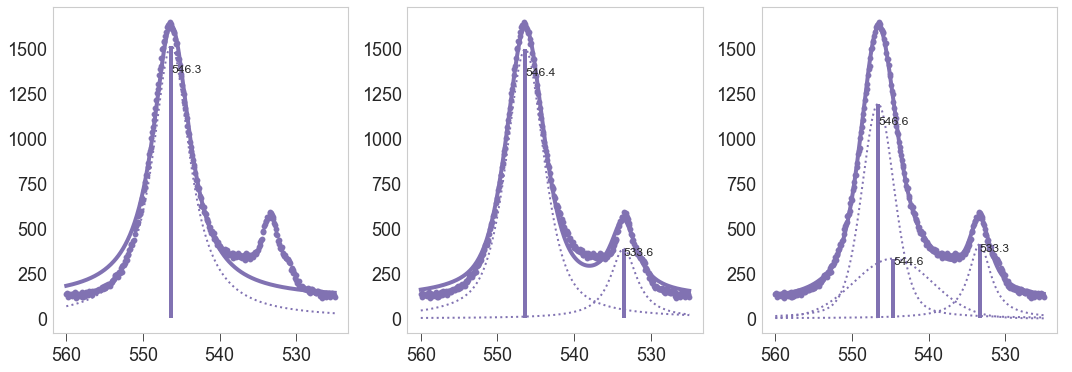

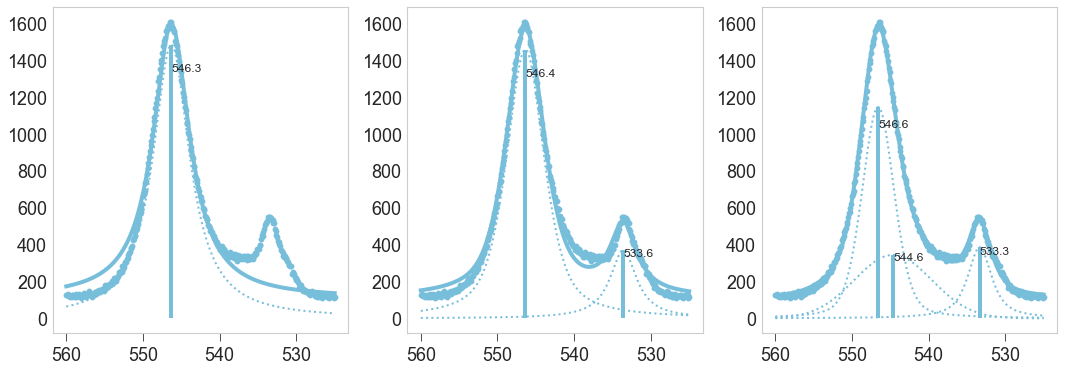

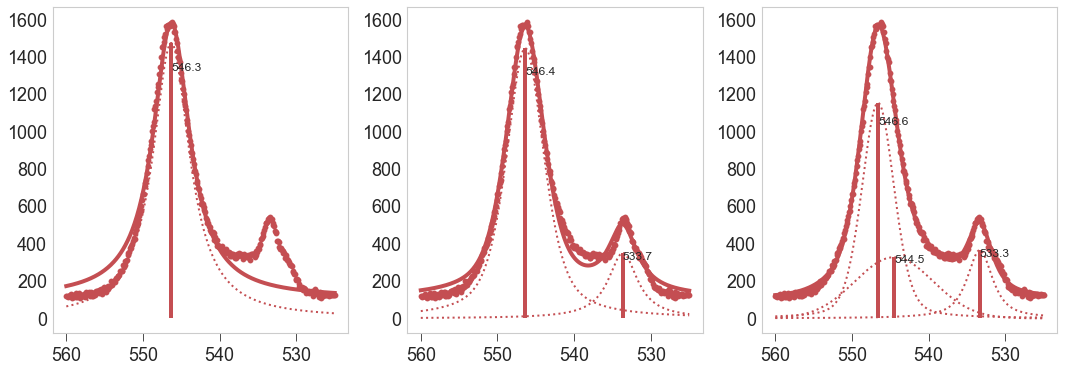

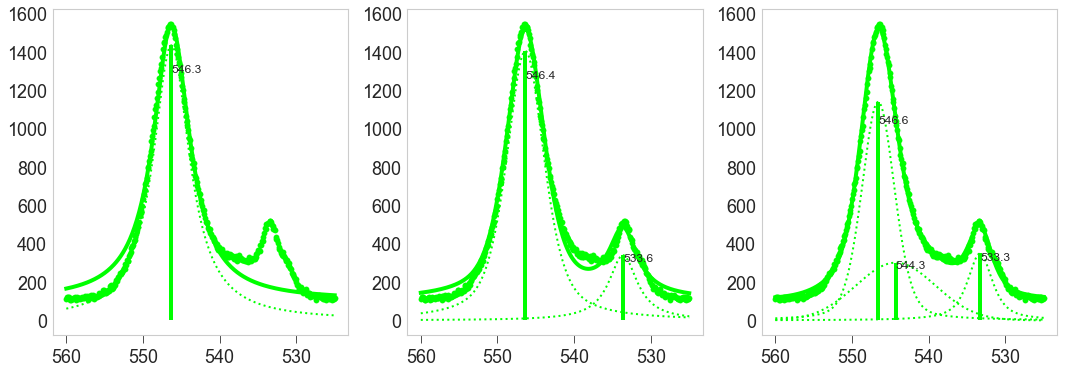

In [153]:
ausub_exps =  []
r = 'O_1s'
for xp in samp3[1:]:
    fit_n_voigt(xp, r, max_comps = 3, flag_save=True)
    xpsub = subtract_fit_component(xp, r, prefix='v0_', fitRes=xp.fit['O_1s_3comps'], flag_plot=False)
    xpsubsub = subtract_fit_component(xpsub, 'O_1s-v0_', prefix='v2_', fitRes=xp.fit['O_1s_3comps'], flag_plot=False)
    ausub_exps.append(xpsubsub)

In [176]:
cols = [ 'g', 'b', 'y', 'm', 'c', 'r', 'k']
for xp, c in zip(ausub_exps, cols):
    xp.color = c

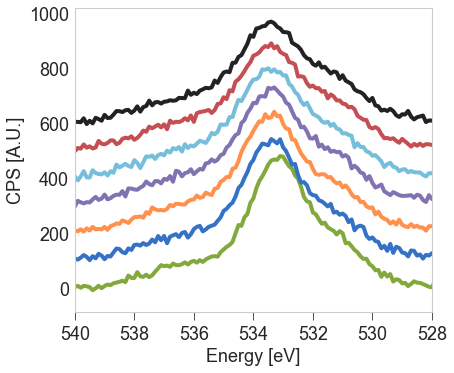

In [177]:
for i,xp in enumerate(ausub_exps):
    plot_region(xp, 'O_1s-v0_-v2_', offset=100*i)
ax = plt.gca()
ax.set(xlim=(540, 528))
ax.get_legend().remove()

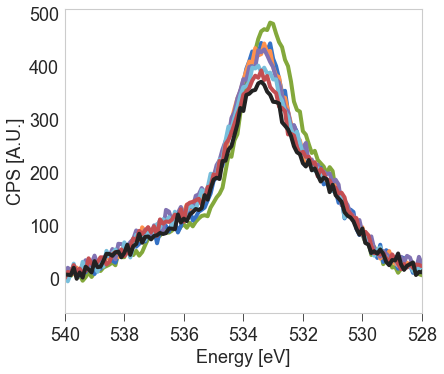

In [178]:
for i,xp in enumerate(ausub_exps):
    plot_region(xp, 'O_1s-v0_-v2_', offset=0*i)
ax = plt.gca()
ax.set(xlim=(540, 528))
ax.get_legend().remove()

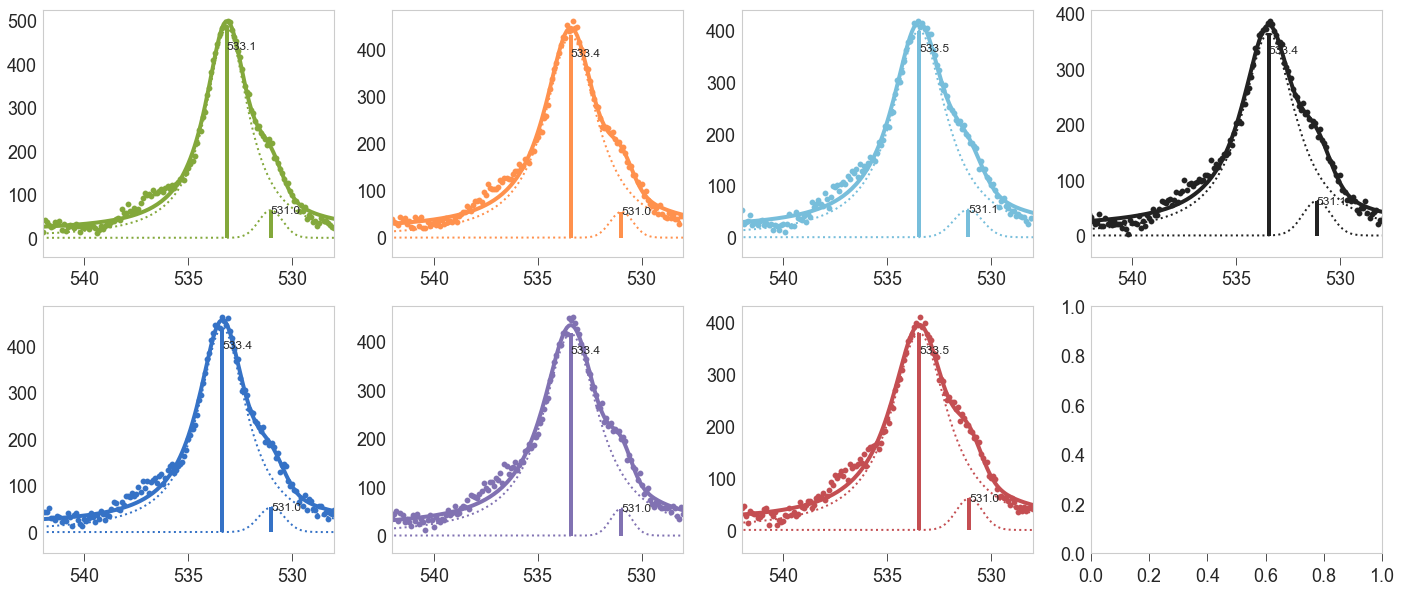

In [186]:
fig, ax = plt.subplots(2,4, figsize=(24, 10))
for i,xp in enumerate(ausub_exps):
    j,k = i//2, i%2
    Fn = XPFit(xp, 'O_1s-v0_-v2_')
    Fn.double_voigt(sepPt=532)
    plot_fit_result(xp, 'O_1s-v0_-v2_', ax=ax[k,j])
    ax[k,j].set(xlim=(542, 528))
# ax.get_legend().remove()

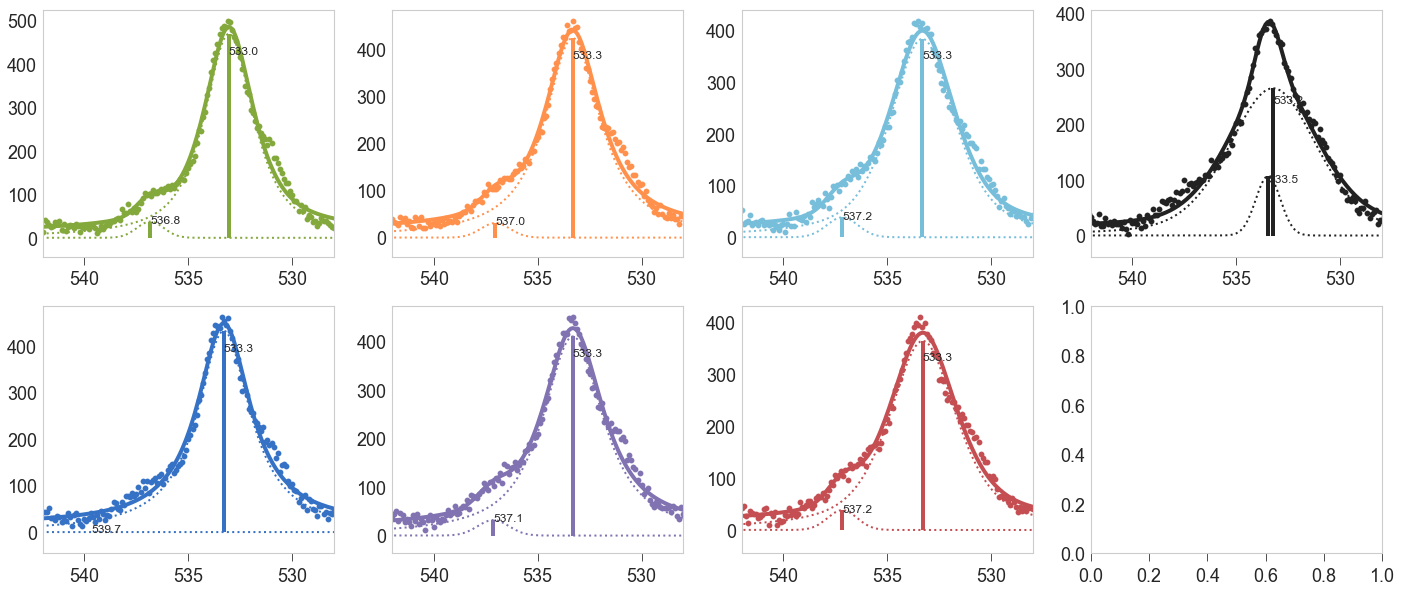

In [185]:
fig, ax = plt.subplots(2,4, figsize=(24, 10))
for i,xp in enumerate(ausub_exps):
    j,k = i//2, i%2
    Fn = XPFit(xp, 'O_1s-v0_-v2_')
    Fn.double_voigt(sepPt=535)
    plot_fit_result(xp, 'O_1s-v0_-v2_', ax=ax[k,j])
    ax[k,j].set(xlim=(542, 528))
# ax.get_legend().remove()

## Subtract clean gold for Sample 3 (progBa)

In [644]:
def subtract_ref_region(xp : XPS_experiment, xpRef: XPS_experiment, region: str, inplace : bool = False):
    """Subtract the counts in a region in xpRef from xp"""

    df, dfRef = xp.dfx[region].dropna(), xpRef.dfx[region].dropna()
    y_sub = df.counts - dfRef.counts
    if inplace:
        xp.dfx[region] = pd.DataFrame([xp.dfx[region].energy, y_sub]).T
        return xp
    else:
        xpNew = deepcopy(xp)
        xpNew.dfx[region] = pd.DataFrame([xpNew.dfx[region].energy, y_sub]).T
        return xpNew

In [396]:
norm3 = [normalise_dfx(xp, r) for xp in raw3]

In [49]:
li

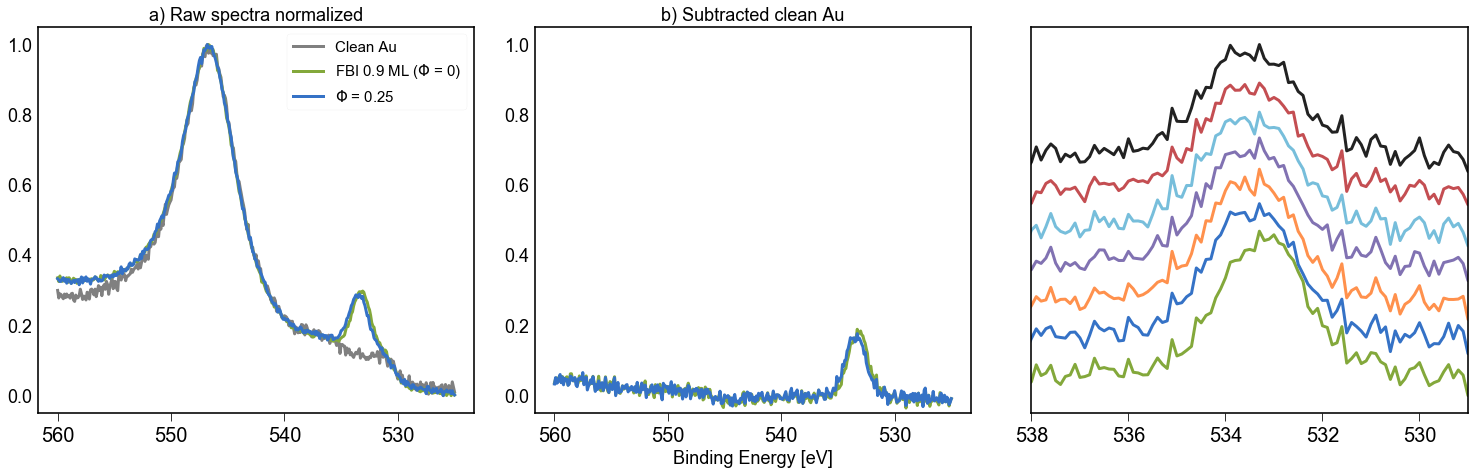

In [520]:
plt.rcParams['lines.linewidth'] = 3

region = 'O_1s'
xp0 = norm3[0]
fig, ax = plt.subplots(1, 3, figsize=(21, 7))
x = xp0.dfx[region].dropna().energy.values
y0 = xp0.dfx[region].dropna().counts.values
lb = ['Clean Au', 'FBI 0.9 ML ($\\Phi$ = 0)', '$\\Phi$ = 0.25']

refau_sub = []
for i,xp in enumerate(norm3):
    if i < 3:
        plot_region(xp, region, ax=ax[0])
    xpdif = subtract_ref_region(xp, norm3[0], region)
    if i > 0:
        x = xpdif.dfx[region].energy
        y = xpdif.dfx[region].counts
        if i < 3:
            plot_region(xpdif, region, ax=ax[1])
            
#         ax[2].scatter(x, y, color=xpdif.color)
        plot_region(xpdif, region, offset=0.05*i, ax=ax[2])
    crop_spectrum(xpdif, region, eup=538, edw=529, inplace=True)
    refau_sub.append(xpdif)
ax[0].legend(ax[0].get_lines(), lb)

tit = ['a) Raw spectra normalized', 'b) Subtracted clean Au', '']
for j,a in enumerate(ax):
    a.set_title(tit[j])
ax[0].invert_xaxis()
ax[1].invert_xaxis()
ax[1].set(ylim=ax[0].get_ylim(), xlabel='Binding Energy [eV]')

ax[2].set(yticks=[], xlim=(538, 529), ylabel=None, xlabel=None)
ax[2].get_legend().remove()
# ax[2].invert_xaxis()
plt.tight_layout()
plt.savefig('/Users/pabloherrero/Dropbox/phd/drafts/fbi_cu_sublimation/v4_au/si_figures/si_ausub.a).png',
            dpi=2000)

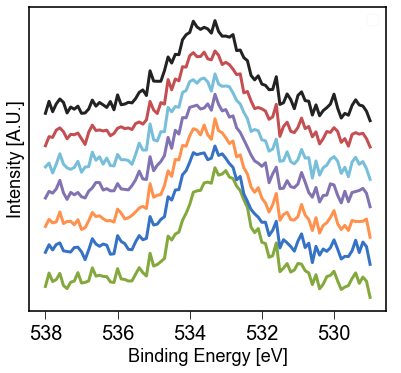

In [519]:
fbibaratio = [0, 0.25, 0.33, 0.36 , 0.50, 0.55, 0.63]
for i,xp in enumerate(refau_sub[1:]):
    plot_region(xp, region, offset=0.05*i, lb='__nolabel__')#'$\\Phi$ = %.2f'%fbibaratio[i])
    
ax = plt.gca()
ax.set(yticks=[],xlabel='Binding Energy [eV]', ylabel='Intensity [A.U.]')
plt.savefig('/Users/pabloherrero/Dropbox/phd/drafts/fbi_cu_sublimation/v4_au/si_figures/si_ausub.b).png',
            dpi=2000)

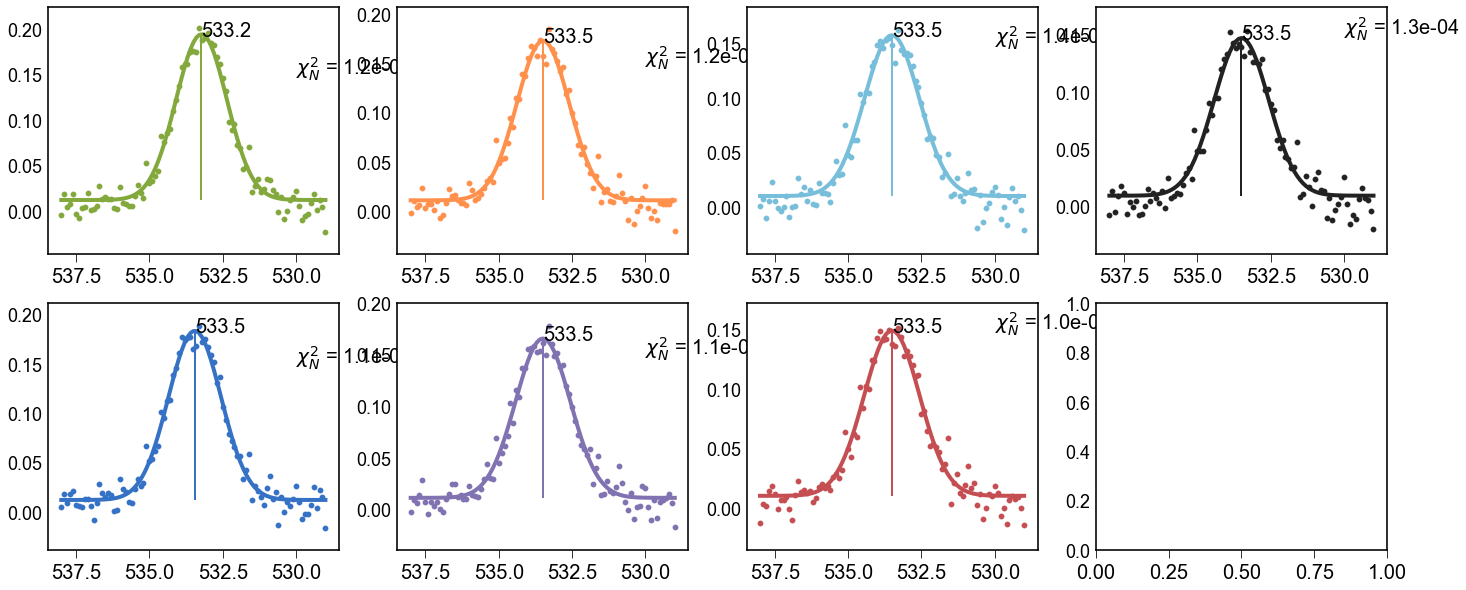

In [400]:
r = 'O_1s'
fig, ax = plt.subplots(2,4, figsize=(24, 10))
for i,xp in enumerate(refau_sub[1:]):
    j,k = i//2, i%2
    Fn = XPFit(xp, r)
    
    Fn.voigt()
    plot_fit_result(xp, r, ax=ax[k,j])
    ax[k,j].text(s='$\chi^2_N$ = %.1e' %xp.fit[r].redchi, x=530, y=0.15)
# ax.get_legend().remove()

In [38]:
r = 'O_1s'
for xp in refau_sub[1:]:
    print(2*xp.fit[r].best_values['v1_sigma'])

2.0372635353665682
2.116524089939846
2.1066406245443146
2.194319467064778
2.2006124305789685
2.227354370436231
2.1904131304029306


In [39]:
2.227/2.037

1.0932744231713303

Modify user pars
Modify user pars
Modify user pars
Modify user pars
Modify user pars
Modify user pars


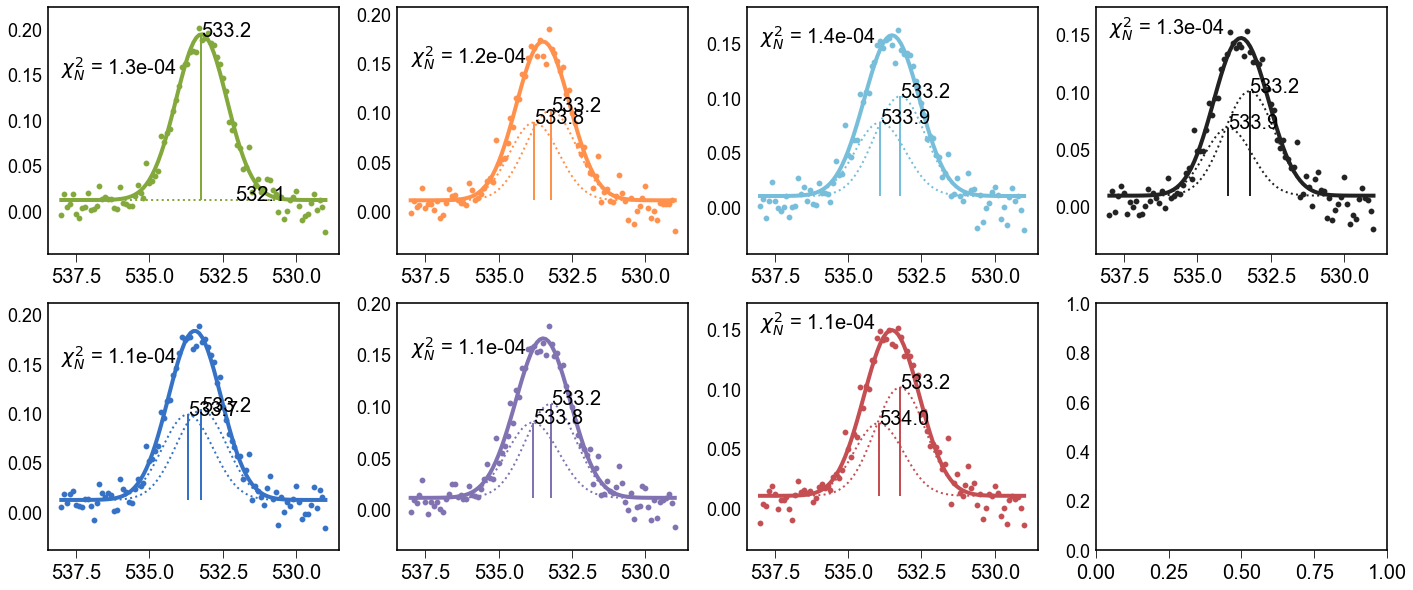

In [401]:
fig, ax = plt.subplots(2,4, figsize=(24, 10))
for i,xp in enumerate(refau_sub[1:]):
    j,k = i//2, i%2
    Fn = XPFit(xp, 'O_1s')
    if i > 0:
        Fn.preset_pars('v2_sigma', refau_sub[1].fit['O_1s'].best_values['v2_sigma'])
        Fn.preset_pars('v2_center', refau_sub[1].fit['O_1s'].best_values['v2_center'])
        Fn.preset_pars('v2_amplitude', refau_sub[1].fit['O_1s'].best_values['v2_amplitude']/2)
    if i > 1:
        Fn.preset_pars('v2_amplitude', refau_sub[2].fit['O_1s'].best_values['v2_amplitude'])  
#         Fn.preset_pars('v1_amplitude', refau_sub[2].fit['O_1s'].best_values['v1_amplitude'])
#         Fn.preset_pars('v1_sigma', refau_sub[2].fit['O_1s'].best_values['v1_sigma'])
    Fn.double_voigt(sepPt=532)
    plot_fit_result(xp, 'O_1s', ax=ax[k,j])
    ax[k,j].text(s='$\chi^2_N$ = %.1e' %xp.fit[r].redchi, x=538, y=0.15)
    
# ax.get_legend().remove()

In [29]:
r = 'O_1s'
for xp in refau_sub[1:]:
    print(xp.fit[r].best_values['v1_center'], xp.fit[r].best_values['v2_center'])

532.0670148206846 533.2235935444941
533.6947925946507 533.2235935444941
533.7900736216116 533.2235935444941
533.8378226443486 533.2235935444941
533.9027762947799 533.2235935444941
533.9559847660724 533.2235935444941
533.9455503998711 533.2235935444941


In [36]:
r = 'O_1s'
for xp in refau_sub[1:]:
    print(2*xp.fit[r].best_values['v1_sigma'], 2*xp.fit[r].best_values['v2_sigma'])

9.59168271481212 2.0372638454898597
2.0369404099415496 2.0372638454898597
1.9781777887551417 2.0372638454898597
2.0839781041459453 2.0372638454898597
2.0303932591272984 2.0372638454898597
1.9774705862839812 2.0372638454898597
1.9149084535062104 2.0372638454898597


In [249]:
r = 'O_1s'
for xp in refau_sub[1:]:
    print(xp.fit[r].best_values['v1_amplitude'], xp.fit[r].best_values['v2_amplitude'])

2.8388180695060328e-11 0.39536239901557746
0.1877351447848219 0.19768119950778873
0.16634631652641052 0.19768119950778873
0.1617182509207138 0.19768119950778873
0.14547738288136425 0.19768119950778873
0.12862415242237035 0.19768119950778873
0.12062105408917079 0.19768119950778873


## Subtract Clean Au for Sample 2

In [268]:
r = 'O_1s'
##norm2 = [normalise_dfx(xp,r) for xp in [raw3[0]]+raw2[1:]]

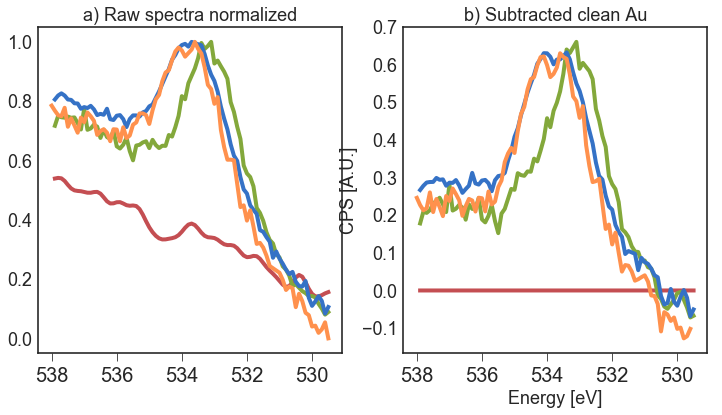

In [326]:
region = 'O_1s'
xp0 = gaussian_smooth(norm2[0], region, sigma=2)
# xp0 = norm2[0]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
x = xp0.dfx[region].dropna().energy.values
y0 = xp0.dfx[region].dropna().counts.values
# ax[0].plot(x, y0)
refau_sub2 = []
for i,xp in enumerate([xp0]+norm2[1:]):
    plot_region(xp, region, ax=ax[0])
    xpdif = subtract_ref_region(xp, xp0, region)
    plot_region(xpdif, region, ax=ax[1])
#     crop_spectrum(xpdif, region, eup=538, edw=529, inplace=True)
    refau_sub2.append(xpdif)
    
tit = ['a) Raw spectra normalized', 'b) Subtracted clean Au', 'c) Same as b) with offset and shorter energy range']
for j,a in enumerate(ax):
    a.set_title(tit[j])
ax[0].invert_xaxis()
ax[1].invert_xaxis()
ax[1].get_legend().remove()
# ax[2].invert_xaxis()

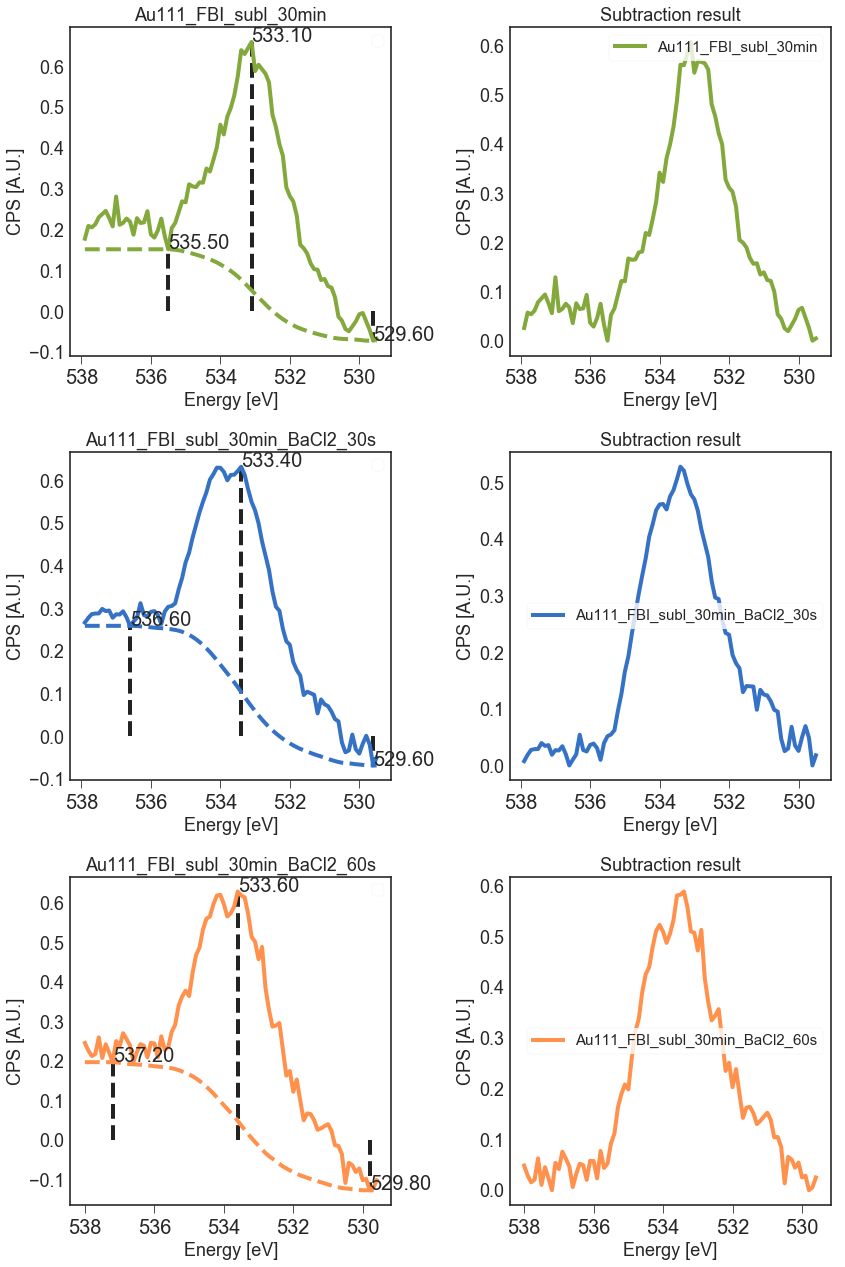

In [327]:
refau_sub2[1:] = region_bg_subtract(refau_sub2[1:], region)

In [312]:
for xp in refau_sub2[1:]:
    xp.dfx['O_1s_bg'].counts = xp.dfx['O_1s_bg'].dropna().counts + y0

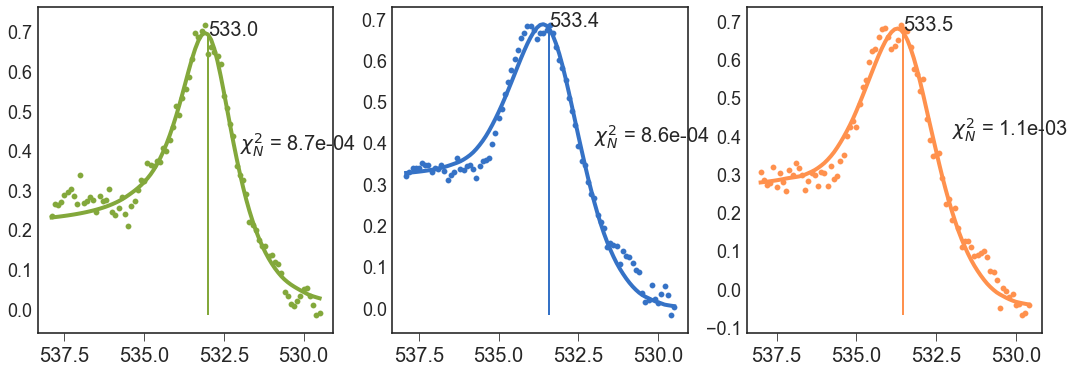

In [328]:
r = 'O_1s'
fig, ax = plt.subplots(1,3, figsize=(18, 6))
for i,xp in enumerate(refau_sub2[1:]):
    Fn = XPFit(xp, r)
    
    Fn.voigt()
    plot_fit_result(xp, r, ax=ax[i], plot_bg=True)
    ax[i].text(s='$\chi^2_N$ = %.1e' %xp.fit[r].redchi, x=532, y=0.4)
# ax.get_legend().remove()

Modify user pars
Modify user pars
Modify user pars


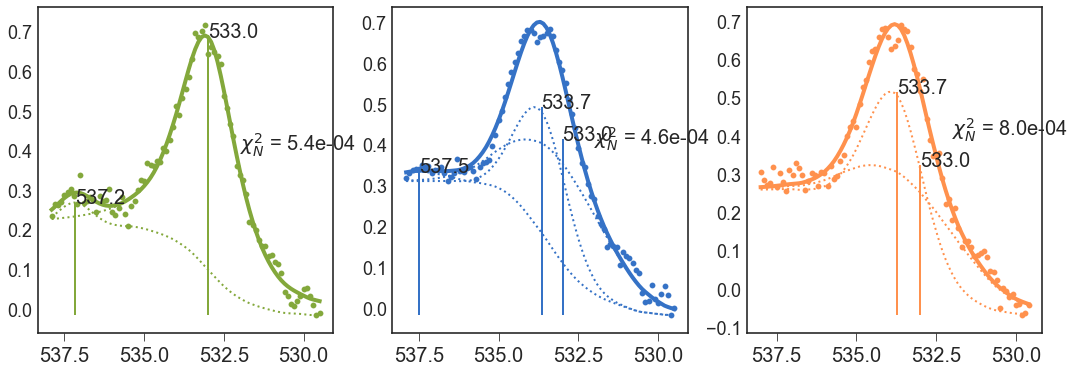

In [329]:
r = 'O_1s'
fig, ax = plt.subplots(1,3, figsize=(18, 6))
for i,xp in enumerate(refau_sub2[1:]):
    Fn = XPFit(xp, r)
    if i > 0:
#         Fn.preset_pars('v2_sigma', refau_sub2[1].fit['O_1s'].best_values['v2_sigma'])
        Fn.preset_pars('v2_center', refau_sub2[1].fit['O_1s'].best_values['v2_center'])
        Fn.preset_pars('v2_amplitude', refau_sub2[1].fit['O_1s'].best_values['v2_amplitude']/2)
    fitv = Fn.double_voigt(sepPt=532)
    if i == 1: Fn.gauss_shoulder(fitv, par_g=[0.1, 537, 1], bounds_g=[(0.01, 0.2), (536.5, 537.5), (0.8, 1.5)])
    plot_fit_result(xp, r, ax=ax[i], plot_bg=True)
    ax[i].text(s='$\chi^2_N$ = %.1e' %xp.fit[r].redchi, x=532, y=0.4)
# ax.get_legend().remove()

## Subtract Clean Au for Sample 1 (NaCl)

In [16]:
# nacl[0], nacl[1] = nacl[1], nacl[0]
[xp.name for xp in raw1]

['Au111_clean',
 'Au111_FBI_subl_30min',
 'Au111_FBI_subl_30min_NaCl_2min',
 'Au111_FBI_subl_30min_NaCl_2min_150ºC']

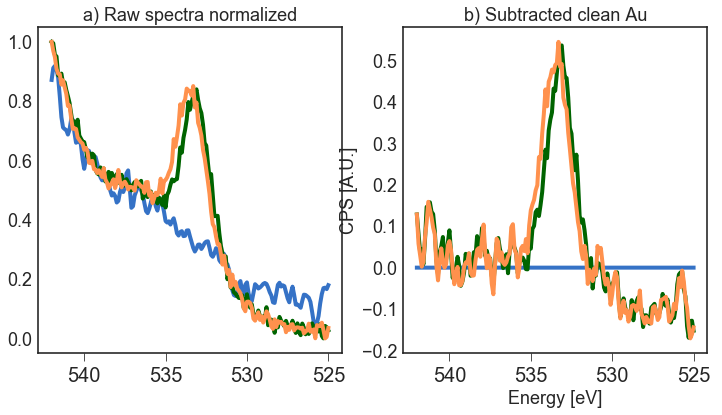

In [336]:
region = 'O_1s'
xp0 = gaussian_smooth(norm1[0], region, sigma=1)
# xp0 = norm1[0]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
x = xp0.dfx[region].dropna().energy.values
y0 = xp0.dfx[region].dropna().counts.values
# ax[0].plot(x, y0)
refau_sub1 = []
for i,xp in enumerate([xp0]+norm1[1:3]):
# for i,xp in enumerate(norm1):
    plot_region(xp, region, ax=ax[0])
    xpdif = subtract_ref_region(xp, xp0, region)
    plot_region(xpdif, region, ax=ax[1])
#     crop_spectrum(xpdif, region, eup=538, edw=529, inplace=True)
    refau_sub1.append(xpdif)
    
tit = ['a) Raw spectra normalized', 'b) Subtracted clean Au', 'c) Same as b) with offset and shorter energy range']
for j,a in enumerate(ax):
    a.set_title(tit[j])
ax[0].invert_xaxis()
ax[1].invert_xaxis()
ax[1].get_legend().remove()
# ax[2].invert_xaxis()

In [337]:
trim_spectra(refau_sub1[1], refau_sub2[1], 'O_1s', inplace=True);
trim_spectra(refau_sub1[2], refau_sub2[1], 'O_1s', inplace=True);

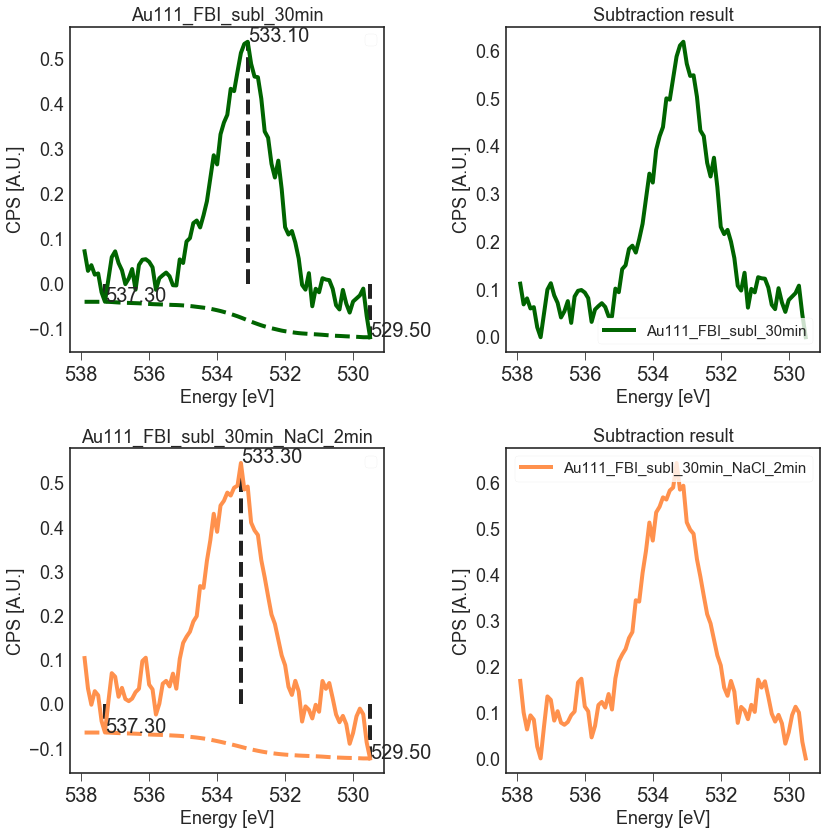

In [338]:
refau_sub1[1:] = region_bg_subtract(refau_sub1[1:], region)

In [324]:
for xp in refau_sub1[1:]:
    xp.dfx['O_1s_bg'].counts = xp.dfx['O_1s_bg'].dropna().counts + y0

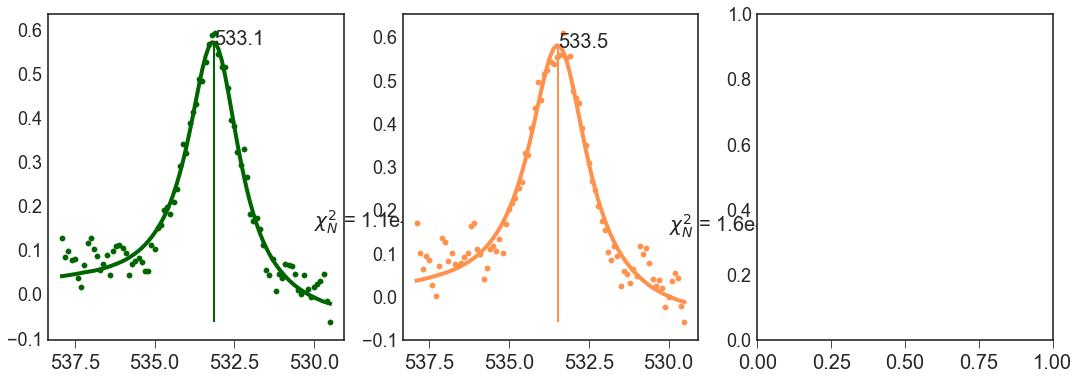

In [339]:
r = 'O_1s'
fig, ax = plt.subplots(1,3, figsize=(18, 6))
for i,xp in enumerate(refau_sub1[1:]):
    Fn = XPFit(xp, r)
    
    Fn.voigt()
    plot_fit_result(xp, r, ax=ax[i], plot_bg=True)
    ax[i].text(s='$\chi^2_N$ = %.1e' %xp.fit[r].redchi, x=530, y=0.15)
# ax.get_legend().remove()

# Export curves 

In [409]:
os.path.splitext(path+'.csv')

('/Users/pabloherrero/Dropbox/phd/drafts/fbi_cu_sublimation/v4_au/exported_data/fig2d_',
 '.csv')

In [64]:
def export_csv_region(file: str, xp: XPS_experiment, regions: list = None):
    """Export to Igor compatible csv format"""
    if regions == None: regions = xp.dfx.columns.levels[0].values
    for r in regions:
        filename, extension = os.path.splitext(file)
        filename += '_'+r
        file = filename+extension
        with open(file, 'w') as fout:
            header = r+'_BE\t' +r+'_cps\t'
            fout.write(header+'\n')
            xp.dfx[r].to_csv(fout, sep='\t', na_rep='NaN', index=None, header=False)

In [523]:
regions=['C_1s', 'N_1s', 'O_1s']
for i,xp in enumerate(sel):
    xpn = XPS_experiment(path = path)
    frames = []
        
    for j, r in enumerate(regions):
        frames.append(xp.dfx[r])
    dfx = pd.concat(frames, axis=1)
    mi = pd.MultiIndex.from_product([regions, np.array(['energy', 'counts'])], names=['range', 'properties'])

    mi.to_frame()
    dfx.columns = mi
    xpn.dfx = dfx
    export_csv(path+xp.date.replace('.','')+'_'+xp.name+'.csv', xpn)

In [518]:
path = '/Users/pabloherrero/Dropbox/phd/drafts/fbi_cu_sublimation/v4_au/exported_paper_xps_fbi/fig2_'
for xp in sel:
#     print(xp.name)
    export_csv(path+xp.date.replace('.','')+'_'+xp.name+'.csv', xp)

In [513]:
region = 'O_1s'
fbibaratio = [0, 3.85, 3.0, 2.74, 2.01, 1.87, 1.55]
frames = []
for i,xp in enumerate(refau_sub[1:]):
    frames.append(xp.dfx[region])
names = ['FBI:Ba='+str(i) for i in fbibaratio]
dfx = pd.concat(frames, axis=1)
mi = pd.MultiIndex.from_product([names, np.array(['energy', 'counts'])], names=['range', 'properties'])

mi.to_frame()
dfx.columns = mi
xp2d.dfx = dfx
export_csv(path+'FBI:Ba.csv', xp2d)

In [65]:
region = 'O_1s'
path = '/Users/pabloherrero/Dropbox/phd/drafts/fbi_cu_sublimation/v4_au/exported_paper_xps_fbi/fig2_'
# fbibaratio = [0, 3.85, 3.0, 2.74, 2.01, 1.87, 1.55]
frames = []
for i,xp in enumerate(refau_sub2[1:3]):
    print(xp.name)
    export_csv_region(path+xp.name+'.csv', xp, regions=['O_1s'])

Au111_FBI_subl_30min
Au111_FBI_subl_30min_BaCl2_30s


In [511]:
path = '/Users/pabloherrero/Dropbox/phd/drafts/fbi_cu_sublimation/v4_au/exported_paper_xps_fbi/fig2d_'
fbibaratio = [0, 3.85, 3.0, 2.74, 2.01, 1.87, 1.55]
for i,xp in enumerate(refau_sub[1:]):
    print(xp.name)
    export_csv_region(path+'FBI:Ba='+str(fbibaratio[i])+'.csv', xp, regions=['O_1s'])

Au111_FBI_subl_45min
Au111_FBI_subl_45min_BaCl2_10s
Au111_FBI_subl_45min_BaCl2_20s
Au111_FBI_subl_45min_BaCl2_30s
Au111_FBI_subl_45min_BaCl2_40s
Au111_FBI_subl_45min_BaCl2_60s
Au111_FBI_subl_45min_BaCl2_80s


In [414]:
selcu = [progba[0], progba[3], nacl[0], nacl[2]]

path = '/Users/pabloherrero/Dropbox/phd/drafts/fbi_cu_sublimation/v4_au/exported_data/fig5_cu_'
for i,xp in enumerate(selcu):
    print(xp.name)
    export_csv_region(path+xp.name+'.csv', xp, regions=['O_1s'])

16-Cu_FBI_subl_22min
16-Cu_FBI_subl_22min_BaCl2_6min
18-Cu_FBI_subl_20min
18-Cu_FBI_subl_20min_NaCl_2min


In [415]:
path = '/Users/pabloherrero/Dropbox/phd/drafts/fbi_cu_sublimation/v4_au/exported_data/fig5_ito_'
for i,xp in enumerate(qito[2:]):
    print(xp.name)
    export_csv_region(path+xp.name+'.csv', xp, regions=['O_1s'])

3-qITO_FBI_subl_40min
3-qITO_FBI_subl_40min_BaCl2_5min
3-qITO_clean


# Dev: fit + background

In [273]:
trim_spectra(norm2[2], norm2[1], 'N_1s', inplace=True);

In [402]:
def plot_fit_result(xp: XPS_experiment, region: str, fitRes: ModelResult = None,
                    lb : str = None, ax = None, col:str = None, offset: float = 0.3,
                    plot_comps: bool = True, plot_bg:bool = False, flag_fill: bool = False):
    if ax == None : ax = plt.gca()
    if col == None: col = xp.color
    if lb == None: lb = xp.name
    if fitRes == None: fitRes = xp.fit[region]

    x = xp.dfx[region].dropna().energy
    ybg = np.zeros_like(x)
    if plot_bg == True:
        try:
            ybg = xp.dfx[region+'_bg'].dropna().counts
#             ax.plot(x, ybg , ls='dotted', color=col, lw=2)
        except KeyError as e:
            print('Background not found for ', e)
            
    offset *= np.average(xp.dfx[region].dropna().counts.values)
    
    p1 = ax.scatter(x, xp.dfx[region].dropna().counts + ybg + offset,
                    color=col, label=lb, zorder = 1)

    ax.plot(x, fitRes.best_fit + ybg + offset, '-', color=col)#, label='best fit, $\chi^2_N$ = %i' %fitRes.redchi)
#     ax.legend(loc='upper left')

    if plot_comps:
        comps = fitRes.eval_components(x=x)
        for compo in comps:
            posx = fitRes.best_values[compo+'center']
            colc = ax.plot(x, comps[compo] + ybg + offset, ls='dotted', lw=2, color=col, label='__nolabel__')[0].get_color()

            ax.vlines(x=posx, ymin=ybg.min() + offset, ymax=(comps[compo] + ybg + offset).max(), lw=2, linestyle='-', colors=col)
            ax.text(x=posx, y=(comps[compo] + offset + ybg).max()*0.99, s='%.1f' %posx)
            if flag_fill:
                ax.fill_between(x, y1 = ybg, y2 = comps[compo] + ybg, alpha=0.3, color=col)
    ax.invert_xaxis()
    return ax, offset

def fix_tail_bg(xp: XPS_experiment, region: str, eup: float = None, edw: float = None,
                ax = None, store:bool = True, inplace: bool = False):
    """Subtract ALS of the upper or lower tailing of a peak.
       Parameters:
           eup: upper energy limit
           edw: lower energy limit. Specify either one or the other"""

    xpf = deepcopy(xp)
    if ax == None: ax = plt.gca()

    xpcrop = crop_spectrum(xpf, region, eup=eup, edw=edw)  # Crop the tail to fix bg subtraction
    xpcropBg = subtract_als_bg(xpcrop, region, ax=ax)           # Subtract ALS bg

    dfshort = xpcropBg.dfx[region]                         # Set energy column as index for the whole and the cropped data
    dfshort.set_index('energy', drop=False, inplace=True)
    dfWhole = xpf.dfx[region]
    dfWhole.set_index('energy', drop=False, inplace=True)

    if eup != None:
        dfWhole['counts'].loc[eup:] = dfshort.dropna()['counts'].loc[eup:]   # Update the values of the tail
    elif edw != None:
        dfWhole['counts'].loc[:edw] = dfshort.dropna()['counts'].loc[:edw]   # Update the values of the tail
    else: print('Error: specify upper or lower limit')

    dfWhole.reset_index(drop=True, inplace=True)             # Reset the index and update the dfx in XPS_experiment

    xpf.dfx[region] = dfWhole
    plot_region(xpf, region, ax = ax)
    ax.invert_xaxis()

    if inplace:
        xp.dfx[region] = dfWhole

        if store:
            region += '_bg'
            dfWhole = xp.dfx[region]                # Set energy column as index for the whole and the cropped data
            dfshort = xpcropBg.dfx[region]
        
            dfWhole.set_index('energy', drop=False, inplace=True)
            dfshort.set_index('energy', drop=False, inplace=True)

            dfWhole.counts.loc[dfshort.index.dropna()] += dfshort.counts.dropna()
            dfWhole.reset_index(drop=True, inplace=True)             # Reset the index and update the dfx in XPS_experiment
            xp.dfx[region] = dfWhole
        return xp

    else: return xpf 

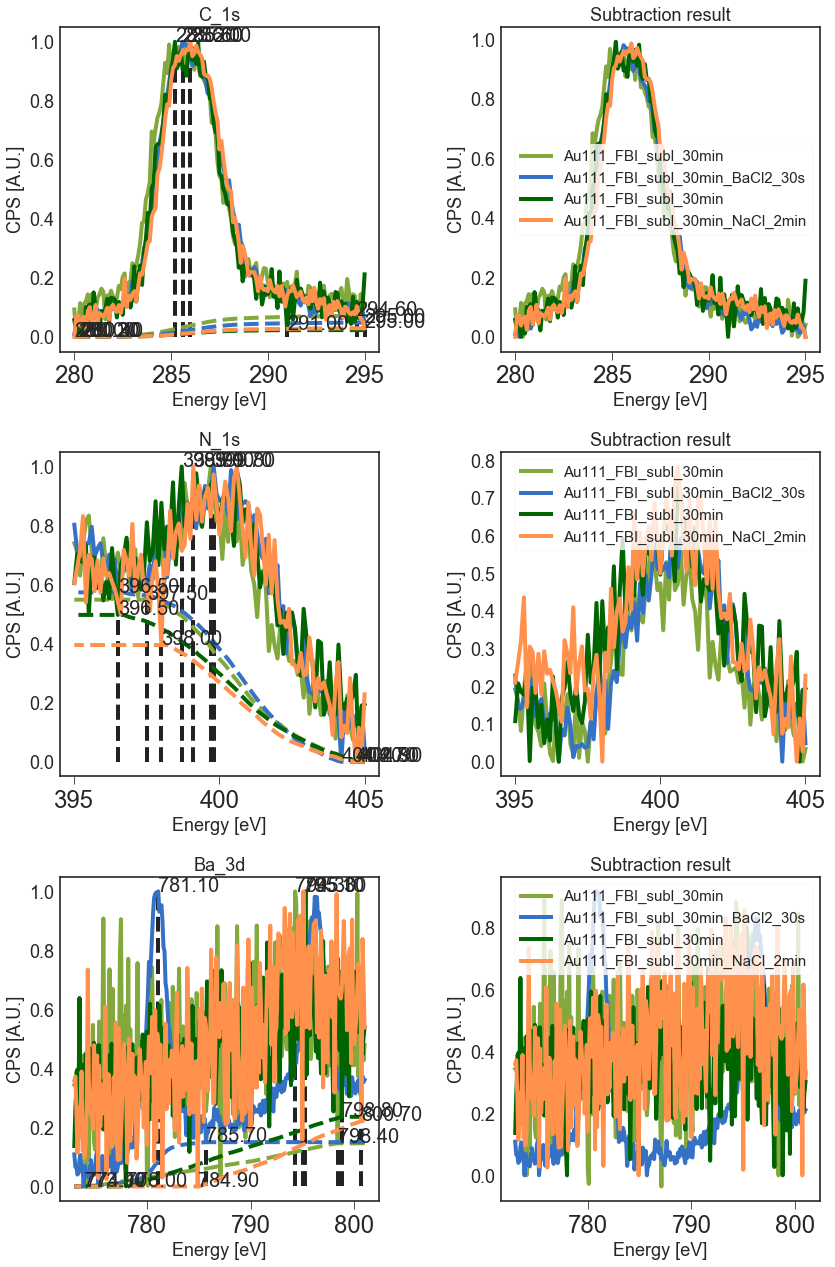

In [286]:
sel = [norm2[1], norm2[2], norm1[1], norm1[2]]
bg2 = bulk_bg_subtract(sel, ['C_1s', 'N_1s', 'Ba_3d'])

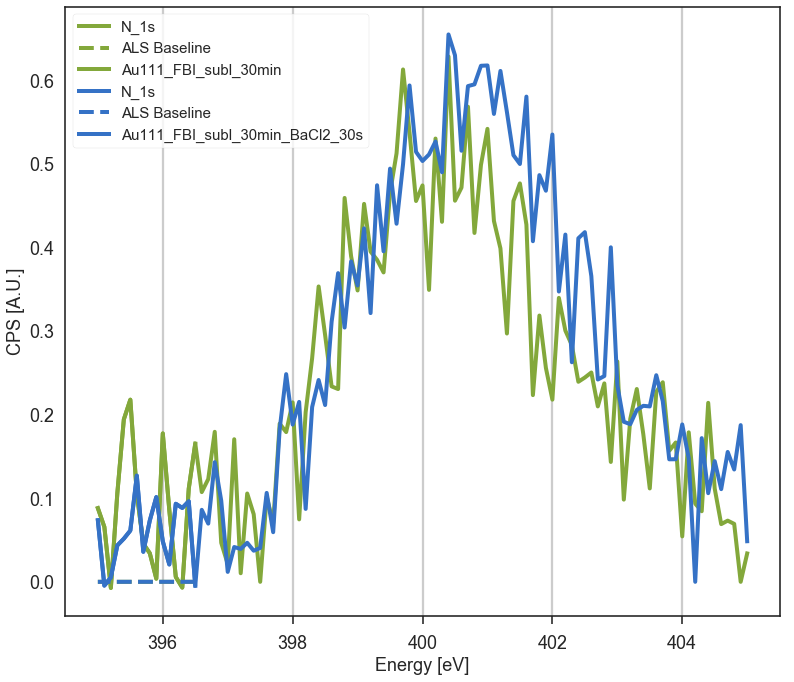

In [361]:
for xp in bg2[:2]:
    fix_tail_bg(xp, 'N_1s', eup=396.5, inplace=True);

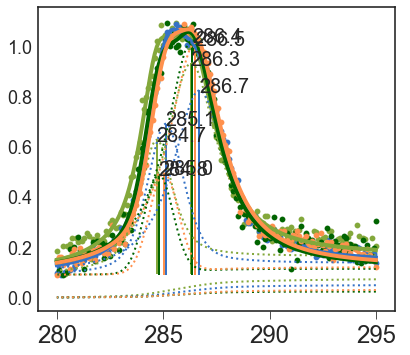

In [287]:
for xp in bg2:
    Fn = XPFit(xp, 'C_1s')
    Fn.double_voigt(sepPt=285)
    Fn.plot(plot_bg=True)

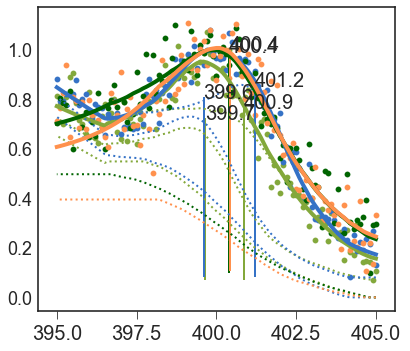

In [349]:
for i, xp in enumerate(bg2):
    Fn = XPFit(xp, 'N_1s')
    if i < 2: 
        Fn.double_voigt(400)
    else:
        Fn.voigt()
    Fn.plot(plot_bg=True)

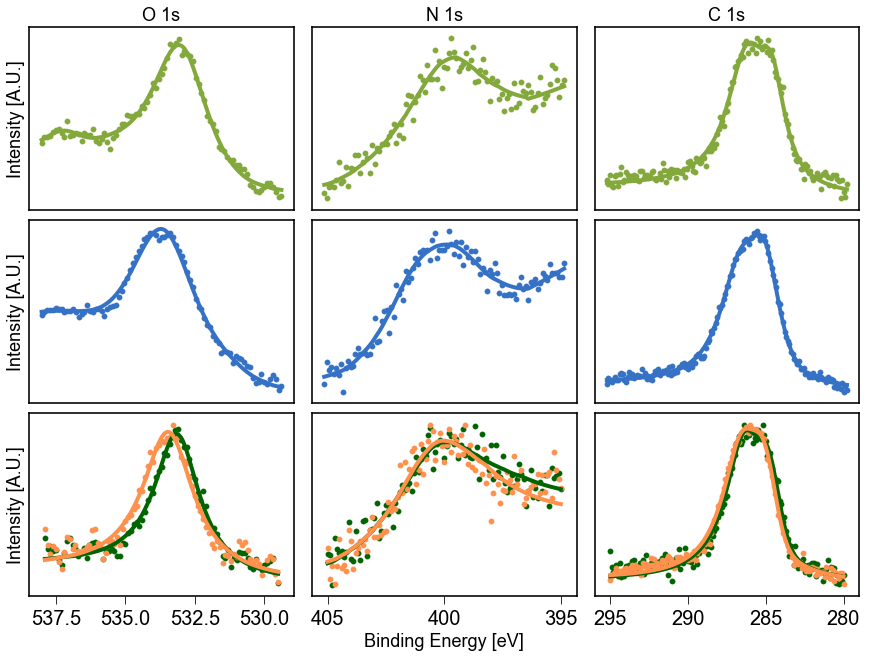

In [416]:
regs = ['N_1s', 'C_1s']
off = [800, 800, 400]
plt.rc('xtick', labelsize= 20)
plt.rc('font', size= 20)

fig, ax = plt.subplots(3,3, figsize=(12, 9), )
selo = [refau_sub2[1], refau_sub2[2], refau_sub1[1], refau_sub1[2]]
for i, xp in enumerate(selo[:3]):
    plot_fit_result(xp, 'O_1s', ax=ax[i,0], plot_bg=True, plot_comps=False)
    ax[i,0].set(yticks=[], ylabel=None, xlabel=None)
    if i < 2: ax[i,0].set(xticks=[])
    ax[i,0].set(ylabel='Intensity [A.U.]')
ax[0,0].set(title='O 1s')

plot_fit_result(selo[3], 'O_1s', ax=ax[i,0], plot_bg=True, plot_comps=False)
ax[2,0].invert_xaxis()

for j, r in enumerate(regs, start=1):
    for i, xp in enumerate(bg2[:3]):
        plot_fit_result(xp, r, ax=ax[i,j], plot_bg=True, plot_comps=False)
        ax[i,j].set(yticks=[], ylabel=None, xlabel=None)
        ax[0,j].set(title=r.replace('_', ' '))
        if i < 2: ax[i,j].set(xticks=[])
    plot_fit_result(bg2[3], r, ax=ax[i,j], plot_bg=True, plot_comps=False)
    ax[i,j].invert_xaxis()
    
ax[i,j].set(yticks=[], ylabel=None, xlabel=None)
ax[2,1].set(xlabel='Binding Energy [eV]')
# ax[i,j].get_legend().remove()
plt.tight_layout(w_pad=0.1, h_pad=0.5, pad=0.1)
plt.savefig('/Users/pabloherrero/Dropbox/phd/drafts/fbi_cu_sublimation/v4_au/fig2_xps_chelation/fig2_xps_chelation.a).png',
            dpi=2000)

In [233]:
ax.get_ylim()

(-0.09646009302000971, 1.1760214506005244)

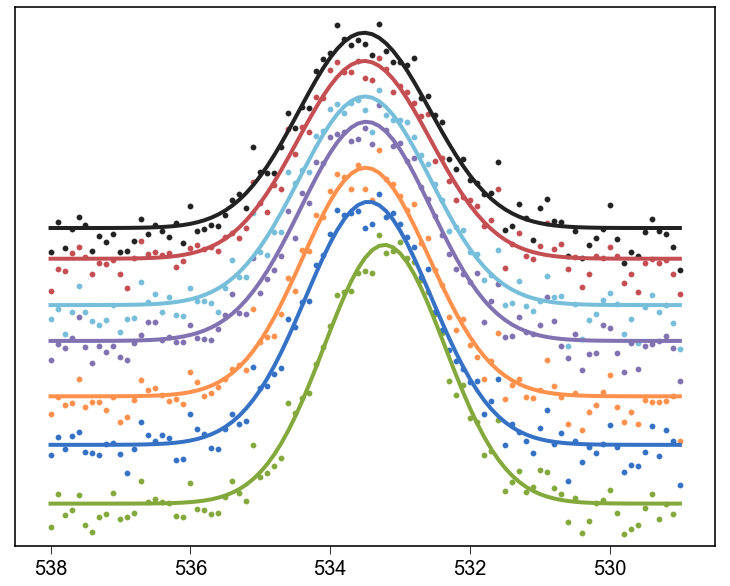

In [417]:
fbibaratio = ['$\infty$', 3.85, 3.0, 2.74, 2.01, 1.87, 1.55]
fig, ax = plt.subplots(1, sharex=False, figsize=(10, 8))
plt.xlabel("Energy [eV]")
plt.ylabel("Counts [A.U.]")
r = 'O_1s'

seps =  532
enmx, comx = [], []
handles = []
off = [0, 4, 9, 13, 19, 23, 29]
for i, xp in enumerate(refau_sub[1:]):
    off = 1*i
    plot_fit_result(xp, r, offset=off, plot_comps=False)
    ax = plt.gca()
    argmx = np.argmax(xp.dfx[r].counts)

    enmx.append(xp.dfx[r].energy.loc[argmx])
    comx.append(xp.dfx[r].counts.loc[argmx])# + off)
ax.set(ylim=(-0.03, 0.35), xlabel='', ylabel='', yticks=[])

plt.tight_layout(w_pad=0.5, h_pad=0.5, pad=0.1)     #  First manage the space and THEN add the legend
labels = [str(cov) for cov in fbibaratio]#[::-1]
# ax.legend(handles, labels, ncol=1, title='FBI:Ba ratio', loc='upper right', bbox_to_anchor=(1.4, 1.))           
plt.savefig('/Users/pabloherrero/Dropbox/phd/drafts/fbi_cu_sublimation/v4_au/fig2_xps_chelation/fig2_xps_chelation.b).png',
            dpi=2000)

In [371]:
ax.get_ylim()

(-0.07698872479145812, 0.767122717800941)